# Library

In [1]:
import logging
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000
# ChunkedEncodingError

import time
import datetime
from datetime import datetime, timedelta

import re

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

import random 
from random import sample

In [158]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

url_add = 'https://www.artsy.net'

# files
cat_dict = '/artsy_genom_cat_dict.txt'
gen_dict = '/artsy_genom_gen_dict.txt'
artwork_dict = '/artsy_genom_artwork_dict.txt'
artist_dict = '/artsy_genom_artist_dict.txt'
temp_data = '/artsy_temp_data.csv'
temp_data_add_up = '/artsy_temp_data_add_up.csv'

# id length
cat_id_len = 2
gen_id_len = 5
artist_id_len = 5

# for addition and updating
recently_added_pref = '?sort=-published_at'
recently_updated_pref = '?sort=-partner_updated_at'

# Functions

## Openings and savings

In [3]:
# 1. Save json dict
def save_dict(tree_dict, file, folder):
  if folder=='live':
    with open(art_project_path + file, 'w') as outfile:
      json.dump(tree_dict, outfile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'w') as outfile:
      json.dump(tree_dict, outfile)

# 2. Open json dict
def open_dict(file, folder):
  if folder=='live':
    with open(art_project_path + file, 'rb') as infile:
      tree_dict = json.load(infile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'rb') as infile:
      tree_dict = json.load(infile)
  return tree_dict

# 3. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 4. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)


## Parsing

### get_page

In [4]:
# 5. get_page
logging.basicConfig(level=logging.DEBUG, format="%(message)s")

def get_page(url, session):
  #response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  try:
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  except: # requests.exceptions.ChunkedEncodingError:
    print('Error: ' + str(url) + '-> resession')
    time.sleep(0.5)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})

  try:
    response.raise_for_status()
    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except requests.exceptions.HTTPError: # for correction
    pass
    print('HTTPError: ' + str(url))
    
  #bs_page = BeautifulSoup(response.text, 'html.parser')
  #return bs_page

### get next pages links list

In [5]:
# 6. get next pages links list
def get_next_page_list(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    page_link = last_page_data.get('href')[:-len(last_page)]
    next_page_link_list_new = [url + page_link + str(p) for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

# 6.1 get next pages links list
def get_next_page_list_add_up(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    last_page_link = last_page_data.get('href')
    next_page_link_list_new = [url + last_page_link.split('&')[0][:-len(last_page)] + str(p) + '&' + last_page_link.split('&')[1] for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

In [6]:
# https://www.artsy.net/gene/inlay
# https://www.artsy.net/gene/inlay?page=2
# https://www.artsy.net/gene/inlay?sort=-published_at
# https://www.artsy.net/gene/inlay?page=2&sort=-published_at

### get data from pages

In [7]:
# 7. get data from pages
def get_page_data(page):
  code_block = page.find('main').find_all('div', class_='ArtworkGrid-sc-1jsqquq-0 djwrUe')
  try:
    object_block = code_block[0].find_all('div', relay='[object Object]')
  
    # for the beggining into a DataFrame
    artsy_id_list = [obj.get('data-id') for obj in object_block]
    imgage_list = [obj.find_all('a')[0].find('img').get('src') for obj in object_block]
    artist_list = [obj.find_all('a')[1].find_all('div')[0].get_text() for obj in object_block]
  
    gallery_list = []
    for obj in object_block:
      try:
        gallery_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn hENCPo').get_text())
      except:
        gallery_list.append(np.nan)
  
    price_list = []
    for obj in object_block:
      try:
        price_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU jkuGdd').get_text())
      except:
        price_list.append(np.nan)
  
    # can be no year info !!!
    name_list = []
    year_list = []
    for obj in object_block:
      text = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').get_text()
      name = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').find('i').get_text()
      year = text.replace(name, '').replace(', ', '')
      if len(year)==0:
        year = np.nan
      name_list.append(name)
      year_list.append(year)

    df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                                'name': name_list, 
                                'link': imgage_list, 
                                'year': year_list,
                                'artist': artist_list,
                                'gallery': gallery_list,
                                'price': price_list
                                })
  except:
    df_data_new = pd.DataFrame({'artsy_id': np.nan,
                                'name': np.nan, 
                                'link': np.nan, 
                                'year': np.nan,
                                'artist': np.nan,
                                'gallery': np.nan,
                                'price': np.nan
                                }, index=[0])
  
  return df_data_new

### get category data into df - aggregator

In [8]:
# Function aggregator
# 8. Get the all category data into DataFrame
def get_df_data(df_input, genes_links_list, genes_ids_list, cat):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  df_output = df_output[0:0]

  for link in genes_links_list:
    session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6. get next pages links list
    next_page_link_list = get_next_page_list(url_add, gene_page)
    #                     get_next_page_list(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = cat
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

    df_output = pd.concat([df_output, df_data])

    # Get data from next pages
    if len(next_page_link_list) > 0:
      for page_link in next_page_link_list:
        # 5. get_page
        gene_page = get_page(page_link, session)
        #           get_page(url, session) -> 
        # -> bs_page

        # 7. get data from pages
        df_data = get_page_data(gene_page)
        #         get_page_data(page) -> 
        # -> df_data_new
        df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
        df_data['category_id'] = cat
        df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
        df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

        df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)

  return df_output

In [9]:
# Function aggregator
# 8.1 Get the first pages category data into DataFrame
def get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  #df_output['pages_count'] = np.nan # only for the first time !!!!
  #df_output['second_page_link'] = np.nan # only for the first time !!!!
  df_output = df_output[0:0]

  session = requests.Session()
  l_c = 0
  for link in genes_links_list:
    #session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    try:
      # 6.1 get next pages links list
      next_page_link_list = get_next_page_list_add_up(url_add, gene_page)
      #                     get_next_page_list_add_up(url, page) -> 
      # -> next_page_link_list_new
    except: 
      next_page_link_list = []
    
    print(len(next_page_link_list)+1, 'pages for parsing')

    try:
      # 7. get data from pages
      df_data = get_page_data(gene_page)
      #         get_page_data(page) -> 
      # -> df_data_new
    except:
      df_data = pd.DataFrame({'artsy_id': np.nan,
                              'name': np.nan, 
                              'link': np.nan, 
                              'year': np.nan,
                              'artist': np.nan,
                              'gallery': np.nan,
                              'price': np.nan
                              }, index=[0])
      
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = genes_cat_list[genes_links_list.index(link)] # cat !!!!!!!!!
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['pages_count'] = len(next_page_link_list)+1
    if len(next_page_link_list) > 0:
      df_data['second_page_link'] = next_page_link_list[0]
    else:
      df_data['second_page_link'] = np.nan

    df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    l_c += 1
    g_c += 1
    if l_c == 10:
      session = requests.Session()
      l_c = 0
    time.sleep(0.5)

  return df_output, g_c

### correct image link

In [10]:
# 9. correct image link
def img_link_corr(img):
  parts = img.split('.jpg')[0].replace('?', '/').replace('%2F', '/').split('/')
  img_new = parts[0] + '//' + parts[5] + '/' + parts[6] + '/' + parts[7]  + '.jpg'
  return img_new

### filtering

In [11]:
# 10. Filtering
def get_cat_id(cat):
  return cat

def gene_links_samples(gen_key):
  cat_id = get_cat_id(cat)
  return genes_dict[gen_key]['category_id'] == cat_id

# Gens dict

In [12]:
url = 'https://www.artsy.net/categories'

In [13]:
response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
genome_page = BeautifulSoup(response.text, 'html.parser')
genome_page.title.string

Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /categories HTTP/1.1" 200 None


'Artsy — Discover, Buy, and Sell Fine Art'

## categories_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the categories_dict re/seting (y/n)')
if confirmation == 'y':
  categories_dict = {} # !!!!!!!!!
  print('categories_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict re/seting (y/n)y
categories_dict has been re/set 2022-03-30 06:01
dictionary's length is - 0


In [14]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the categories_dict opening (y/n)')
if confirmation == 'y':
  categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
  print('categories_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict opening (y/n)y
categories_dict has been opened 2022-05-12 03:55
dictionary's length is - 16


In [15]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [21]:
categories_block = genome_page.find('div', class_='sticky-inner-wrapper').find_all('div', class_='Box-sc-15se88d-0 Flex-cw39ct-0 elJsUD')

#categories_dict = {'artistic_disciplines': {'id': '02', 'name': 'Artistic Disciplines', 'link': 'jump--artistic-disciplines'}}
id = len(categories_dict) + 1
for cat in categories_block:
  key = cat.find('a').get('href').replace('#jump--', '').replace('-', '_')
  if key not in categories_dict.keys():
    categories_dict.update({key: {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
    id += 1
    print('New key has been added - {}'.format(key))
  else:
    if categories_dict[key]['link'] != cat.find('a').get('href').replace('#', '') or categories_dict[key]['name'] != cat.get_text():
      print('an Old name - {}\nor an Old link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      categories_dict[key].update({'link': cat.find('a').get('href').replace('#', '')})
      categories_dict[key].update({'name': cat.get_text()})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('has been updated with \na New name - {}\nor a New link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      print('')

In [22]:
len(categories_dict)

16

In [23]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict) # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-03-30 06:02
dictionary's length is - 16


## genes_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the genes_dict re/seting (y/n)')
if confirmation == 'y':
  genes_dict = {} # !!!!!!!!!!!!
  print('genes_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict re/seting (y/n)y
genes_dict was re/set


In [24]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the genes_dict opening (y/n)')
if confirmation == 'y':
  genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
  print('genes_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict opening (y/n)y
genes_dict has been opened 2022-05-12 03:59
dictionary's length is - 1033


In [25]:
# !!!!! All next times !!!!!
# Determining the count of genes in the category for creating an id (using () instead of [] is also possible)
count_list = [sum([1 for v in genes_dict.values() if v['category_id']==value['id']]) for value in categories_dict.values()]
id_len = len(str(max(count_list)))
print(id_len)
print(count_list)

3
[7, 213, 252, 26, 75, 176, 20, 68, 39, 22, 69, 27, 6, 7, 19, 7]


In [26]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [27]:
#genes_dict = {'architecture_1': {'id': '0201', 'name': 'Architecture', 'link': '/gene/architecture-1', 'category_id': '02'}}
# !!! working link is 'https://www.artsy.net' + link !!!
for value in categories_dict.values():
  category = genome_page.find('div', id=value['link']).find('h2').text
  if category == value['name']:
    count = sum([1 for v in genes_dict.values() if v['category_id'] == value['id']])
    id = count+1
    gens_block = genome_page.find('div', id=value['link']).find_all('a')
    for a in gens_block:
      gen_key = a.get('href').replace('/gene/', '').replace('-', '_')
      if gen_key not in genes_dict.keys():
        genes_dict.update({gen_key: {'id': value['id']+('0'*(id_len-len(str(id)))+str(id)), 'name': a.get_text(), 'link': a.get('href'), 'category_id': value['id'], 'artsy_id': [], 'artist_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
        id += 1
        print('New key has been added - {}'.format(gen_key)) # !!! Not for the first time
      else:
        if genes_dict[gen_key]['link'] != a.get('href') or genes_dict[gen_key]['name'] != a.get_text():
          print('an Old name - {}\nor an Old link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          genes_dict[gen_key].update({'link': a.get('href')})
          genes_dict[gen_key].update({'name': a.get_text()})
          genes_dict[gen_key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
          print('has been updated with \na New name - {}\nor a New link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          print('')
  else:
    print("Category name doesn't match")

In [28]:
len(genes_dict)

1033

In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in categories_dict.items() if v['id'] == genes_dict['nft']['category_id']}
print('New gene in category:', list(filtered_dict.keys())[0])
print('')
genes_dict['nft']

New gene in category: medium_and_techniques



{'artist_id': [],
 'artsy_id': [],
 'category_id': '06',
 'id': '06176',
 'link': '/gene/nft',
 'name': 'NFT',
 'parsing_date': '2022-04-20',
 'updating_date': '2022-04-20'}

In [ ]:
print(url_add + genes_dict['nft']['link'])

https://www.artsy.net/gene/nft


In [ ]:
confirmation = input('Confirm the genes_dict saving (y/n)')
if confirmation == 'y':
  save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict
  print('genes_dict was saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict saving (y/n)y
genes_dict was saved 2022-04-20 07:24
dictionary's length is - 1033


### addition/updating lists of genes' id into the categories_dict

In [ ]:
# Dict of genes' id for the categories_dict
#cat_gen_id_dict = {}
#for value in categories_dict.values():
#  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
#  cat_gen_id_dict.update({value['id']: gen_id_list})

#len(cat_gen_id_dict)

16

In [ ]:
#cat_gen_id_dict['01']

['01001', '01002', '01003', '01004', '01005', '01006', '01007']

In [ ]:
#for k, v in categories_dict.items():
#  for key, value in cat_gen_id_dict.items():
#    if v['id'] == key and categories_dict[k]['genes_id'] != value:
#      categories_dict[k].update({'genes_id': value})
#      categories_dict[k].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

#len(categories_dict)

16

In [ ]:
for key, value in categories_dict.items():
  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
  if categories_dict[key]['genes_id'] != gen_id_list:
      categories_dict[key].update({'genes_id': gen_id_list})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('Category', key, 'has been updated')

len(categories_dict)

Category {'id': '06', 'name': 'Medium and Techniques', 'link': 'jump--medium-and-techniques', 'genes_id': ['06001', '06002', '06003', '06004', '06005', '06006', '06007', '06008', '06009', '06010', '06011', '06012', '06013', '06014', '06015', '06016', '06017', '06018', '06019', '06020', '06021', '06022', '06023', '06024', '06025', '06026', '06027', '06028', '06029', '06030', '06031', '06032', '06033', '06034', '06035', '06036', '06037', '06038', '06039', '06040', '06041', '06042', '06043', '06044', '06045', '06046', '06047', '06048', '06049', '06050', '06051', '06052', '06053', '06054', '06055', '06056', '06057', '06058', '06059', '06060', '06061', '06062', '06063', '06064', '06065', '06066', '06067', '06068', '06069', '06070', '06071', '06072', '06073', '06074', '06075', '06076', '06077', '06078', '06079', '06080', '06081', '06082', '06083', '06084', '06085', '06086', '06087', '06088', '06089', '06090', '06091', '06092', '06093', '06094', '06095', '06096', '06097', '06098', '06099', '0

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict, 'live') # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-04-20 07:38
dictionary's length is - 16


# Artworks and Artists dicts

## Filtering

The fastest and simplest way to collect data is to go through the genes_dict and read data from a tape of objects like from a news feed. On a tape they have:
- artist's name - to the artists_dict !!!
- artwork name - to the artworks_dict
- artwork year - to the artworks_dict
- Galleries and Institutions name - to the galleries_dict !!!
- price - to the artworks_dict
- image link - to the artworks_dict

That's anough for me.

In parallel I'm going to collect artists_dict and galleries_dict.

Artwork can belong to different genes, but I don't need this repetition in the artworks_dict. So I can't create a composed id for it (like gene id). Artwork id should be end-to-end.

Seems like I should choose the most comprehensive category, collect its database, and then add to it only new information.

But how much artworks are in Artsy database? Via their API I collected around 26 000 once.

In [29]:
categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(categories_dict)))

dictionary's length is - 16


In [ ]:
def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 175
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


03 styles_and_movements looks like the the most comprehensive category.
Next will be:
- subject_matter -> 02
- medium_and_techniques -> 06

In [30]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(genes_dict)))

dictionary's length is - 1033


## Data collecting

### Parsing

#### First collection

In [ ]:
# for first collection !!!!!!!!!!
cat = '09'
filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
genes_links_list = [v['link'] for v in filtered_dict.values()]
genes_ids_list = [v['id'] for v in filtered_dict.values()]
print(len(genes_links_list))
print(len(genes_ids_list))

39
39


In [ ]:
# NEW GENE !!!
cat = '06'
genes_links_list = [genes_dict['nft']['link']]
genes_ids_list = [genes_dict['nft']['id']]
print(len(genes_links_list))
print(len(genes_ids_list))

1
1


In [ ]:
len(genes_ids_list_er)

2

In [ ]:
# too many genes -> let's collect by 50 at a time
backup_names = []

In [ ]:
df_temp_data_old = open_file_csv(temp_data, 'live') # 3. Open file.csv
try:
  # 8. Get the all category data into DataFrame    !!!!! [:] or _er         !!!!! [:] or _er 
  df_temp_data_new = get_df_data(df_temp_data_old, genes_links_list, genes_ids_list, cat)
  #                  get_df_data(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data, 'live') # 4. Save df to csv file

new_name_csv = temp_data.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


08:37:53.808458
Parsing of gene 06176 https://www.artsy.net/gene/nft has started


https://www.artsy.net:443 "GET /gene/nft HTTP/1.1" 200 None


9 pages for parsing


https://www.artsy.net:443 "GET /gene/nft?page=2 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=3 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=4 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=5 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=6 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=7 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=8 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=9 HTTP/1.1" 200 None


Parsing of gene 06176 https://www.artsy.net/gene/nft has finished
16.782116651535034 seconds have passed
08:38:10.590718



Saving blocks of 50 genes' data in separate files in beckup folder. Then we'll join them together and check if some pages have been missed during the parsing.

In [ ]:
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

##### Primary parsing checking

Checking the completeness of the data

In [ ]:
# cat 06 NEW GENE
#backup_names = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

In [ ]:
# or
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    int64 
 8   category_id    263 non-null    int64 
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: int64(2), object(9)
memory usage: 22.7+ KB


In [ ]:
df_cat_dat['category_id'].unique()

array([6])

In [ ]:
# !!!!!!!!!!!!!!!!

In [ ]:
df_cat_dat_nan = df_cat_dat.loc[df_cat_dat['category_id'].isna()==True]
df_cat_dat_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2611 to 4705
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           0 non-null      object 
 3   year           0 non-null      object 
 4   artist         0 non-null      object 
 5   gallery        0 non-null      object 
 6   price          0 non-null      object 
 7   gene_id        0 non-null      float64
 8   category_id    0 non-null      object 
 9   parsing_date   0 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_nan

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2611,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
artsy_id_list = df_cat_dat_nan['artsy_id'].tolist()
name_list = df_cat_dat_nan['name'].tolist()

In [ ]:
df_cat_dat_date = df_cat_dat.loc[df_cat_dat['category_id']=='2022-04-19']
df_cat_dat_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2612 to 4706
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      float64
 8   category_id    2 non-null      object 
 9   parsing_date   2 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_date

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2612,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12005,12.0,2022-04-19,2022-04-19,NaN
4706,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12017,12.0,2022-04-19,2022-04-19,NaN


In [ ]:
imgage_list = df_cat_dat_date['name'].tolist()
year_list = df_cat_dat_date['link'].tolist()
artist_list = df_cat_dat_date['year'].tolist()
gallery_list = df_cat_dat_date['artist'].tolist()
price_list = df_cat_dat_date['gallery'].tolist()
gene_list = df_cat_dat_date['price'].tolist()
cat_list = df_cat_dat_date['gene_id'].tolist()
parsing_list = df_cat_dat_date['parsing_date'].tolist()

In [ ]:
df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                            'name': name_list, 
                            'link': imgage_list, 
                            'year': year_list,
                            'artist': artist_list,
                            'gallery': gallery_list,
                            'price': price_list,
                            'gene_id': gene_list,
                            'category_id': cat_list,
                            'parsing_date': parsing_list,
                            'updating_date': parsing_list,
                            })
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      object 
 8   category_id    2 non-null      float64
 9   parsing_date   2 non-null      object 
 10  updating_date  2 non-null      object 
dtypes: float64(1), object(10)
memory usage: 304.0+ bytes


In [ ]:
df_data_new['category_id'].unique()

array([12.])

In [ ]:
df_cat_dat_12 = df_cat_dat.loc[df_cat_dat['category_id']=='12']
df_cat_dat_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 13960
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       23345 non-null  object 
 1   name           23345 non-null  object 
 2   link           23345 non-null  object 
 3   year           22845 non-null  object 
 4   artist         23345 non-null  object 
 5   gallery        23091 non-null  object 
 6   price          23345 non-null  object 
 7   gene_id        23348 non-null  float64
 8   category_id    23348 non-null  object 
 9   parsing_date   23348 non-null  object 
 10  updating_date  23348 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
df_cat_dat_12['category_id'].unique()

array(['12'], dtype=object)

In [ ]:
df_cat_dat = df_cat_dat_12.copy()
df_cat_dat = pd.concat([df_cat_dat, df_data_new])
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)
df_cat_dat['category_id'] = 12

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23350 entries, 0 to 23349
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       23347 non-null  object
 1   name           23347 non-null  object
 2   link           23347 non-null  object
 3   year           22847 non-null  object
 4   artist         23347 non-null  object
 5   gallery        23093 non-null  object
 6   price          23347 non-null  object
 7   gene_id        23350 non-null  object
 8   category_id    23350 non-null  int64 
 9   parsing_date   23350 non-null  object
 10  updating_date  23350 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [ ]:
df_cat_dat['category_id'].unique()

array([12])

In [ ]:
# !!!!!!!!

In [ ]:
df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

#df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==cat_id_len else ('0'*(cat_id_len-len(str(int(float(x)))))+str(int(float(x)))))
#df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==gen_id_len else ('0'*(gen_id_len-len(str(int(float(x)))))+str(int(float(x)))))

In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_cat_dat.loc[df_cat_dat['gene_id']=='12011'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5611,624d61a5e25714000c32bde3,Spanish 18th Century Refectory Dining Table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1700-1750,Unknown ArtistSpanish 18th Century Refectory D...,AVANTIQUES,"US$4,500",12011,12,2022-04-19,2022-04-19
5612,5eb1d70b3e52a6000df08763,"""Cloud"" CenterTable",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Jacques Jarrige""Cloud"" CenterTable, 2020Valeri...",Valerie Goodman Gallery,"US$27,000",12011,12,2022-04-19,2022-04-19
5613,59da74309c18db249fcdbccd,"Lacquered desk table ""Luca""",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Jacques JarrigeLacquered desk table ""Luca"", 20...",Valerie Goodman Gallery,"US$23,750",12011,12,2022-04-19,2022-04-19
5614,5bae2d5b1f74731ca8eac04a,Oval dining table with leaves,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1952,"Hans J. WegnerOval dining table with leaves, 1...",Dansk Møbelkunst Gallery,Price on request,12011,12,2022-04-19,2022-04-19
5615,620258c734e7fc000b5e722f,Lovö dining table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1930,"Axel Einar HjorthLovö dining table, 1930Gokela...",Gokelaere & Robinson,"€14,000",12011,12,2022-04-19,2022-04-19


Getting list of genes with missing pages parsing and lounch parsing of these genes (not pages !!!) again.

In [ ]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['12014', '12011']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/lighting', '/gene/dining-table']

In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

It would be better for faster errors' parsing if I got the page number info...

!!! One item can belong not only to different categoryes but also to different genes into one category. That's very important for joining with reparsed data !!!

In [ ]:
print(df_cat_dat['artsy_id'].count())
print(df_cat_dat['artsy_id'].nunique())

110253
73696


In [ ]:
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

2
1


In [ ]:
gene_artsy_groupped = df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].agg(['count']).reset_index()
gene_artsy_groupped.loc[gene_artsy_groupped['count']>1]

,gene_id,artsy_id,count
4309,06007,540f40cd7261692d6d550000,2
18541,06021,5ae9db4a9c18db166e639c7e,2
20019,06021,606d59a4b58b09000e0f0fed,2
20209,06021,60e05ea715fca20013f5854a,2
20657,06021,61c0ee1e845711000bf8163c,2
...,...,...,...
247062,06174,5f172c2dea92a20011267465,2
250018,06175,618bea8b5180b7000e0faba9,2
250139,06175,61ba11e097ec3a000b017724,2
251094,06175,623b41fed562fe000c49e3ba,2


In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id']=='6248b64fa3259b000c24e910']

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
39366,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06
39369,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06


In [ ]:
for link in df_cat_dat.loc[df_cat_dat['artsy_id']=='4d8b93484eb68a1b2c00125b']['link']:
  print(link)

https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&qua

There can be item duplicates inside one gene items' list also. Delete them.

##### Errors' parsing checking

Checking the completeness of a new data after collecting error genes

In [ ]:
# !!!!!!!!!!!!!!!!!

In [ ]:
# cat 09
backup_names = ['/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
                '/artsy_temp_data_2022-04-18 16:07:15.086943.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

#df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0) # !!!
df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1) # !!!


In [ ]:
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 7
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       2373 non-null   object
 1   name           2373 non-null   object
 2   link           2373 non-null   object
 3   year           2315 non-null   object
 4   artist         2373 non-null   object
 5   gallery        2357 non-null   object
 6   price          2373 non-null   object
 7   gene_id        2373 non-null   object
 8   category_id    2373 non-null   object
 9   parsing_date   2373 non-null   object
 10  updating_date  2373 non-null   object
dtypes: object(11)
memory usage: 222.5+ KB


Everything is correct in case of empty df. -> Mergening

In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_temp_data_new.loc[df_temp_data_new['gene_id']=='04016'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
0,6234540a64caba000b7d3d9e,Osvaldo Borsani & Eugenio Gerli for Tecno Oval...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1968,"Osvaldo Borsani, Eugenio GerliOsvaldo Borsani ...",MORENTZ,"US$6,450",04016,04,2022-04-19,2022-04-19
1,623b0890478704000b678259,Desk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1960,"Marco ZanusoDesk , ca. 1960Gokelaere & Robinso...",Gokelaere & Robinson,"€25,000",04016,04,2022-04-19,2022-04-19
2,545a72c57261692cdfe90100,"""Nitor,"" Bronze Candlestick",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Aldus""Nitor,"" Bronze Candlestick, 2014Maison G...",Maison Gerard,"US$6,200",04016,04,2022-04-19,2022-04-19
3,5592bc6e7261693ebf00003d,Try Tray,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1995,"Gaetano PesceTry Tray, 1995The Modern ArchiveU...",The Modern Archive,US$595,04016,04,2022-04-19,2022-04-19
4,53eac6aa7261691149ef0000,Octopus Chandelier,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Achille SalvagniOctopus Chandelier, 2014Maison...",Maison Gerard,"US$147,500",04016,04,2022-04-19,2022-04-19


In [ ]:
print(url_add + genes_links_list[15])
print(genes_ids_list[15])

https://www.artsy.net/gene/italian-furniture-and-design
04016


In [ ]:
genes_ids_list_er = [genes_ids_list[15]]
genes_links_list_er = [genes_links_list[15]]

In [ ]:
# or

In [ ]:
genes_ids_list_er = [g_id for g_id in df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09039', '09031']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/wood', '/gene/stone']

In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

##### Merging of all the data

In [ ]:
# cat 10
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1) # !!!

In [ ]:
# OR
df_cat_dat_total = df_cat_dat.copy()

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28085 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  int64  
 8   category_id       29336 non-null  int64  
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 2.9+ MB


Genes checking: sometimes there may be a problem (like with cat 03)

In [ ]:
print(len(genes_ids_list))
df_cat_dat_total['gene_id'].dropna().nunique()

1


1

In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_09.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! cat 10 !!!
check_gene_id = df_cat_dat_total['gene_id'].dropna().unique().tolist()
len(check_gene_id)

27

In [ ]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['10021',
 '10008',
 '10001',
 '10013',
 '10006',
 '10017',
 '10020',
 '10004',
 '10009',
 '10003',
 '10014',
 '10015',
 '10012',
 '10016',
 '10005',
 '10010',
 '10011',
 '10018',
 '10002',
 '10007',
 '10022',
 '10019']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/whimsical-design
https://www.artsy.net/gene/handcrafted-furniture-and-design
https://www.artsy.net/gene/cad-computer-aided-design
https://www.artsy.net/gene/modular-design
https://www.artsy.net/gene/engineering-slash-construction-and-design
https://www.artsy.net/gene/restrained-forms
https://www.artsy.net/gene/timber-frame-construction
https://www.artsy.net/gene/design-by-artists
https://www.artsy.net/gene/iconic-works-of-design
https://www.artsy.net/gene/design-by-architects
https://www.artsy.net/gene/non-functional-design
https://www.artsy.net/gene/reinforced-concrete-construction
https://www.artsy.net/gene/masonry-construction
https://www.artsy.net/gene/religious-building
https://www.artsy.net/gene/emerging-design
https://www.artsy.net/gene/industrial-and-product-design
https://www.artsy.net/gene/jewelry-by-painters-and-sculptors
https://www.artsy.net/gene/steel-slash-iron-frame-construction
https://www.artsy.net/gene/childrens-furniture-and-design
https:/

Pages of these genes are empty, so everything's allright.

#### Addition and Updating

In [31]:
# for addition or updating !!!!!!!!!!!

def get_lists(cat, prefix):

  filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
  genes_links_list = [v['link']+prefix for v in filtered_dict.values()]
  genes_ids_list = [v['id'] for v in filtered_dict.values()]
  genes_cat_list = [cat for gene in genes_ids_list]
  print("Lists' length:", len(genes_links_list), len(genes_ids_list), len(genes_cat_list))
  print('')

  return genes_links_list, genes_ids_list, genes_cat_list


def get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list, g_c):
  
  df_temp_data_old = open_file_csv(temp_data_add_up, 'live') # 3. Open file.csv
  #  8.1 Get the first pages category data into DataFrame
  #try:                                   #                     !!!!!!!               !!!!!!      !!!!!!
  df_temp_data_new, gene_count = get_df_data_add_up(df_temp_data_old, genes_links_list, genes_ids_list, genes_cat_list, g_c)
    #                              get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c) ->
    # -> df_output
  #except SystemExit:
  #  pass
  #  print('SystemExit !!!!!')

  save_df_file(df_temp_data_new, temp_data_add_up, 'live') # 4. Save df to csv file

  new_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
  #new_names.append(new_name_csv)
  save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file
  print(gene_count, 'genes have been collected')
  print('')

  #if gene_count != len(genes_links_list):
  #  get_files_w_data(genes_links_list[gene_count-1:], genes_ids_list[gene_count-1:], genes_cat_list[gene_count-1:], gene_count)

  return new_name_csv

In [32]:
prefix = recently_added_pref
#prefix = recently_updated_pref
backup_names = []

print("Dictionary's length is - {}".format(len(categories_dict)))
cat_id_list = [v['id'] for v in categories_dict.values()]
print("List's length is - {}".format(len(cat_id_list)))
print('')

for cat in cat_id_list:
  g_c = 0
  #new_names = []
  lists = get_lists(cat, prefix)
  new_name_csv = get_files_w_data(lists[0], lists[1], lists[2], g_c) # new_names
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> backup_names
  backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Dictionary's length is - 16
List's length is - 16

Lists' length: 7 7 7



Starting new HTTPS connection (1): www.artsy.net:443


04:00:50.587578
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architecture-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has finished
17.641748666763306 seconds have passed
04:01:08.229286

Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has finished
35.617289543151855 seconds have passed
04:01:26.204828

Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-design-and-wearable-art?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has finished
37.648436069488525 seconds have passed
04:01:28.235991

Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graphic-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has finished
39.480759382247925 seconds have passed
04:01:30.068319

Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has finished
42.519834756851196 seconds have passed
04:01:33.107353

Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/music?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has finished
44.11183977127075 seconds have passed
04:01:34.699385

Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/written-word?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has finished
46.37890124320984 seconds have passed
04:01:36.968780



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 213 213 213

04:01:37.505699
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-landscape?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has finished
17.19238257408142 seconds have passed
04:01:54.698154

Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/adolescence-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has finished
19.923317909240723 seconds have passed
04:01:57.429077

Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/advertising-and-brands?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has finished
22.61707043647766 seconds have passed
04:02:00.122826

Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/african-diaspora?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has finished
24.579128980636597 seconds have passed
04:02:02.085234

Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allegory?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has finished
26.40772843360901 seconds have passed
04:02:03.913845

Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/alter-egos-and-avatars?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has finished
28.37290859222412 seconds have passed
04:02:05.878665

Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/americana?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has finished
30.069881677627563 seconds have passed
04:02:07.575637

Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anatomy?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has finished
31.967369318008423 seconds have passed
04:02:09.473126

Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animal-portrait?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has finished
34.20636224746704 seconds have passed
04:02:11.712484

Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has finished
36.16416382789612 seconds have passed
04:02:13.670556



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anthropomorphism?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has finished
38.08247971534729 seconds have passed
04:02:15.588245

Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/antiquity-as-subject?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has finished
40.50230884552002 seconds have passed
04:02:18.008678

Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architectures-effects?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has finished
42.9485387802124 seconds have passed
04:02:20.455202

Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arrivals-slash-departures?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has finished
44.9980628490448 seconds have passed
04:02:22.503815

Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-as-ethnographer?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has finished
47.31290125846863 seconds have passed
04:02:24.818963

Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/atmospheric-landscapes?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has finished
49.545645236968994 seconds have passed
04:02:27.051404

Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/attenuated-figure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has finished
51.61233162879944 seconds have passed
04:02:29.118460

Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bars-and-restaurants?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has finished
53.98864030838013 seconds have passed
04:02:31.494710

Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bathers?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has finished
56.457624197006226 seconds have passed
04:02:33.963413

Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bedrooms-and-bathrooms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has finished
58.65949845314026 seconds have passed
04:02:36.165258



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bible-story?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has finished
60.348944902420044 seconds have passed
04:02:37.854710

Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-parts?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has finished
62.862870931625366 seconds have passed
04:02:40.371577

Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caricatures-and-parody?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has finished
65.47193169593811 seconds have passed
04:02:42.977682

Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celebrity?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has finished
68.292560338974 seconds have passed
04:02:45.798316

Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/censorship?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has finished
70.21752572059631 seconds have passed
04:02:47.723289

Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childhood?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has finished
72.3364109992981 seconds have passed
04:02:49.844225

Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/circus-slash-carnival?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has finished
74.8744170665741 seconds have passed
04:02:52.380196

Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/city-scenes?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has finished
77.67138576507568 seconds have passed
04:02:55.177549

Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has finished
80.43465399742126 seconds have passed
04:02:57.940902

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has finished
82.47559189796448 seconds have passed
04:02:59.981356



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-figure?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has finished
84.83004117012024 seconds have passed
04:03:02.335804

Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-mythology?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has finished
86.99594688415527 seconds have passed
04:03:04.501716

Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collective-history?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has finished
89.65778732299805 seconds have passed
04:03:07.163540

Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conflict?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has finished
92.00929045677185 seconds have passed
04:03:09.515415

Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/consumerism?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has finished
100.9672155380249 seconds have passed
04:03:18.473352

Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contrapposto?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has finished
102.88845801353455 seconds have passed
04:03:20.394589

Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crime?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has finished
107.8984317779541 seconds have passed
04:03:25.405001

Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cross-cultural-dialogue?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has finished
110.01131939888 seconds have passed
04:03:27.517074

Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crowds?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has finished
112.31350469589233 seconds have passed
04:03:29.819283

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has finished
115.22907209396362 seconds have passed
04:03:32.734831



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/decay?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has finished
117.79613471031189 seconds have passed
04:03:35.301893

Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deep-time?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has finished
120.65794062614441 seconds have passed
04:03:38.163715

Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deities-and-holy-figures?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has finished
123.11643433570862 seconds have passed
04:03:40.622204

Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delegated-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has finished
125.09164810180664 seconds have passed
04:03:42.597403

Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/diaristic?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has finished
127.81919455528259 seconds have passed
04:03:45.325324

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
131.6654040813446 seconds have passed
04:03:49.171282

Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/disaster?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has finished
133.66898488998413 seconds have passed
04:03:51.174753

Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dreams-slash-altered-states-of-consciousness?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has finished
136.33032751083374 seconds have passed
04:03:53.836089

Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-byzantine-and-medieval-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has finished
139.0357391834259 seconds have passed
04:03:56.541860

Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-communist-visual-culture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has finished
142.07147669792175 seconds have passed
04:03:59.577714



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-european-old-masters?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has finished
144.92152857780457 seconds have passed
04:04:02.427614

Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has finished
147.90453672409058 seconds have passed
04:04:05.410291

Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-african-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has finished
150.2912528514862 seconds have passed
04:04:07.797334

Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-chinese-art?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has finished
152.9982237815857 seconds have passed
04:04:10.503963

Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-islamic-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has finished
156.27265191078186 seconds have passed
04:04:13.778712

Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-japanese-art?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has finished
158.47752785682678 seconds have passed
04:04:15.983283

Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-korean-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has finished
161.29060745239258 seconds have passed
04:04:18.796371

Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engagement-with-mass-media?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has finished
163.3965094089508 seconds have passed
04:04:20.902275

Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/equestrian?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has finished
166.37717866897583 seconds have passed
04:04:23.882931

Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erotic?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has finished
168.4600110054016 seconds have passed
04:04:25.965777



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eye-contact?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has finished
170.81464958190918 seconds have passed
04:04:28.320405

Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/face?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has finished
173.27783632278442 seconds have passed
04:04:30.783591

Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/failure?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has finished
177.30354833602905 seconds have passed
04:04:34.809307

Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/family?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has finished
179.88313794136047 seconds have passed
04:04:37.388899

Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/femininity?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has finished
183.10853958129883 seconds have passed
04:04:40.614464

Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fertility-slash-pregnancy-slash-birth?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has finished
186.43486642837524 seconds have passed
04:04:43.940620

Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-studies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has finished
189.05024480819702 seconds have passed
04:04:46.557464

Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-from-the-back-ruckenfigur?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has finished
192.37282299995422 seconds have passed
04:04:49.878886

Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-in-nature?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has finished
194.87085151672363 seconds have passed
04:04:52.376923

Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has finished
197.0573480129242 seconds have passed
04:04:54.563215



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has finished
199.49850487709045 seconds have passed
04:04:57.004697

Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-the-social-margins?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has finished
202.66567516326904 seconds have passed
04:05:00.171437

Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has finished
204.84406661987305 seconds have passed
04:05:02.350129

Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gender?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has finished
207.99336123466492 seconds have passed
04:05:05.499772

Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glamour?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has finished
210.978999376297 seconds have passed
04:05:08.484765

Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/globalization?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has finished
213.4464395046234 seconds have passed
04:05:10.952531

Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grotesque?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has finished
215.79917860031128 seconds have passed
04:05:13.305341

Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-portrait?sort=-published_at HTTP/1.1" 200 None


84 pages for parsing
Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has finished
221.58019042015076 seconds have passed
04:05:19.085950

Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-objects?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has finished
225.04012846946716 seconds have passed
04:05:22.546252

Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-portraits?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has finished
227.47757077217102 seconds have passed
04:05:24.983331



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/haze?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has finished
229.994975566864 seconds have passed
04:05:27.500729

Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hugs-and-kisses?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has finished
232.81408762931824 seconds have passed
04:05:30.320279

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has finished
235.2933487892151 seconds have passed
04:05:32.799499

Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/humor?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has finished
238.65193891525269 seconds have passed
04:05:36.157695

Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hybrids-and-imaginary-creatures?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has finished
241.0645821094513 seconds have passed
04:05:38.570341

Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/implied-narrative?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has finished
243.80906462669373 seconds have passed
04:05:41.315167

Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/improbable-physics?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has finished
246.948557138443 seconds have passed
04:05:44.454662

Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/individual-portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has finished
249.4969139099121 seconds have passed
04:05:47.002975

Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industry?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has finished
252.3924732208252 seconds have passed
04:05:49.899241

Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/infographics-and-diagrams?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has finished
254.44253540039062 seconds have passed
04:05:51.948781



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/institutional-critique?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has finished
256.7466962337494 seconds have passed
04:05:54.252454

Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has finished
259.4105830192566 seconds have passed
04:05:56.916355

Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interlaced-bodies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has finished
261.8982789516449 seconds have passed
04:05:59.404071

Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intersectionality?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has finished
264.11864614486694 seconds have passed
04:06:01.624712

Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/isolation-slash-alienation?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has finished
267.0363712310791 seconds have passed
04:06:04.542766

Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kawaii?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has finished
269.73026752471924 seconds have passed
04:06:07.236022

Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kitsch?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has finished
271.6049394607544 seconds have passed
04:06:09.110690

Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-and-nature-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has finished
274.8886442184448 seconds have passed
04:06:12.394415

Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has finished
278.56239914894104 seconds have passed
04:06:16.068160

Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/language?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has finished
281.7598831653595 seconds have passed
04:06:19.265652



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leisure?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has finished
284.2869486808777 seconds have passed
04:06:21.793013

Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-as-subject?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has finished
287.2161636352539 seconds have passed
04:06:24.721928

Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/line-form-and-color?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has finished
290.3944869041443 seconds have passed
04:06:27.902125

Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/love?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has finished
292.87977027893066 seconds have passed
04:06:30.386556

Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has finished
295.6936810016632 seconds have passed
04:06:33.199485

Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/madonna-and-child?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has finished
297.78955578804016 seconds have passed
04:06:35.295626

Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manga?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has finished
299.8485929965973 seconds have passed
04:06:37.355228

Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maps-slash-networks?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has finished
302.99765968322754 seconds have passed
04:06:40.503412

Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masculinity?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has finished
305.6159417629242 seconds have passed
04:06:43.124272

Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/math?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has finished
309.5270481109619 seconds have passed
04:06:47.032833



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medical-slash-health?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has finished
313.6596870422363 seconds have passed
04:06:51.165445

Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/migration?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has finished
316.1104083061218 seconds have passed
04:06:53.616530

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has finished
318.24886560440063 seconds have passed
04:06:55.754624

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
320.45608949661255 seconds have passed
04:06:57.961827

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
322.6106243133545 seconds have passed
04:07:00.116375

Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/movement?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has finished
325.0672662258148 seconds have passed
04:07:02.573027

Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mutated-bodies?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has finished
328.63458132743835 seconds have passed
04:07:06.140918

Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mysticism-shamanism-and-the-occult?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has finished
330.42626953125 seconds have passed
04:07:07.932020

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has finished
332.8189811706543 seconds have passed
04:07:10.324746

Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/narrative?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has finished
334.61876368522644 seconds have passed
04:07:12.124521



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-history?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has finished
337.51808881759644 seconds have passed
04:07:15.023821

Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nature?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has finished
340.2472491264343 seconds have passed
04:07:17.753019

Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nautical?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has finished
342.64921522140503 seconds have passed
04:07:20.154974

Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nostalgia?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has finished
346.06298422813416 seconds have passed
04:07:23.568751

Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has finished
348.3700249195099 seconds have passed
04:07:25.875777

Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/obsolescence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has finished
350.60052704811096 seconds have passed
04:07:28.107929

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has finished
353.3323962688446 seconds have passed
04:07:30.838181

Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/parties-and-celebrations?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has finished
355.75530433654785 seconds have passed
04:07:33.261065

Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/people-at-home?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has finished
357.9919719696045 seconds have passed
04:07:35.498753

Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performing-arts?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has finished
360.51913475990295 seconds have passed
04:07:38.024885



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-histories?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has finished
363.4413466453552 seconds have passed
04:07:40.949715

Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-writing-systems?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has finished
365.77222514152527 seconds have passed
04:07:43.277980

Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personification?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has finished
368.7951292991638 seconds have passed
04:07:46.300885

Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has finished
371.0473964214325 seconds have passed
04:07:48.553515

Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-events?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has finished
373.13345670700073 seconds have passed
04:07:50.639218

Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-figures?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has finished
376.2695369720459 seconds have passed
04:07:53.775630

Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/popular-culture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has finished
381.0851173400879 seconds have passed
04:07:58.591246

Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has finished
383.6360137462616 seconds have passed
04:08:01.142079

Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portraits-without-a-face?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has finished
386.2209141254425 seconds have passed
04:08:03.726985

Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/provocative?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has finished
388.27042508125305 seconds have passed
04:08:05.776565



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychoanalysis?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has finished
390.74301743507385 seconds have passed
04:08:08.248775

Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/racial-and-ethnic-identity?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has finished
393.03684544563293 seconds have passed
04:08:10.542913

Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/references-to-art-history?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has finished
395.11875653266907 seconds have passed
04:08:12.624824

Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reflections?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has finished
397.85595059394836 seconds have passed
04:08:15.361710

Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-fashion?sort=-published_at HTTP/1.1" 200 None


68 pages for parsing
Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has finished
400.2978377342224 seconds have passed
04:08:17.803596

Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-film?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has finished
402.4175355434418 seconds have passed
04:08:19.925102

Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-games?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has finished
405.22657442092896 seconds have passed
04:08:22.732347

Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-hip-hop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has finished
407.9575264453888 seconds have passed
04:08:25.463603

Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-literature?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has finished
410.6007835865021 seconds have passed
04:08:28.106964

Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-music?sort=-published_at HTTP/1.1" 200 None


63 pages for parsing
Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has finished
414.3691654205322 seconds have passed
04:08:31.875540



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-punk?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has finished
416.98704528808594 seconds have passed
04:08:34.492784

Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-religion?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has finished
419.4396986961365 seconds have passed
04:08:36.945458

Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-toys?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has finished
421.5435676574707 seconds have passed
04:08:39.049332

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has finished
424.4510407447815 seconds have passed
04:08:41.956794

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has finished
427.27002596855164 seconds have passed
04:08:44.776096

Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royal-slash-court-commission?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has finished
429.57632184028625 seconds have passed
04:08:47.083524

Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royalty-and-aristocracy?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has finished
432.689599275589 seconds have passed
04:08:50.195367

Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rural-life?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has finished
435.0588445663452 seconds have passed
04:08:52.564596

Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/saints?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has finished
437.02152132987976 seconds have passed
04:08:54.527284

Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scenes-of-everyday-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has finished
439.3986027240753 seconds have passed
04:08:56.905183



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has finished
442.3641061782837 seconds have passed
04:08:59.870226

Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science-fiction?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has finished
444.92259216308594 seconds have passed
04:09:02.428349

Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seduction-and-courtship?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has finished
447.3098843097687 seconds have passed
04:09:04.815946

Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-as-subject?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has finished
449.1716482639313 seconds have passed
04:09:06.677722

Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-portrait?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has finished
451.6178312301636 seconds have passed
04:09:09.123888

Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sex?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has finished
454.92328691482544 seconds have passed
04:09:12.429046

Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sexual-identity?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has finished
457.63967514038086 seconds have passed
04:09:15.145735

Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shadows?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has finished
460.60164999961853 seconds have passed
04:09:18.107770

Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silhouettes?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has finished
463.3708312511444 seconds have passed
04:09:20.876591

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has finished
465.667765378952 seconds have passed
04:09:23.173829



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-gothic?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has finished
467.49002504348755 seconds have passed
04:09:24.996088

Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spaces-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has finished
469.56720423698425 seconds have passed
04:09:27.072969

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has finished
472.1123688220978 seconds have passed
04:09:29.618871

Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has finished
474.2449777126312 seconds have passed
04:09:31.750736

Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stolen-moments?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has finished
476.7545385360718 seconds have passed
04:09:34.260307

Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suburbia?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has finished
479.25836420059204 seconds have passed
04:09:36.764117

Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surveillance?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has finished
481.8848080635071 seconds have passed
04:09:39.390578

Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolic-composition?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has finished
485.4454867839813 seconds have passed
04:09:42.951247

Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/talismanic?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has finished
488.01141571998596 seconds have passed
04:09:45.517559

Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has finished
490.5875267982483 seconds have passed
04:09:48.093277



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has finished
493.2164213657379 seconds have passed
04:09:50.722532

Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-abject?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has finished
496.3673884868622 seconds have passed
04:09:53.873126

Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-afterlife?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has finished
498.7215721607208 seconds have passed
04:09:56.227654

Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-american-west?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has finished
501.00075221061707 seconds have passed
04:09:58.506508

Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-art-market?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has finished
503.15627336502075 seconds have passed
04:10:00.662039

Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-artists-studio?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has finished
506.44349431991577 seconds have passed
04:10:03.949267

Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-body?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has finished
508.7475597858429 seconds have passed
04:10:06.253638

Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-city?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has finished
511.1493616104126 seconds have passed
04:10:08.655483

Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-domestic-and-domesticity?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has finished
513.3039112091064 seconds have passed
04:10:10.809698

Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-elements?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has finished
516.2943170070648 seconds have passed
04:10:13.800101



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-environment?sort=-published_at HTTP/1.1" 200 None


73 pages for parsing
Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has finished
518.7222049236298 seconds have passed
04:10:16.227965

Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-fantastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has finished
523.5044014453888 seconds have passed
04:10:21.010181

Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-mundane?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has finished
526.5699706077576 seconds have passed
04:10:24.076043

Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-seasons?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has finished
529.2467224597931 seconds have passed
04:10:26.752477

Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-senses?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has finished
531.0593767166138 seconds have passed
04:10:28.565148

Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-sublime?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has finished
533.4175481796265 seconds have passed
04:10:30.923618

Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has finished
536.0456807613373 seconds have passed
04:10:33.551454

Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/times-of-day?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has finished
538.3663988113403 seconds have passed
04:10:35.872170

Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traces-indexes-and-implied-presence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has finished
541.4973680973053 seconds have passed
04:10:39.004257

Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trauma-and-struggle?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has finished
543.8436863422394 seconds have passed
04:10:41.349426



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/travel-slash-tourism?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has finished
546.5000026226044 seconds have passed
04:10:44.005769

Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/unsettling-1?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has finished
549.3236796855927 seconds have passed
04:10:46.830167

Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/urbanization?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has finished
551.5145559310913 seconds have passed
04:10:49.020320

Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/utopia?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has finished
553.7143564224243 seconds have passed
04:10:51.220103

Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vacant-and-vacated-spaces?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has finished
555.8553335666656 seconds have passed
04:10:53.361092

Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/violence?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has finished
558.148205280304 seconds have passed
04:10:55.653983

Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtue-and-vice?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has finished
560.5156147480011 seconds have passed
04:10:58.021366

Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/visual-perception?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has finished
562.9856808185577 seconds have passed
04:11:00.491443

Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/war-and-military?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has finished
565.2275896072388 seconds have passed
04:11:02.733674

Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/water?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has finished
567.5390837192535 seconds have passed
04:11:05.044851



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/waterscapes?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has finished
571.6040830612183 seconds have passed
04:11:09.110176

Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-and-workers?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has finished
575.2717411518097 seconds have passed
04:11:12.777501

Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zoomorphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has finished
577.2531740665436 seconds have passed
04:11:14.759197



Starting new HTTPS connection (1): www.artsy.net:443


213 genes have been collected

Lists' length: 252 252 252

04:11:15.570748
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bad-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has finished
0.6573066711425781 seconds have passed
04:11:16.228540

Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/85-new-wave?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has finished
2.966823101043701 seconds have passed
04:11:18.538992

Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has finished
4.747938632965088 seconds have passed
04:11:20.318741

Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has finished
7.344385385513306 seconds have passed
04:11:22.915526

Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-french-academy?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has finished
9.412526845932007 seconds have passed
04:11:24.983334

Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-german-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has finished
11.818009376525879 seconds have passed
04:11:27.389159

Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has finished
13.955565929412842 seconds have passed
04:11:29.526367

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has finished
16.01159954071045 seconds have passed
04:11:31.582412

Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-expressionism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has finished
18.42296862602234 seconds have passed
04:11:33.993779

Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has finished
20.65477418899536 seconds have passed
04:11:36.225883



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has finished
22.94032573699951 seconds have passed
04:11:38.511497

Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has finished
25.201194524765015 seconds have passed
04:11:40.772353

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has finished
27.562345266342163 seconds have passed
04:11:43.133160

Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstraction-creation?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has finished
29.898932218551636 seconds have passed
04:11:45.469739

Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/action-painting?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has finished
31.768633604049683 seconds have passed
04:11:47.339440

Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/afrofuturism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has finished
33.74455761909485 seconds have passed
04:11:49.315363

Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-impressionism?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has finished
36.85698223114014 seconds have passed
04:11:52.427789

Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-modernism?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has finished
39.630470991134644 seconds have passed
04:11:55.202732

Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-prints-1880-1950?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has finished
43.37055015563965 seconds have passed
04:11:58.941358

Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-realism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has finished
45.220781326293945 seconds have passed
04:12:00.791902



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-regionalism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has finished
47.515931606292725 seconds have passed
04:12:03.086734

Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-sculpture-1830-1950?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has finished
49.54735350608826 seconds have passed
04:12:05.118528

Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-tonalism?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has finished
52.44871807098389 seconds have passed
04:12:08.019517

Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-works-on-paper-1880-1950?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has finished
55.830376386642456 seconds have passed
04:12:11.401206

Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-brut?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has finished
57.891273736953735 seconds have passed
04:12:13.462102

Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has finished
60.9212920665741 seconds have passed
04:12:16.492416

Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-informel?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has finished
62.98508667945862 seconds have passed
04:12:18.555892

Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has finished
65.56063652038574 seconds have passed
04:12:21.131748

Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arte-povera?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has finished
68.33216714859009 seconds have passed
04:12:23.903328

Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ashcan-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has finished
70.4802553653717 seconds have passed
04:12:26.051064



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/barbizon-school?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has finished
73.23162269592285 seconds have passed
04:12:28.802423

Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/baroque?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has finished
75.45012283325195 seconds have passed
04:12:31.021305

Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bauhaus?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has finished
77.85427856445312 seconds have passed
04:12:33.425078

Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bay-area-figurative-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has finished
81.21209955215454 seconds have passed
04:12:36.783252

Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-east-village?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has finished
83.50742673873901 seconds have passed
04:12:39.078243

Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bengal-school-of-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has finished
85.04086375236511 seconds have passed
04:12:40.611723

Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-arts-movement?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has finished
86.50668597221375 seconds have passed
04:12:42.077493

Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-mountain-college?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has finished
88.56140685081482 seconds have passed
04:12:44.132259

Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has finished
91.0458710193634 seconds have passed
04:12:46.616999

Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calarts?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has finished
93.21849465370178 seconds have passed
04:12:48.789302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/capitalist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has finished
95.85542297363281 seconds have passed
04:12:51.427466

Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicago-imagists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has finished
97.05727481842041 seconds have passed
04:12:52.628077

Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicano-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has finished
99.57292604446411 seconds have passed
04:12:55.143750

Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cluj-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has finished
100.7583520412445 seconds have passed
04:12:56.329190

Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cobra?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has finished
103.59883761405945 seconds have passed
04:12:59.169636

Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/colab?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has finished
105.37546849250793 seconds have passed
04:13:00.946606

Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collaborations-and-collectives?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has finished
108.06680035591125 seconds have passed
04:13:03.637917

Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-field-painting?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has finished
109.98073053359985 seconds have passed
04:13:05.551516

Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has finished
112.80691957473755 seconds have passed
04:13:08.377729

Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has finished
115.14252948760986 seconds have passed
04:13:10.713335



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has finished
118.2742350101471 seconds have passed
04:13:13.845395

Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/constructivism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has finished
121.16313576698303 seconds have passed
04:13:16.734292

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has finished
123.73496079444885 seconds have passed
04:13:19.305760

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has finished
126.17743158340454 seconds have passed
04:13:21.748248

Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-archaeological?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has finished
128.222797870636 seconds have passed
04:13:23.793608

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has finished
131.2535059452057 seconds have passed
04:13:26.824312

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has finished
133.53052926063538 seconds have passed
04:13:29.101353

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has finished
136.15269565582275 seconds have passed
04:13:31.723501

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has finished
138.57653665542603 seconds have passed
04:13:34.147351

Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-ceramics?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has finished
142.4583718776703 seconds have passed
04:13:38.029542



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has finished
144.58914947509766 seconds have passed
04:13:40.160321

Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-color-fields?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has finished
146.65075993537903 seconds have passed
04:13:42.221572

Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has finished
148.99677801132202 seconds have passed
04:13:44.567585

Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-diy?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has finished
151.19027638435364 seconds have passed
04:13:46.761084

Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fact-versus-fiction?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has finished
154.09322953224182 seconds have passed
04:13:49.664045

Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fauvist?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has finished
156.20843768119812 seconds have passed
04:13:51.780019

Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-faux-naif?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has finished
160.28400206565857 seconds have passed
04:13:55.855120

Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has finished
162.64112639427185 seconds have passed
04:13:58.211932

Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-drawing?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has finished
164.40738153457642 seconds have passed
04:13:59.978560

Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has finished
166.93586659431458 seconds have passed
04:14:02.507195



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has finished
169.49230432510376 seconds have passed
04:14:05.063109

Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-glass?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has finished
171.73577427864075 seconds have passed
04:14:07.306575

Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gothic?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has finished
173.9124252796173 seconds have passed
04:14:09.483736

Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-graphic-realism?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has finished
176.59845066070557 seconds have passed
04:14:12.169264

Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-grotesque?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has finished
178.89561486244202 seconds have passed
04:14:14.466423

Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has finished
181.05296897888184 seconds have passed
04:14:16.623816

Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has finished
183.62367153167725 seconds have passed
04:14:19.194472

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has finished
185.75382685661316 seconds have passed
04:14:21.324954

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has finished
188.3109278678894 seconds have passed
04:14:23.881770

Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has finished
190.87652611732483 seconds have passed
04:14:26.447331



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-modernist-type-photography-1?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has finished
193.5240511894226 seconds have passed
04:14:29.094861

Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-op-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has finished
195.43971347808838 seconds have passed
04:14:31.010827

Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-participation?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has finished
198.5645396709442 seconds have passed
04:14:34.135350

Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has finished
200.83907747268677 seconds have passed
04:14:36.409879

Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has finished
205.527498960495 seconds have passed
04:14:41.098620

Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-painting?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has finished
208.39025568962097 seconds have passed
04:14:43.961085

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has finished
211.4262444972992 seconds have passed
04:14:46.997403

Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-re-creations-1?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has finished
214.38808941841125 seconds have passed
04:14:49.959240

Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-realist-portrait-photography?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has finished
216.37628316879272 seconds have passed
04:14:51.947474

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has finished
219.16128206253052 seconds have passed
04:14:54.732087



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-surrealistic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has finished
221.44362568855286 seconds have passed
04:14:57.014431

Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-traces-of-memory-1?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has finished
224.06512022018433 seconds have passed
04:14:59.636559

Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-turkish-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has finished
226.81906270980835 seconds have passed
04:15:02.389866

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has finished
230.3646378517151 seconds have passed
04:15:05.935864

Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-vintage-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has finished
232.85650086402893 seconds have passed
04:15:08.427288

Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cubism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has finished
235.2238438129425 seconds have passed
04:15:10.796912

Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cynical-realism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has finished
236.39461255073547 seconds have passed
04:15:11.965729

Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dada?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has finished
239.36732983589172 seconds have passed
04:15:14.938503

Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dansaekhwa?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has finished
240.42974948883057 seconds have passed
04:15:16.000927

Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danube-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has finished
242.69168186187744 seconds have passed
04:15:18.262486



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dau-al-set?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has finished
244.8606894016266 seconds have passed
04:15:20.431494

Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/de-stijl?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has finished
247.14077425003052 seconds have passed
04:15:22.711588

Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deconstructivism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has finished
249.25954723358154 seconds have passed
04:15:24.830659

Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deutscher-werkbund?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has finished
251.20133543014526 seconds have passed
04:15:26.772163

Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/die-brucke?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has finished
253.45724415779114 seconds have passed
04:15:29.028045

Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-film?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has finished
255.8537404537201 seconds have passed
04:15:31.424539

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has finished
258.1346597671509 seconds have passed
04:15:33.705469

Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dusseldorf-school-of-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has finished
260.57412576675415 seconds have passed
04:15:36.145345

Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-and-flemish?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has finished
262.85495591163635 seconds have passed
04:15:38.426427

Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-computer-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has finished
264.86724400520325 seconds have passed
04:15:40.438050



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-renaissance?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has finished
266.5627238750458 seconds have passed
04:15:42.133530

Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-village-art?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has finished
269.0404403209686 seconds have passed
04:15:44.611263

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has finished
271.2821583747864 seconds have passed
04:15:46.852963

Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/expressionism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has finished
273.8418769836426 seconds have passed
04:15:49.412677

Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has finished
276.6487183570862 seconds have passed
04:15:52.219516

Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fauvism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has finished
279.36399579048157 seconds have passed
04:15:54.935781

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has finished
282.293532371521 seconds have passed
04:15:57.864350

Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has finished
284.3766620159149 seconds have passed
04:15:59.947468

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has finished
286.43709206581116 seconds have passed
04:16:02.007880

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has finished
288.5067627429962 seconds have passed
04:16:04.077559



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has finished
291.4919288158417 seconds have passed
04:16:07.065969

Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has finished
295.04317235946655 seconds have passed
04:16:10.614361

Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fluxus?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has finished
297.5056734085083 seconds have passed
04:16:13.076504

Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folk-art?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has finished
300.29487776756287 seconds have passed
04:16:15.865673

Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funk-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has finished
304.18791604042053 seconds have passed
04:16:19.758740

Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/futurism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has finished
306.03570771217346 seconds have passed
04:16:21.607242

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has finished
309.25386214256287 seconds have passed
04:16:24.824676

Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/german-expressionism?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has finished
311.69086837768555 seconds have passed
04:16:27.261673

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has finished
314.1169629096985 seconds have passed
04:16:29.688220

Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gothic-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has finished
316.200927734375 seconds have passed
04:16:31.771738



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has finished
318.7585668563843 seconds have passed
04:16:34.329384

Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grand-manner?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has finished
321.12719988822937 seconds have passed
04:16:36.698003

Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-material?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has finished
322.1228883266449 seconds have passed
04:16:37.693697

Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-zero?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has finished
324.3593227863312 seconds have passed
04:16:39.930161

Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-f-slash-64?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has finished
326.79376196861267 seconds have passed
04:16:42.364566

Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gutai?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has finished
331.1919455528259 seconds have passed
04:16:46.762743

Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/happenings?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has finished
333.0897436141968 seconds have passed
04:16:48.660543

Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/harlem-renaissance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has finished
335.0452444553375 seconds have passed
04:16:50.616055

Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/helsinki-school-of-photography?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has finished
337.6899182796478 seconds have passed
04:16:53.261381

Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/high-renaissance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has finished
339.6420564651489 seconds have passed
04:16:55.212874



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hudson-river-school?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has finished
341.59114027023315 seconds have passed
04:16:57.161953

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has finished
343.6938126087189 seconds have passed
04:16:59.264938

Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-art-history?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has finished
345.81204557418823 seconds have passed
04:17:01.382852

Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/identity-politics-1?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has finished
348.4289152622223 seconds have passed
04:17:03.999716

Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has finished
350.5102844238281 seconds have passed
04:17:06.081449

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has finished
352.4676375389099 seconds have passed
04:17:08.038446

Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-erotic-prints?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has finished
353.9062352180481 seconds have passed
04:17:09.477393

Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has finished
356.71605229377747 seconds have passed
04:17:12.287219

Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japonisme?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has finished
358.8356349468231 seconds have passed
04:17:14.406766

Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kano-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has finished
360.20659732818604 seconds have passed
04:17:15.777704



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/land-art?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has finished
363.78231501579285 seconds have passed
04:17:19.353497

Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-photography?sort=-published_at HTTP/1.1" 200 None


97 pages for parsing
Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has finished
366.1060359477997 seconds have passed
04:17:21.676926

Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-and-space-movement?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has finished
369.52069187164307 seconds have passed
04:17:25.091815

Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/luminism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has finished
372.15232610702515 seconds have passed
04:17:27.723126

Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mannerism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has finished
374.485648393631 seconds have passed
04:17:30.056455

Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medieval-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has finished
376.9150125980377 seconds have passed
04:17:32.485829

Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexican-muralism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has finished
378.81529569625854 seconds have passed
04:17:34.386101

Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has finished
381.7088580131531 seconds have passed
04:17:37.279688

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has finished
383.6702256202698 seconds have passed
04:17:39.241028

Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-jewelry?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has finished
385.7045068740845 seconds have passed
04:17:41.275914



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has finished
387.7130115032196 seconds have passed
04:17:43.284117

Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has finished
391.2528131008148 seconds have passed
04:17:46.823619

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has finished
393.49219703674316 seconds have passed
04:17:49.062996

Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mono-ha?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has finished
395.4246428012848 seconds have passed
04:17:50.996178

Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nabis?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has finished
397.9892315864563 seconds have passed
04:17:53.560411

Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-conceptualism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has finished
400.73577976226807 seconds have passed
04:17:56.306647

Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-concrete-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has finished
402.6403317451477 seconds have passed
04:17:58.211136

Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-dada?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has finished
404.956050157547 seconds have passed
04:18:00.527190

Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-expressionism?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has finished
406.79279589653015 seconds have passed
04:18:02.363633

Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-geo?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has finished
409.40530276298523 seconds have passed
04:18:04.976847



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-impressionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has finished
410.8547852039337 seconds have passed
04:18:06.426484

Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-plasticism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has finished
412.2786452770233 seconds have passed
04:18:07.850585

Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neoclassicism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has finished
414.2683913707733 seconds have passed
04:18:09.839219

Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/net-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has finished
416.9700782299042 seconds have passed
04:18:12.541219

Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neue-sachlichkeit?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has finished
418.7964825630188 seconds have passed
04:18:14.367285

Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-color-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has finished
420.7694511413574 seconds have passed
04:18:16.340262

Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-documentary-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has finished
422.99257016181946 seconds have passed
04:18:18.564795

Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-british-sculpture?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has finished
425.2622399330139 seconds have passed
04:18:20.833416

Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-leipzig-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has finished
427.06400203704834 seconds have passed
04:18:22.634812

Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-topographics?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has finished
428.99859499931335 seconds have passed
04:18:24.569718



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-school?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has finished
431.41645884513855 seconds have passed
04:18:26.987272

Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nineteenth-century-french-realism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has finished
433.229199886322 seconds have passed
04:18:28.802391

Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-renaissance?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has finished
435.5359628200531 seconds have passed
04:18:31.107086

Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nouveau-realisme?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has finished
437.16342973709106 seconds have passed
04:18:32.734584

Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nul-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has finished
438.13564372062683 seconds have passed
04:18:33.706449

Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-drawings-and-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has finished
440.39085388183594 seconds have passed
04:18:35.961647

Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-influenced-fantasy?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has finished
443.28981351852417 seconds have passed
04:18:38.860626

Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-masters?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has finished
446.0590343475342 seconds have passed
04:18:41.629852

Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/op-art?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has finished
449.03251004219055 seconds have passed
04:18:44.603318

Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orientalism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has finished
455.55879831314087 seconds have passed
04:18:51.129612



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has finished
457.691978931427 seconds have passed
04:18:53.262766

Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pattern-and-decoration-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has finished
459.6559817790985 seconds have passed
04:18:55.227092

Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pictorialism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has finished
461.7884635925293 seconds have passed
04:18:57.360180

Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pittura-metafisica?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has finished
463.532497882843 seconds have passed
04:18:59.103299

Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pointillism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has finished
465.7992732524872 seconds have passed
04:19:01.370455

Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-minimalism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has finished
468.14856910705566 seconds have passed
04:19:03.719384

Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-pop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has finished
470.2799108028412 seconds have passed
04:19:05.850711

Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has finished
474.3450267314911 seconds have passed
04:19:09.915846

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has finished
476.23703813552856 seconds have passed
04:19:11.807841

Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-70s-ego-generation?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has finished
478.54734563827515 seconds have passed
04:19:14.118207



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-impressionism?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has finished
480.7021133899689 seconds have passed
04:19:16.272932

Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-internet-art?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has finished
484.02436780929565 seconds have passed
04:19:19.595187

Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-painterly-abstraction?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has finished
486.41464948654175 seconds have passed
04:19:21.985460

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has finished
489.88737082481384 seconds have passed
04:19:25.458192

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has finished
492.22942090034485 seconds have passed
04:19:27.800242

Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-i-european-classicism?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has finished
494.6729371547699 seconds have passed
04:19:30.243861

Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has finished
496.6406674385071 seconds have passed
04:19:32.211482

Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postminimalism?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has finished
499.13204050064087 seconds have passed
04:19:34.702861

Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-raphaelites?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has finished
500.66622614860535 seconds have passed
04:19:36.237029

Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has finished
502.44793033599854 seconds have passed
04:19:38.018739



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/precisionism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has finished
504.3776099681854 seconds have passed
04:19:39.948405

Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has finished
506.24872183799744 seconds have passed
04:19:41.819835

Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/progressive-artists-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has finished
508.0502927303314 seconds have passed
04:19:43.621100

Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/purism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has finished
509.7693283557892 seconds have passed
04:19:45.340559

Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relational-aesthetics?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has finished
512.5814838409424 seconds have passed
04:19:48.152465

Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/renaissance?sort=-published_at HTTP/1.1" 200 None


50 pages for parsing
Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has finished
515.3020040988922 seconds have passed
04:19:50.873116

Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rinpa-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has finished
517.2428843975067 seconds have passed
04:19:52.814006

Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rococo-art-and-design?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has finished
519.497946023941 seconds have passed
04:19:55.068753

Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanticism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has finished
521.1415798664093 seconds have passed
04:19:56.712400

Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/school-of-london?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has finished
523.3295133113861 seconds have passed
04:19:58.900330



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has finished
525.511079788208 seconds have passed
04:20:01.082522

Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shin-hanga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has finished
527.3594288825989 seconds have passed
04:20:02.930234

Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-action?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has finished
530.0222873687744 seconds have passed
04:20:05.593100

Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-realism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has finished
531.9266290664673 seconds have passed
04:20:07.498238

Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/socialist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has finished
534.0835974216461 seconds have passed
04:20:09.654411

Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soviet-nonconformist-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has finished
535.538694858551 seconds have passed
04:20:11.109799

Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spatialism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has finished
537.6683161258698 seconds have passed
04:20:13.239497

Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spiral-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has finished
539.5815141201019 seconds have passed
04:20:15.152659

Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/street-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has finished
542.1490721702576 seconds have passed
04:20:17.719890

Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has finished
544.1335244178772 seconds have passed
04:20:19.704327



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suprematism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has finished
548.1824340820312 seconds have passed
04:20:23.753250

Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surrealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has finished
551.4813847541809 seconds have passed
04:20:27.052219

Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has finished
553.8330914974213 seconds have passed
04:20:29.403898

Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/synchromism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has finished
554.9568886756897 seconds have passed
04:20:30.528010

Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-aesthetic-movement?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has finished
556.7343835830688 seconds have passed
04:20:32.305517

Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-anthropocene?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has finished
559.3037812709808 seconds have passed
04:20:34.874594

Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-blue-rider?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has finished
561.6197481155396 seconds have passed
04:20:37.190554

Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-new-fauves?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has finished
564.3350651264191 seconds have passed
04:20:39.905853

Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-pictures-generation?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has finished
566.5421924591064 seconds have passed
04:20:42.114332

Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-stars-art-group-xing-xing?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has finished
568.5346813201904 seconds have passed
04:20:44.105791



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has finished
571.7418794631958 seconds have passed
04:20:47.312726

Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transavanguardia?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has finished
574.4050586223602 seconds have passed
04:20:49.975849

Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ukiyo-e?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has finished
577.1975963115692 seconds have passed
04:20:52.768406

Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/venetian-school?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has finished
579.4452645778656 seconds have passed
04:20:55.016084

Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vienna-secession?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has finished
581.7126541137695 seconds have passed
04:20:57.283458

Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viennese-actionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has finished
582.9616620540619 seconds have passed
04:20:58.532470

Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/washington-color-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has finished
584.7771723270416 seconds have passed
04:21:00.347988

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has finished
587.2216629981995 seconds have passed
04:21:02.792471

Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/works-progress-administration-wpa?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has finished
588.9916512966156 seconds have passed
04:21:04.562459

Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yale-university-school-of-art?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has finished
590.9747657775879 seconds have passed
04:21:06.545587



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/young-british-artists-ybas?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has finished
594.3477869033813 seconds have passed
04:21:09.918595

Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zaire-school-of-popular-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has finished
596.1651694774628 seconds have passed
04:21:11.736593



Starting new HTTPS connection (1): www.artsy.net:443


252 genes have been collected

Lists' length: 26 26 26

04:21:12.627753
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has finished
2.3244333267211914 seconds have passed
04:21:14.952247

Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has finished
4.98307466506958 seconds have passed
04:21:17.610910

Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-mid-century-design?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has finished
7.304528713226318 seconds have passed
04:21:19.932777

Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-studio-craft-movement?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has finished
10.67843770980835 seconds have passed
04:21:23.306986

Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has finished
13.457563161849976 seconds have passed
04:21:26.085376

Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has finished
15.687908411026001 seconds have passed
04:21:28.315719

Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arts-and-crafts-movement?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has finished
18.156521797180176 seconds have passed
04:21:30.784331

Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazilian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has finished
19.91163992881775 seconds have passed
04:21:32.539463

Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/british-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has finished
21.95837140083313 seconds have passed
04:21:34.586563

Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brutalism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has finished
23.621487140655518 seconds have passed
04:21:36.249999



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has finished
25.65390396118164 seconds have passed
04:21:38.281716

Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danish-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has finished
27.927942752838135 seconds have passed
04:21:40.555764

Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has finished
30.26344394683838 seconds have passed
04:21:42.892082

Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has finished
32.80525994300842 seconds have passed
04:21:45.433445

Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/international-style?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has finished
34.799241065979004 seconds have passed
04:21:47.427058

Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has finished
37.02738857269287 seconds have passed
04:21:49.655529

Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/memphis-design?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has finished
39.326666831970215 seconds have passed
04:21:51.954496

Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mid-century-modern-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has finished
41.58752989768982 seconds have passed
04:21:54.215682

Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has finished
43.541346073150635 seconds have passed
04:21:56.170480

Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has finished
46.43655967712402 seconds have passed
04:21:59.064975



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-fashion-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has finished
48.87976312637329 seconds have passed
04:22:01.507891

Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-french-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has finished
50.87624406814575 seconds have passed
04:22:03.504054

Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postmodern-architecture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has finished
54.122162103652954 seconds have passed
04:22:06.750339

Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has finished
56.234676361083984 seconds have passed
04:22:08.862488

Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/union-des-artistes-modernes?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has finished
58.175981283187866 seconds have passed
04:22:10.804096

Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wiener-werkstatte?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has finished
59.541094064712524 seconds have passed
04:22:12.168901



Starting new HTTPS connection (1): www.artsy.net:443


26 genes have been collected

Lists' length: 75 75 75

04:22:12.730106
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-illusionism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has finished
2.024226188659668 seconds have passed
04:22:14.754399

Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allover-composition?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has finished
3.907323122024536 seconds have passed
04:22:16.637490

Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/angular?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has finished
7.080647706985474 seconds have passed
04:22:19.810823

Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabesque-slash-scroll?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has finished
9.90894603729248 seconds have passed
04:22:22.639220

Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asymmetrical?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has finished
12.476430892944336 seconds have passed
04:22:25.207360

Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/balance?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has finished
14.406677484512329 seconds have passed
04:22:27.136838

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has finished
17.93137288093567 seconds have passed
04:22:30.661538

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has finished
20.507861137390137 seconds have passed
04:22:33.238027

Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blown-off-roof-perspective?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has finished
23.760132789611816 seconds have passed
04:22:36.491061

Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blurred?sort=-published_at HTTP/1.1" 200 None


82 pages for parsing
Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has finished
26.941527128219604 seconds have passed
04:22:39.672000



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has finished
29.270617723464966 seconds have passed
04:22:42.000788

Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bulbous?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has finished
31.38006830215454 seconds have passed
04:22:44.110239

Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calligraphic?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has finished
33.45469903945923 seconds have passed
04:22:46.184862

Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-gradient?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has finished
35.6489040851593 seconds have passed
04:22:48.379060

Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/columns-and-totems?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has finished
38.00362277030945 seconds have passed
04:22:50.733798

Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contour-line?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has finished
39.814390897750854 seconds have passed
04:22:52.544552

Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cracked?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has finished
41.66447305679321 seconds have passed
04:22:54.394639

Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/creased-crinkled-wrinkled?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has finished
43.88441777229309 seconds have passed
04:22:56.614590

Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crystalline-and-geological-forms?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has finished
46.15625882148743 seconds have passed
04:22:58.886534

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
48.22903299331665 seconds have passed
04:23:00.959209



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has finished
51.18636655807495 seconds have passed
04:23:03.918115

Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dense-composition?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has finished
53.59392738342285 seconds have passed
04:23:06.325304

Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divisionist?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has finished
55.74290108680725 seconds have passed
04:23:08.473075

Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dotted?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has finished
58.5408980846405 seconds have passed
04:23:11.271428

Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dynamism?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has finished
60.99541974067688 seconds have passed
04:23:13.725587

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has finished
62.927934646606445 seconds have passed
04:23:15.658430

Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emphasis-on-linear-perspective?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has finished
64.89690828323364 seconds have passed
04:23:17.627440

Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extreme-angle?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has finished
67.86573791503906 seconds have passed
04:23:20.596249

Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatness?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has finished
70.51868605613708 seconds have passed
04:23:23.248852

Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fractal-like-slash-kaleidoscopic?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has finished
72.83757090568542 seconds have passed
04:23:25.567743



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fragmented-geometry?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has finished
75.8048963546753 seconds have passed
04:23:28.535192

Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has finished
78.52301526069641 seconds have passed
04:23:31.253194

Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glittery?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has finished
80.89024758338928 seconds have passed
04:23:33.621222

Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has finished
83.16232061386108 seconds have passed
04:23:35.892805

Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hard-edged-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has finished
88.64643883705139 seconds have passed
04:23:41.376907

Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-detailed?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has finished
90.93058443069458 seconds have passed
04:23:43.661056

Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-ornamented?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has finished
93.22187876701355 seconds have passed
04:23:45.952046

Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iridescence-slash-opalescence?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has finished
96.11000680923462 seconds have passed
04:23:48.840536

Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has finished
98.00096607208252 seconds have passed
04:23:50.731516

Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-linear-forms?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has finished
99.89420986175537 seconds have passed
04:23:52.624381



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/layered-images?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has finished
102.07560658454895 seconds have passed
04:23:54.805788

Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/linear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has finished
104.12631011009216 seconds have passed
04:23:56.857468

Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marbleized?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has finished
106.47941517829895 seconds have passed
04:23:59.209949

Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has finished
108.53415703773499 seconds have passed
04:24:01.264323

Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mimicking-ruined-materials?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has finished
110.34172344207764 seconds have passed
04:24:03.071890

Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirrored?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has finished
112.42986059188843 seconds have passed
04:24:05.160634

Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/molecular-1?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has finished
114.8241560459137 seconds have passed
04:24:07.554328

Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mr-doodle-pop-heart-collection?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has finished
115.97894716262817 seconds have passed
04:24:08.709217

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has finished
118.54852175712585 seconds have passed
04:24:11.278680

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has finished
120.94492363929749 seconds have passed
04:24:13.675081



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has finished
123.04226636886597 seconds have passed
04:24:15.772740

Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/piles-slash-stacks?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has finished
125.25823140144348 seconds have passed
04:24:17.988392

Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pixelated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has finished
127.38709425926208 seconds have passed
04:24:20.117258

Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-abstraction?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has finished
129.62451004981995 seconds have passed
04:24:22.354987

Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-colors?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has finished
133.54750895500183 seconds have passed
04:24:26.278254

Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychedelic?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has finished
135.44132375717163 seconds have passed
04:24:28.171797

Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/radiating-lines?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has finished
139.47840762138367 seconds have passed
04:24:32.208940

Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/raw-versus-finished?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has finished
141.52952575683594 seconds have passed
04:24:34.259693

Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has finished
143.50096654891968 seconds have passed
04:24:36.231841

Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scattered-composition?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has finished
145.60476684570312 seconds have passed
04:24:38.334958



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sharp-slash-prickly?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has finished
148.0688967704773 seconds have passed
04:24:40.799925

Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shiny-slash-glossy?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has finished
150.83665084838867 seconds have passed
04:24:43.566823

Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/single-object?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has finished
153.20644068717957 seconds have passed
04:24:45.936605

Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slender?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has finished
155.0640242099762 seconds have passed
04:24:47.794507

Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slumped-slash-draped?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has finished
156.89528632164001 seconds have passed
04:24:49.625451

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has finished
159.42523980140686 seconds have passed
04:24:52.155729

Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sparse?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has finished
162.19036030769348 seconds have passed
04:24:54.920523

Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass-effect?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has finished
164.32332682609558 seconds have passed
04:24:57.053816

Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has finished
166.86178636550903 seconds have passed
04:24:59.591958

Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symmetrical?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has finished
170.28764152526855 seconds have passed
04:25:03.018149



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tangled-forms?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has finished
172.3608844280243 seconds have passed
04:25:05.091062

Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transparent-slash-translucent-medium?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has finished
175.0209527015686 seconds have passed
04:25:07.751113

Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viscous-forms?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has finished
177.6595184803009 seconds have passed
04:25:10.389985

Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woven-slash-perforated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has finished
180.0596842765808 seconds have passed
04:25:12.789865

Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wrapped?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has finished
182.80510449409485 seconds have passed
04:25:15.535335



Starting new HTTPS connection (1): www.artsy.net:443


75 genes have been collected

Lists' length: 176 176 176

04:25:16.157272
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aerial-view?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has finished
2.724777936935425 seconds have passed
04:25:18.882211

Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/album-folio-and-fan-formats?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has finished
4.775152683258057 seconds have passed
04:25:20.932484

Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altarpiece?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has finished
6.455573558807373 seconds have passed
04:25:22.613250

Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altered-and-substituted-canvases?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has finished
8.660547256469727 seconds have passed
04:25:24.817870

Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/analogue-filmmaking?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has finished
10.586487770080566 seconds have passed
04:25:26.745169

Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animation?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has finished
13.60790729522705 seconds have passed
04:25:29.765217

Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/appropriation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has finished
15.84585452079773 seconds have passed
04:25:32.003547

Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabic-slash-farsi-calligraphy?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has finished
18.05231213569641 seconds have passed
04:25:34.211402

Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/archaeological-object?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has finished
20.82898712158203 seconds have passed
04:25:36.986330

Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-that-plays-with-scale?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has finished
23.248963594436646 seconds have passed
04:25:39.406278



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-frame?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has finished
25.714442491531372 seconds have passed
04:25:41.871772

Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-books?sort=-published_at HTTP/1.1" 200 None


74 pages for parsing
Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has finished
29.648264169692993 seconds have passed
04:25:45.805596

Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/automatism?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has finished
32.05106592178345 seconds have passed
04:25:48.208713

Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bentwood?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has finished
34.1443567276001 seconds have passed
04:25:50.302337

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has finished
36.33858513832092 seconds have passed
04:25:52.495940

Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-casts-slash-body-prints?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has finished
39.349337339401245 seconds have passed
04:25:55.506664

Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/books-and-portfolios?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has finished
42.01649451255798 seconds have passed
04:25:58.174269

Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/burned-slash-charred?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has finished
45.5140221118927 seconds have passed
04:26:01.673571

Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/camera-obscura?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has finished
49.066590547561646 seconds have passed
04:26:05.224534

Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caravaggesque?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has finished
50.87305688858032 seconds have passed
04:26:07.030704



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has finished
54.88068914413452 seconds have passed
04:26:11.038393

Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chance?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has finished
57.94459819793701 seconds have passed
04:26:14.101933

Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chiaroscuro?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has finished
63.39486789703369 seconds have passed
04:26:19.552831

Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cinematic?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has finished
65.88817739486694 seconds have passed
04:26:22.045997

Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has finished
70.28446125984192 seconds have passed
04:26:26.443094

Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has finished
72.53093457221985 seconds have passed
04:26:28.689808

Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collecting-and-modes-of-display?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has finished
75.44591045379639 seconds have passed
04:26:31.603235

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has finished
78.01255393028259 seconds have passed
04:26:34.169890

Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-theory?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has finished
81.02158260345459 seconds have passed
04:26:37.179532

Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/comic-slash-cartoon?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has finished
83.66476440429688 seconds have passed
04:26:39.822446



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/computer-aided-manufacturing?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has finished
85.98615312576294 seconds have passed
04:26:42.143484

Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/copies-and-emulations?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has finished
91.08620190620422 seconds have passed
04:26:47.243549

Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cut-slash-ripped?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has finished
93.29989624023438 seconds have passed
04:26:49.457219

Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has finished
94.69220900535583 seconds have passed
04:26:50.849550

Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delicate-materials?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has finished
97.04126977920532 seconds have passed
04:26:53.198592

Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/densely-textured-or-haptic-surface?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has finished
99.4405300617218 seconds have passed
04:26:55.598443

Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-slash-architecture-study?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has finished
102.40552377700806 seconds have passed
04:26:58.562860

Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-art?sort=-published_at HTTP/1.1" 200 None


84 pages for parsing
Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has finished
104.6714231967926 seconds have passed
04:27:00.828755

Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has finished
107.84876036643982 seconds have passed
04:27:04.007061

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has finished
110.84736680984497 seconds have passed
04:27:07.004699



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-as-manual?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has finished
114.33039689064026 seconds have passed
04:27:10.487806

Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digitally-manipulated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has finished
118.57167053222656 seconds have passed
04:27:14.729004

Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divinatory-objects-talismans-and-amulets?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has finished
120.86565589904785 seconds have passed
04:27:17.022985

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has finished
122.71966934204102 seconds have passed
04:27:18.876998

Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has finished
125.16167664527893 seconds have passed
04:27:21.319014

Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-calligraphy?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has finished
126.86577725410461 seconds have passed
04:27:23.023210

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has finished
129.20262026786804 seconds have passed
04:27:25.359944

Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embossed-paper?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has finished
131.84767889976501 seconds have passed
04:27:28.005325

Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/en-plein-air?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has finished
134.62040519714355 seconds have passed
04:27:30.777735

Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/encaustic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has finished
137.343248128891 seconds have passed
04:27:33.500571



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/endurance-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has finished
139.67472434043884 seconds have passed
04:27:35.832413

Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ephemera?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has finished
141.8518829345703 seconds have passed
04:27:38.009530

Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erased-and-obscured?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has finished
144.15097761154175 seconds have passed
04:27:40.308609

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has finished
146.43942737579346 seconds have passed
04:27:42.596776

Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extruded-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has finished
148.6382658481598 seconds have passed
04:27:44.795902

Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/film-slash-video?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has finished
151.49498391151428 seconds have passed
04:27:47.652320

Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has finished
154.04979157447815 seconds have passed
04:27:50.207479

Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folded-planes?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has finished
156.56977009773254 seconds have passed
04:27:52.727483

Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-footage-and-found-video?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has finished
158.6637783050537 seconds have passed
04:27:54.821680

Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fresco?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has finished
160.51455903053284 seconds have passed
04:27:56.671883



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frontal-perspective?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has finished
162.69086241722107 seconds have passed
04:27:58.848524

Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/generative-art?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has finished
164.51684594154358 seconds have passed
04:28:00.675949

Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has finished
166.77510905265808 seconds have passed
04:28:02.932749

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has finished
168.5494303703308 seconds have passed
04:28:04.706762

Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glitch-aesthetic?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has finished
170.87354516983032 seconds have passed
04:28:07.032487

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has finished
173.3654477596283 seconds have passed
04:28:09.522775

Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handscroll?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has finished
175.35335230827332 seconds have passed
04:28:11.511023

Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hanging-scroll?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has finished
177.36985969543457 seconds have passed
04:28:13.527514

Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hatching?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has finished
179.18849635124207 seconds have passed
04:28:15.345831

Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/history-painting?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has finished
181.23131823539734 seconds have passed
04:28:17.388650



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has finished
183.792147397995 seconds have passed
04:28:19.949483

Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has finished
186.10149216651917 seconds have passed
04:28:22.259058

Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/imitated-material?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has finished
188.28607320785522 seconds have passed
04:28:24.443407

Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/immersive?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has finished
190.33067893981934 seconds have passed
04:28:26.488332

Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has finished
192.7551896572113 seconds have passed
04:28:28.912519

Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has finished
195.596755027771 seconds have passed
04:28:31.754090

Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intaglio?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has finished
199.30726671218872 seconds have passed
04:28:35.464600

Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intentionally-exposed-canvas?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has finished
201.42280077934265 seconds have passed
04:28:37.580562

Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interactive?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has finished
205.11065411567688 seconds have passed
04:28:41.268340

Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intricately-sculpted?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has finished
208.03153276443481 seconds have passed
04:28:44.188854



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kinetic-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has finished
210.5166780948639 seconds have passed
04:28:46.674005

Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has finished
213.10263204574585 seconds have passed
04:28:49.260130

Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-painting?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has finished
216.21353316307068 seconds have passed
04:28:52.370854

Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-photography?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has finished
219.24635100364685 seconds have passed
04:28:55.403687

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has finished
221.00469279289246 seconds have passed
04:28:57.162026

Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has finished
222.9968454837799 seconds have passed
04:28:59.156655

Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lightbox?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has finished
225.04254746437073 seconds have passed
04:29:01.199884

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has finished
226.94890546798706 seconds have passed
04:29:03.107277

Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-distance-and-deep-distance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has finished
229.58732414245605 seconds have passed
04:29:05.744654

Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-exposure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has finished
232.17180490493774 seconds have passed
04:29:08.329132



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mail-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has finished
234.07036304473877 seconds have passed
04:29:10.227691

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has finished
235.96531987190247 seconds have passed
04:29:12.122653

Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manuscript?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has finished
238.07681608200073 seconds have passed
04:29:14.234164

Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maquette?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has finished
240.4287667274475 seconds have passed
04:29:16.586095

Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mediated-view?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has finished
242.6033627986908 seconds have passed
04:29:18.760978

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has finished
244.77081871032715 seconds have passed
04:29:20.928311

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has finished
246.606915473938 seconds have passed
04:29:22.764235

Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monochrome-painting?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has finished
248.43283224105835 seconds have passed
04:29:24.590528

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has finished
250.89568066596985 seconds have passed
04:29:27.053670

Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-exposure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has finished
252.90484309196472 seconds have passed
04:29:29.062550



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-screens?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has finished
254.9013648033142 seconds have passed
04:29:31.058699

Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-styles?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has finished
257.29183888435364 seconds have passed
04:29:33.449542

Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/murals-and-wall-drawings?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has finished
259.65226650238037 seconds have passed
04:29:35.809594

Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/negative-image?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has finished
261.9681248664856 seconds have passed
04:29:38.125435

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has finished
263.7627112865448 seconds have passed
04:29:39.920037

Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-copper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has finished
265.55332493782043 seconds have passed
04:29:41.710657

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has finished
267.25747656822205 seconds have passed
04:29:43.414795

Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/open-form?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has finished
270.1092483997345 seconds have passed
04:29:46.266571

Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/organic-material?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has finished
272.25569224357605 seconds have passed
04:29:48.413198

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has finished
274.40455961227417 seconds have passed
04:29:50.561888



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has finished
276.24132084846497 seconds have passed
04:29:52.398653

Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting-and-writing-tools?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has finished
277.7938289642334 seconds have passed
04:29:53.951212

Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/panorama?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has finished
279.8994688987732 seconds have passed
04:29:56.056803

Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paper-cut-outs?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has finished
282.53094577789307 seconds have passed
04:29:58.689561

Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/passage?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has finished
285.2899549007416 seconds have passed
04:30:01.447947

Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has finished
287.3721981048584 seconds have passed
04:30:03.530631

Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performance-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has finished
289.9768602848053 seconds have passed
04:30:06.134512

Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photogram?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has finished
292.300901889801 seconds have passed
04:30:08.458266

Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photograph-as-material?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has finished
294.60182523727417 seconds have passed
04:30:10.759168

Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographic-source?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has finished
296.6725001335144 seconds have passed
04:30:12.829828



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographs-of-surfaces?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has finished
298.909939289093 seconds have passed
04:30:15.067427

Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has finished
301.0396423339844 seconds have passed
04:30:17.197758

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has finished
303.43704891204834 seconds have passed
04:30:19.594401

Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photomontage?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has finished
305.78348541259766 seconds have passed
04:30:21.941127

Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photorealistic?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has finished
308.00517654418945 seconds have passed
04:30:24.162504

Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/picassoesque?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has finished
310.3668248653412 seconds have passed
04:30:26.524530

Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/polychrome-sculpture?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has finished
312.8136057853699 seconds have passed
04:30:28.970981

Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poster?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has finished
315.0177228450775 seconds have passed
04:30:31.175053

Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poured?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has finished
317.2512972354889 seconds have passed
04:30:33.410872

Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/printed-matter?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has finished
319.3392481803894 seconds have passed
04:30:35.496576



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has finished
321.29144740104675 seconds have passed
04:30:37.449082

Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-oriented?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has finished
324.3961341381073 seconds have passed
04:30:40.553459

Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/projection?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has finished
326.45200061798096 seconds have passed
04:30:42.609354

Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pulled-scraped-and-scratched?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has finished
330.20264291763306 seconds have passed
04:30:46.359954

Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/recycled?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has finished
336.1628589630127 seconds have passed
04:30:52.320197

Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reduced-scale-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has finished
338.05889534950256 seconds have passed
04:30:54.216220

Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relief?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has finished
339.9081575870514 seconds have passed
04:30:56.065484

Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rembrandtesque?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has finished
341.7500171661377 seconds have passed
04:30:57.907352

Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/repetition?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has finished
343.9307117462158 seconds have passed
04:31:00.088408

Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/research-as-art?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has finished
346.6608135700226 seconds have passed
04:31:02.818510



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restored-and-repurposed?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has finished
348.7630615234375 seconds have passed
04:31:04.920379

Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/screen-format?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has finished
351.1829433441162 seconds have passed
04:31:07.340269

Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculptural-use-of-paint?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has finished
353.1351022720337 seconds have passed
04:31:09.292438

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has finished
357.104829788208 seconds have passed
04:31:13.265166

Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture-based-photography?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has finished
359.94674825668335 seconds have passed
04:31:16.104071

Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sfumato?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has finished
362.2093813419342 seconds have passed
04:31:18.366717

Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shallow-depth-of-field?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has finished
364.98853158950806 seconds have passed
04:31:21.145860

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has finished
366.9446623325348 seconds have passed
04:31:23.101993

Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/site-specific-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has finished
369.0188961029053 seconds have passed
04:31:25.176233

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has finished
371.4435188770294 seconds have passed
04:31:27.601853



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soft-sculpture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has finished
373.58644938468933 seconds have passed
04:31:29.744083

Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sound-art?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has finished
376.13584089279175 seconds have passed
04:31:32.293539

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has finished
378.1807179450989 seconds have passed
04:31:34.338045

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has finished
380.6040790081024 seconds have passed
04:31:36.761441

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has finished
382.86816811561584 seconds have passed
04:31:39.025496

Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stains-slash-washes?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has finished
385.80273485183716 seconds have passed
04:31:41.960430

Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/study?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has finished
393.1681432723999 seconds have passed
04:31:49.325477

Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suspended-slash-hanging?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has finished
395.8926582336426 seconds have passed
04:31:52.050347

Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has finished
397.74795174598694 seconds have passed
04:31:53.905270

Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time-lapse-photography-and-film?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has finished
401.0189187526703 seconds have passed
04:31:57.176250



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tondo?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has finished
403.14798069000244 seconds have passed
04:31:59.305314

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has finished
409.6233208179474 seconds have passed
04:32:05.783194

Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-photographic-techniques?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has finished
411.7902076244354 seconds have passed
04:32:07.947534

Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-scroll-painting?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has finished
413.3870692253113 seconds have passed
04:32:09.545392

Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transfer?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has finished
416.6799461841583 seconds have passed
04:32:12.837286

Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trompe-loeil?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has finished
419.3228006362915 seconds have passed
04:32:15.481201

Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typography?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has finished
422.4416666030884 seconds have passed
04:32:18.599003

Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typologies?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has finished
426.2644646167755 seconds have passed
04:32:22.421777

Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-traditional-techniques?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has finished
429.8332130908966 seconds have passed
04:32:25.990855

Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtual-and-augmented-reality?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has finished
432.0598473548889 seconds have passed
04:32:28.217208



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has finished
434.02618861198425 seconds have passed
04:32:30.183517

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has finished
436.3884584903717 seconds have passed
04:32:32.546099

Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/website?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has finished
438.44962334632874 seconds have passed
04:32:34.607321

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has finished
442.48744773864746 seconds have passed
04:32:38.644776

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has finished
444.24123072624207 seconds have passed
04:32:40.398561

Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nft?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has finished
448.30429577827454 seconds have passed
04:32:44.462992



Starting new HTTPS connection (1): www.artsy.net:443


176 genes have been collected

Lists' length: 20 20 20

04:32:45.212884
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1000-1400-ce?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has finished
2.231907606124878 seconds have passed
04:32:47.444843

Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/15th-century?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has finished
5.411370754241943 seconds have passed
04:32:50.624892

Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/16th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has finished
8.099061965942383 seconds have passed
04:32:53.312032

Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/17th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has finished
10.926104068756104 seconds have passed
04:32:56.139038

Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/18th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has finished
12.856903076171875 seconds have passed
04:32:58.069839

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has finished
16.53758478164673 seconds have passed
04:33:01.750522

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has finished
19.364567518234253 seconds have passed
04:33:04.577505

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has finished
26.611950159072876 seconds have passed
04:33:11.825232

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has finished
28.81421947479248 seconds have passed
04:33:14.027204

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has finished
31.01732635498047 seconds have passed
04:33:16.230263



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/500-1000-ce?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has finished
33.07584834098816 seconds have passed
04:33:18.289097

Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-art?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has finished
35.31215476989746 seconds have passed
04:33:20.525094

Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has finished
39.51260042190552 seconds have passed
04:33:24.725537

Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has finished
44.380167961120605 seconds have passed
04:33:29.593890

Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has finished
46.77825570106506 seconds have passed
04:33:31.991213

Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has finished
49.563714265823364 seconds have passed
04:33:34.776661

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has finished
51.47018074989319 seconds have passed
04:33:36.683125

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has finished
53.71260404586792 seconds have passed
04:33:38.925545

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has finished
55.64457559585571 seconds have passed
04:33:40.857510

Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prehistoric-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has finished
60.35841774940491 seconds have passed
04:33:45.571365



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected

Lists' length: 68 68 68

04:33:46.128102
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has finished
4.141778469085693 seconds have passed
04:33:50.270296

Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has finished
6.225036859512329 seconds have passed
04:33:52.353219

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has finished
8.139493942260742 seconds have passed
04:33:54.267652

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has finished
10.491163492202759 seconds have passed
04:33:56.619649

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has finished
15.763077020645142 seconds have passed
04:34:01.891578

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has finished
19.466469764709473 seconds have passed
04:34:05.594632

Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has finished
22.700337648391724 seconds have passed
04:34:08.828689

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has finished
25.273847579956055 seconds have passed
04:34:11.402322

Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has finished
29.2504780292511 seconds have passed
04:34:15.379418

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has finished
31.50666093826294 seconds have passed
04:34:17.635126



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has finished
34.00627541542053 seconds have passed
04:34:20.134439

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has finished
38.153664112091064 seconds have passed
04:34:24.281828

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has finished
42.4129843711853 seconds have passed
04:34:28.541499

Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has finished
44.674649715423584 seconds have passed
04:34:30.802816

Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has finished
47.0741982460022 seconds have passed
04:34:33.202362

Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has finished
48.96174335479736 seconds have passed
04:34:35.090258

Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caucasus?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has finished
51.00027251243591 seconds have passed
04:34:37.129238

Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-america-1?sort=-published_at HTTP/1.1" 200 None


67 pages for parsing
Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has finished
54.54843878746033 seconds have passed
04:34:40.676598

Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-asia?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has finished
56.78555417060852 seconds have passed
04:34:42.913706

Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has finished
59.8646502494812 seconds have passed
04:34:45.993114



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has finished
63.83415961265564 seconds have passed
04:34:49.962324

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has finished
66.22230768203735 seconds have passed
04:34:52.350457

Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has finished
69.28831028938293 seconds have passed
04:34:55.416471

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has finished
72.08839774131775 seconds have passed
04:34:58.216565

Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-germany?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has finished
74.29232025146484 seconds have passed
04:35:00.420488

Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-mediterranean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has finished
76.77369499206543 seconds have passed
04:35:02.902209

Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/egypt?sort=-published_at HTTP/1.1" 200 None


58 pages for parsing
Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has finished
79.11925029754639 seconds have passed
04:35:05.248768

Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flanders-and-luxembourg?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has finished
80.83545517921448 seconds have passed
04:35:06.963927

Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has finished
82.92248272895813 seconds have passed
04:35:09.050646

Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-guiana-guyana-and-suriname?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has finished
86.2297055721283 seconds have passed
04:35:12.358199



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has finished
89.01046848297119 seconds have passed
04:35:15.138928

Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greece?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has finished
91.26223230361938 seconds have passed
04:35:17.390713

Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hong-kong?sort=-published_at HTTP/1.1" 200 None


58 pages for parsing
Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has finished
93.61411356925964 seconds have passed
04:35:19.742829

Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has finished
95.54141354560852 seconds have passed
04:35:21.670170

Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iran?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has finished
97.56856727600098 seconds have passed
04:35:23.697353

Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iraq?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has finished
100.20129466056824 seconds have passed
04:35:26.329451

Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has finished
102.47848987579346 seconds have passed
04:35:28.606653

Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has finished
104.28582692146301 seconds have passed
04:35:30.414373

Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has finished
106.42840266227722 seconds have passed
04:35:32.557122

Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has finished
108.86908674240112 seconds have passed
04:35:34.997235



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has finished
110.94806480407715 seconds have passed
04:35:37.076229

Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has finished
112.87898373603821 seconds have passed
04:35:39.007169

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has finished
115.30484676361084 seconds have passed
04:35:41.433004

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has finished
117.32525610923767 seconds have passed
04:35:43.453419

Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/melanesia-micronesia-and-polynesia?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has finished
121.82687783241272 seconds have passed
04:35:47.955029

Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has finished
123.80244946479797 seconds have passed
04:35:49.930615

Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-africa?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has finished
125.84864950180054 seconds have passed
04:35:51.976813

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has finished
127.66430282592773 seconds have passed
04:35:53.792455

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has finished
130.43781208992004 seconds have passed
04:35:56.565979

Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has finished
132.0839328765869 seconds have passed
04:35:58.212090



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pakistan?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has finished
135.03586959838867 seconds have passed
04:36:01.164049

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has finished
137.4819574356079 seconds have passed
04:36:03.610562

Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portugal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has finished
139.8659589290619 seconds have passed
04:36:05.994483

Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has finished
142.1483964920044 seconds have passed
04:36:08.276595

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has finished
144.56259298324585 seconds have passed
04:36:10.691212

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has finished
146.9250991344452 seconds have passed
04:36:13.053271

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has finished
149.43699026107788 seconds have passed
04:36:15.565188

Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has finished
151.8191795349121 seconds have passed
04:36:17.948003

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has finished
154.01697516441345 seconds have passed
04:36:20.145135

Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has finished
156.88089227676392 seconds have passed
04:36:23.009053



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has finished
158.89514827728271 seconds have passed
04:36:25.023316

Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has finished
161.1799783706665 seconds have passed
04:36:27.308533

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has finished
163.50528168678284 seconds have passed
04:36:29.633754

Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taiwan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has finished
166.04344272613525 seconds have passed
04:36:32.171596

Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tibet?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has finished
169.4441361427307 seconds have passed
04:36:35.572619

Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tokyo-artists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has finished
170.71097207069397 seconds have passed
04:36:36.839128

Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/turkey?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has finished
173.8775327205658 seconds have passed
04:36:40.005994

Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has finished
175.97917675971985 seconds have passed
04:36:42.107354



Starting new HTTPS connection (1): www.artsy.net:443


68 genes have been collected

Lists' length: 39 39 39

04:36:42.716739
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aluminum?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has finished
2.3571228981018066 seconds have passed
04:36:45.074732

Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/assemblage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has finished
4.719082355499268 seconds have passed
04:36:47.436230

Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bone?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has finished
6.613102197647095 seconds have passed
04:36:49.329895

Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brass?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has finished
10.07601547241211 seconds have passed
04:36:52.793121

Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has finished
12.773210048675537 seconds have passed
04:36:55.490605

Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cardboard?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has finished
14.965061902999878 seconds have passed
04:36:57.682200

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has finished
16.87648844718933 seconds have passed
04:36:59.593293

Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chalk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has finished
18.695491075515747 seconds have passed
04:37:01.412290

Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chrome-plated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has finished
20.982910871505737 seconds have passed
04:37:03.699705

Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has finished
23.249804735183716 seconds have passed
04:37:05.966598



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/enamel?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has finished
25.491056442260742 seconds have passed
04:37:08.207849

Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has finished
27.926567792892456 seconds have passed
04:37:10.643361

Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gemstone?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has finished
29.706130027770996 seconds have passed
04:37:12.422932

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has finished
32.35462045669556 seconds have passed
04:37:15.071418

Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has finished
34.406001567840576 seconds have passed
04:37:17.123104

Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/inlay?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has finished
37.13542604446411 seconds have passed
04:37:19.852224

Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ivory?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has finished
38.971595287323 seconds have passed
04:37:21.688982

Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leather-slash-hide?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has finished
40.90770959854126 seconds have passed
04:37:23.624510

Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marble?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has finished
43.34161376953125 seconds have passed
04:37:26.058409

Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has finished
45.38813662528992 seconds have passed
04:37:28.105281



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mosaics?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has finished
47.4006552696228 seconds have passed
04:37:30.117450

Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-fibers?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has finished
49.45313739776611 seconds have passed
04:37:32.169937

Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neon-and-fluorescent-light?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has finished
51.36750292778015 seconds have passed
04:37:34.084302

Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plaster?sort=-published_at HTTP/1.1" 200 None


58 pages for parsing
Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has finished
53.97423219680786 seconds have passed
04:37:36.691031

Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has finished
56.08621430397034 seconds have passed
04:37:38.803781

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has finished
58.38630390167236 seconds have passed
04:37:41.103107

Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has finished
60.70848369598389 seconds have passed
04:37:43.425629

Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silver?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has finished
63.03839468955994 seconds have passed
04:37:45.756768

Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has finished
65.60783672332764 seconds have passed
04:37:48.324646

Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has finished
68.40102076530457 seconds have passed
04:37:51.117819



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stone?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has finished
70.95884275436401 seconds have passed
04:37:53.675945

Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taxidermy?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has finished
73.48177886009216 seconds have passed
04:37:56.198884

Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/terracotta?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has finished
75.64908742904663 seconds have passed
04:37:58.365881

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has finished
78.18855953216553 seconds have passed
04:38:00.905355

Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-ephemeral-materials?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has finished
81.24979066848755 seconds have passed
04:38:03.966894

Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-paper?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has finished
83.21850609779358 seconds have passed
04:38:05.935693

Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-precious-materials?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has finished
86.23992586135864 seconds have passed
04:38:08.956733

Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-vintage-imagery?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has finished
87.93047761917114 seconds have passed
04:38:10.650436

Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has finished
90.2104549407959 seconds have passed
04:38:12.927254



Starting new HTTPS connection (1): www.artsy.net:443


39 genes have been collected

Lists' length: 22 22 22

04:38:13.506181
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cad-computer-aided-design?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has finished
1.5572130680084229 seconds have passed
04:38:15.063448

Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childrens-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has finished
3.7468228340148926 seconds have passed
04:38:17.253427

Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-architects?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has finished
6.173348665237427 seconds have passed
04:38:19.679554

Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-artists?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has finished
8.095100164413452 seconds have passed
04:38:21.601330

Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-design?sort=-published_at HTTP/1.1" 200 None


94 pages for parsing
Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has finished
10.172486066818237 seconds have passed
04:38:23.678721

Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engineering-slash-construction-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has finished
12.711599826812744 seconds have passed
04:38:26.217854

Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-joints-slash-connections?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has finished
15.20116376876831 seconds have passed
04:38:28.707397

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has finished
17.193318367004395 seconds have passed
04:38:30.699563

Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has finished
19.489337682724 seconds have passed
04:38:32.995590

Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industrial-and-product-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has finished
23.606318473815918 seconds have passed
04:38:37.112869



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry-by-painters-and-sculptors?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has finished
25.580575466156006 seconds have passed
04:38:39.086844

Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masonry-construction?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has finished
27.712274312973022 seconds have passed
04:38:41.218907

Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modular-design?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has finished
29.43527913093567 seconds have passed
04:38:42.941826

Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/non-functional-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has finished
31.8939528465271 seconds have passed
04:38:45.400525

Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reinforced-concrete-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has finished
33.03838801383972 seconds have passed
04:38:46.544618

Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/religious-building?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has finished
34.990285873413086 seconds have passed
04:38:48.496524

Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restrained-forms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has finished
37.759477853775024 seconds have passed
04:38:51.268150

Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel-slash-iron-frame-construction?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has finished
39.62002635002136 seconds have passed
04:38:53.126877

Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sustainable-design?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has finished
41.694515228271484 seconds have passed
04:38:55.201075

Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/timber-frame-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has finished
43.12068152427673 seconds have passed
04:38:56.626952



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/whimsical-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has finished
45.52949595451355 seconds have passed
04:38:59.035775

Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-designers?sort=-published_at HTTP/1.1" 200 None


76 pages for parsing
Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has finished
48.135082960128784 seconds have passed
04:39:01.644561



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected

Lists' length: 69 69 69

04:39:02.198449
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aboriginal-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has finished
1.7926244735717773 seconds have passed
04:39:03.991134

Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-egypt?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has finished
4.146655321121216 seconds have passed
04:39:06.346044

Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-burma?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has finished
6.0648040771484375 seconds have passed
04:39:08.263320

Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-tonga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has finished
7.10987114906311 seconds have passed
04:39:09.309028

Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-congo?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has finished
8.330336093902588 seconds have passed
04:39:10.528925

Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-ivory-coast?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has finished
9.935587644577026 seconds have passed
04:39:12.134091

Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-upper-paleolithic?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has finished
11.201673984527588 seconds have passed
04:39:13.400191

Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asante-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has finished
12.589358806610107 seconds have passed
04:39:14.787868

Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aztec-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has finished
15.056992053985596 seconds have passed
04:39:17.255505

Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bamileke-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has finished
16.081755876541138 seconds have passed
04:39:18.280363



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/benin-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has finished
17.65452766418457 seconds have passed
04:39:19.853406

Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/buddhist-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has finished
20.308796882629395 seconds have passed
04:39:22.507912

Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/byzantine-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has finished
21.919759035110474 seconds have passed
04:39:24.118601

Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cambodian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has finished
23.2404305934906 seconds have passed
04:39:25.439199

Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celtic-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has finished
24.36188507080078 seconds have passed
04:39:26.560905

Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cheyenne-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has finished
25.4056293964386 seconds have passed
04:39:27.604134

Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/christian-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has finished
27.438800573349 seconds have passed
04:39:29.637315

Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-medieval-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has finished
29.009759664535522 seconds have passed
04:39:31.208273

Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has finished
30.568774223327637 seconds have passed
04:39:32.767646

Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/edo-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has finished
33.43453788757324 seconds have passed
04:39:35.633039



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etruscan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has finished
35.39434480667114 seconds have passed
04:39:37.592860

Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has finished
37.00138521194458 seconds have passed
04:39:39.199883

Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-and-roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has finished
38.71634602546692 seconds have passed
04:39:40.914856

Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/guatemalan-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has finished
40.72791886329651 seconds have passed
04:39:42.926747

Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/han-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has finished
42.681270599365234 seconds have passed
04:39:44.879779

Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/heian-period?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has finished
43.67327404022217 seconds have passed
04:39:45.872092

Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hellenistic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has finished
45.37568974494934 seconds have passed
04:39:47.574256

Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/himalayan-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has finished
47.98424768447876 seconds have passed
04:39:50.182758

Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hindu-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has finished
50.610942363739014 seconds have passed
04:39:52.809448

Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hopi-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has finished
52.6716365814209 seconds have passed
04:39:54.870157



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iban-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has finished
53.767070055007935 seconds have passed
04:39:55.965544

Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/igbo-ibo-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has finished
54.80559301376343 seconds have passed
04:39:57.004101

Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/indonesian-art?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has finished
57.23222804069519 seconds have passed
04:39:59.431453

Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/islamic-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has finished
59.19166111946106 seconds have passed
04:40:01.390635

Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kushan-empire?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has finished
60.36178660392761 seconds have passed
04:40:02.560301

Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maranao-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has finished
61.3065447807312 seconds have passed
04:40:03.505409

Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mayan-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has finished
63.39378499984741 seconds have passed
04:40:05.592296

Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mbole-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has finished
64.46634864807129 seconds have passed
04:40:06.665197

Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/meiji-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has finished
66.86376881599426 seconds have passed
04:40:09.062279

Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mende-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has finished
68.08148431777954 seconds have passed
04:40:10.280339



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mesopotamian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has finished
69.53895044326782 seconds have passed
04:40:11.737447

Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ming-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has finished
71.16699647903442 seconds have passed
04:40:13.366504

Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minoan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has finished
72.25557041168213 seconds have passed
04:40:14.454076

Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/moche-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has finished
73.88022327423096 seconds have passed
04:40:16.078739

Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mughal-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has finished
75.75631165504456 seconds have passed
04:40:17.954813

Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mycenaean-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has finished
76.86484384536743 seconds have passed
04:40:19.063348

Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/native-american-first-nations-and-alaska-native-art?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has finished
79.04139971733093 seconds have passed
04:40:21.239908

Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-and-southern-dynasties?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has finished
80.65480351448059 seconds have passed
04:40:22.853312

Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oku-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has finished
81.88025236129761 seconds have passed
04:40:24.078756

Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ottoman-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has finished
83.23190236091614 seconds have passed
04:40:25.430430



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/papua-new-guinea-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has finished
85.03437066078186 seconds have passed
04:40:27.233268

Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/phoenician-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has finished
86.04965376853943 seconds have passed
04:40:28.248533

Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has finished
88.02784061431885 seconds have passed
04:40:30.226379

Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/qing-dynasty?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has finished
90.09512662887573 seconds have passed
04:40:32.293636

Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has finished
91.88687539100647 seconds have passed
04:40:34.085414

Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanesque-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has finished
93.69182896614075 seconds have passed
04:40:35.890349

Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has finished
94.72856831550598 seconds have passed
04:40:36.927433

Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/song-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has finished
96.49367189407349 seconds have passed
04:40:38.692608

Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sui-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has finished
98.89628386497498 seconds have passed
04:40:41.095100

Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has finished
101.54995632171631 seconds have passed
04:40:43.748771



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/thai-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has finished
102.87974619865417 seconds have passed
04:40:45.078252

Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-african-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has finished
105.27810835838318 seconds have passed
04:40:47.476616

Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-oceanic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has finished
107.46242499351501 seconds have passed
04:40:49.661570

Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has finished
108.65955567359924 seconds have passed
04:40:50.858419

Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yaka-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has finished
110.00881147384644 seconds have passed
04:40:52.207316

Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yombe-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has finished
111.40101456642151 seconds have passed
04:40:53.599520

Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yoruba-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has finished
113.24416017532349 seconds have passed
04:40:55.442683

Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yuan-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has finished
114.67436122894287 seconds have passed
04:40:56.872869

Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yupik-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has finished
116.14462327957153 seconds have passed
04:40:58.343133



Starting new HTTPS connection (1): www.artsy.net:443


69 genes have been collected

Lists' length: 27 27 27

04:40:58.966428
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/armchair?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has finished
1.8566186428070068 seconds have passed
04:41:00.824532

Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bed?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has finished
4.217495918273926 seconds have passed
04:41:03.183986

Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bench?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has finished
6.544887542724609 seconds have passed
04:41:05.513816

Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceiling-light?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has finished
8.646628379821777 seconds have passed
04:41:07.613108

Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chair?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has finished
11.050707817077637 seconds have passed
04:41:10.018992

Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chaise-lounge?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has finished
14.557843446731567 seconds have passed
04:41:13.524329

Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chandelier?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has finished
16.49345898628235 seconds have passed
04:41:15.460318

Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/coffee-table?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has finished
18.982510805130005 seconds have passed
04:41:17.949242

Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/console?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has finished
21.17158579826355 seconds have passed
04:41:20.138068

Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/desk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has finished
23.97787857055664 seconds have passed
04:41:22.944360



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dining-table?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has finished
26.399451732635498 seconds have passed
04:41:25.366297

Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/floor-lamp?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has finished
30.27741527557373 seconds have passed
04:41:29.244697

Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/furniture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has finished
33.39486646652222 seconds have passed
04:41:32.361398

Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lighting?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has finished
35.54863381385803 seconds have passed
04:41:34.515115

Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirror?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has finished
37.56631541252136 seconds have passed
04:41:36.532799

Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sconce?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has finished
40.07305836677551 seconds have passed
04:41:39.039570

Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seating?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has finished
42.44110703468323 seconds have passed
04:41:41.407598

Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shelving?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has finished
44.83087778091431 seconds have passed
04:41:43.797368

Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-chair?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has finished
46.79482126235962 seconds have passed
04:41:45.761317

Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-table?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has finished
49.28505325317383 seconds have passed
04:41:48.253128



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sideboard?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has finished
51.70092511177063 seconds have passed
04:41:50.667964

Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sofa?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has finished
54.02283000946045 seconds have passed
04:41:52.989641

Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stool?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has finished
56.218764781951904 seconds have passed
04:41:55.185251

Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/storage?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has finished
58.35680627822876 seconds have passed
04:41:57.323301

Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table?sort=-published_at HTTP/1.1" 200 None


89 pages for parsing
Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has finished
60.53015065193176 seconds have passed
04:41:59.497058

Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table-lamp?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has finished
63.489102840423584 seconds have passed
04:42:02.455893

Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/upholstered-furniture?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has finished
65.82150936126709 seconds have passed
04:42:04.788351



Starting new HTTPS connection (1): www.artsy.net:443


27 genes have been collected

Lists' length: 6 6 6

04:42:05.351457
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has finished
1.8501496315002441 seconds have passed
04:42:07.201666

Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/knitted-and-crocheted?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has finished
4.08445930480957 seconds have passed
04:42:09.436068

Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rug?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has finished
6.124099493026733 seconds have passed
04:42:11.475610

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has finished
8.961342573165894 seconds have passed
04:42:14.312837

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has finished
11.402019023895264 seconds have passed
04:42:16.753523

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has finished
14.15248417854309 seconds have passed
04:42:19.504354



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected

Lists' length: 7 7 7

04:42:20.048557
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bracelets?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has finished
2.0062601566314697 seconds have passed
04:42:22.054876

Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooches?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has finished
3.9530856609344482 seconds have passed
04:42:24.001705

Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/costume-accessory?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has finished
6.310792922973633 seconds have passed
04:42:26.359719

Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earrings?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has finished
8.535069465637207 seconds have passed
04:42:28.583683

Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/necklaces?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has finished
10.701530456542969 seconds have passed
04:42:30.751678

Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rings?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has finished
13.085075616836548 seconds have passed
04:42:33.136012

Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watches?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has finished
15.709702968597412 seconds have passed
04:42:35.758651



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 19 19 19

04:42:36.292316
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-merchandise-and-multiples?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has finished
1.9718878269195557 seconds have passed
04:42:38.264253

Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bowl?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has finished
4.6214447021484375 seconds have passed
04:42:40.914131

Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/clock?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has finished
7.208632469177246 seconds have passed
04:42:43.501324

Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
9.316592454910278 seconds have passed
04:42:45.608958

Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/door?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has finished
10.469189167022705 seconds have passed
04:42:46.761541

Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatware?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has finished
12.448460817337036 seconds have passed
04:42:48.740837

Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frame?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has finished
14.635815382003784 seconds have passed
04:42:50.928521

Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-objects?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has finished
17.168856620788574 seconds have passed
04:42:53.462907

Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/household-objects?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has finished
19.332358360290527 seconds have passed
04:42:55.625081

Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/objets-de-vertu?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has finished
21.35712695121765 seconds have passed
04:42:57.649502



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plate?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has finished
23.5487277507782 seconds have passed
04:42:59.841116

Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postcard?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has finished
25.87119746208191 seconds have passed
04:43:02.165292

Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tableware?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has finished
28.11107563972473 seconds have passed
04:43:04.403442

Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tool?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has finished
30.324239253997803 seconds have passed
04:43:06.617029

Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/towel?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has finished
31.515978813171387 seconds have passed
04:43:07.808348

Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tray?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has finished
34.20829486846924 seconds have passed
04:43:10.500674

Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vase?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has finished
36.999008655548096 seconds have passed
04:43:13.291380

Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vessel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has finished
39.01942420005798 seconds have passed
04:43:15.312178

Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wallpaper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has finished
40.724907875061035 seconds have passed
04:43:17.018026



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected

Lists' length: 7 7 7

04:43:17.561285
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arms-and-armor?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has finished
1.3080251216888428 seconds have passed
04:43:18.869385

Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceremonial-object?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has finished
2.9959847927093506 seconds have passed
04:43:20.557322

Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funerary-slash-commemorative-object?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has finished
4.958251953125 seconds have passed
04:43:22.519646

Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mask?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has finished
6.5132410526275635 seconds have passed
04:43:24.074580

Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/musical-instrument?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has finished
8.386327266693115 seconds have passed
04:43:25.947671

Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reliquary?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has finished
10.013013124465942 seconds have passed
04:43:27.574360

Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tablet-slash-stele?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has finished
11.546536684036255 seconds have passed
04:43:29.107860

7 genes have been collected

16


['/artsy_temp_data_add_up_2022-05-12 04:01:37.482595.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:11:15.379634.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:21:12.388819.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:22:12.689841.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:25:16.082067.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:32:45.057283.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:33:46.093304.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:36:42.649987.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:38:13.456020.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:39:02.162243.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:40:58.907266.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:05.312295.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:20.015695.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:36.270308.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:43:17.534271.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:43:29.622405.csv']

##### Merging

In [ ]:
backup_names = ['/artsy_temp_data_add_up_2022-05-12 04:01:37.482595.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:11:15.379634.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:21:12.388819.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:22:12.689841.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:25:16.082067.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:32:45.057283.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:33:46.093304.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:36:42.649987.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:38:13.456020.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:39:02.162243.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:40:58.907266.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:05.312295.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:20.015695.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:42:36.270308.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:43:17.534271.csv',
 '/artsy_temp_data_add_up_2022-05-12 04:43:29.622405.csv']

print(len(backup_names))

16


In [33]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

df_cat_dat.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)

df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [34]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29330 entries, 0 to 29329
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29330 non-null  object 
 1   name              29330 non-null  object 
 2   link              29330 non-null  object 
 3   year              28073 non-null  object 
 4   artist            29330 non-null  object 
 5   gallery           29324 non-null  object 
 6   price             29330 non-null  object 
 7   gene_id           29330 non-null  object 
 8   category_id       29330 non-null  object 
 9   parsing_date      29330 non-null  object 
 10  updating_date     29330 non-null  object 
 11  pages_count       29330 non-null  float64
 12  second_page_link  28191 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [35]:
for l in df_cat_dat.sample(5)['second_page_link']:
  print(l)

https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at
https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at
https://www.artsy.net/gene/rough?page=2&sort=-published_at
https://www.artsy.net/gene/erased-and-obscured?page=2&sort=-published_at
nan


In [36]:
genes_ids_total_list = [v['id'] for v in genes_dict.values()]
genes_links_total_list = [v['link']+prefix for v in genes_dict.values()]
genes_cat_total_list = [v['category_id'] for v in genes_dict.values()]
print('Total genes count is', len(genes_ids_total_list))

Total genes count is 1033


In [37]:
check_gene_id = df_cat_dat['gene_id'].dropna().unique().tolist()
print('Collected genes count is', len(check_gene_id))

genes_ids_list_er = list(set(genes_ids_total_list) - set(check_gene_id))
print('Error genes count is', len(genes_ids_list_er))

Collected genes count is 1030
Error genes count is 3


In [38]:
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_links_list_er), len(genes_cat_list_er))

list's length is 3 3


Pages of these genes ('03133', '03185', '08066') are empty, so everything's allright.

In [39]:
for link in genes_links_list_er:
  print('Gene id', genes_ids_list_er[genes_links_list_er.index(link)])
  print(url_add + link)

Gene id 03185
https://www.artsy.net/gene/nul-group?sort=-published_at
Gene id 03133
https://www.artsy.net/gene/group-material?sort=-published_at
Gene id 08066
https://www.artsy.net/gene/tokyo-artists?sort=-published_at


In [ ]:
# !!!!!!!! if more then these 3 genes

In [ ]:
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

In [ ]:
# !!!!!!!! if nans in artsy_id

In [40]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [ ]:
#df_cat_dat.loc[df_cat_dat['gene_id']=='15004'].head()
df_cat_dat.loc[df_cat_dat['gene_id'].isin(df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].unique())]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15004,15,2022-05-03,2022-05-03,1.0,NaN
10461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02046,02,2022-05-03,2022-05-03,1.0,NaN
12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02114,02,2022-05-03,2022-05-03,1.0,NaN
12473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02115,02,2022-05-03,2022-05-03,1.0,NaN
24989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05020,05,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
genes_ids_list_er = df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].tolist()
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_ids_list_er), len(genes_links_list_er), len(genes_cat_list_er))
for link in genes_links_list_er:
  print(url_add + link)

list's length is 5 5 5
https://www.artsy.net/gene/container?sort=-published_at
https://www.artsy.net/gene/digital-culture?sort=-published_at
https://www.artsy.net/gene/mortality?sort=-published_at
https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at
https://www.artsy.net/gene/curvilinear-forms?sort=-published_at


In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

In [ ]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


07:09:40.326202
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
1.2669486999511719 seconds have passed
07:09:41.593194

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
5.029933452606201 seconds have passed
07:09:45.356181

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
7.3212220668792725 seconds have passed
07:09:47.647484

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
9.92363715171814 seconds have passed
07:09:50.250200

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
13.023155450820923 seconds have passed
07:09:53.349529

5 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-03 07:09:53.857478.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          150 non-null    object 
 1   name              150 non-null    object 
 2   link              150 non-null    object 
 3   year              142 non-null    object 
 4   artist            150 non-null    object 
 5   gallery           150 non-null    object 
 6   price             150 non-null    object 
 7   gene_id           150 non-null    object 
 8   category_id       150 non-null    object 
 9   parsing_date      150 non-null    object 
 10  updating_date     150 non-null    object 
 11  pages_count       150 non-null    float64
 12  second_page_link  150 non-null    object 
dtypes: float64(1), object(12)
memory usage: 15.4+ KB


##### Total

In [ ]:
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

In [41]:
# OR !!!!!!!!!!
df_cat_dat_total = df_cat_dat.copy()

In [43]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29330 entries, 0 to 29329
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29330 non-null  object 
 1   name              29330 non-null  object 
 2   link              29330 non-null  object 
 3   year              28073 non-null  object 
 4   artist            29330 non-null  object 
 5   gallery           29324 non-null  object 
 6   price             29330 non-null  object 
 7   gene_id           29330 non-null  object 
 8   category_id       29330 non-null  object 
 9   parsing_date      29330 non-null  object 
 10  updating_date     29330 non-null  object 
 11  pages_count       29330 non-null  float64
 12  second_page_link  28191 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [44]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [45]:
print(df_cat_dat_total['category_id'].nunique())
df_cat_dat_total['category_id'].unique()

16


array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16'], dtype=object)

In [46]:
df_cat_dat_total['artsy_id'].nunique()

17198

In [47]:
add_up_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
print(add_up_name_csv)
save_df_file(df_cat_dat_total, add_up_name_csv, 'backup') # 4. Save df to csv file

/artsy_temp_data_add_up_2022-05-12 04:54:10.830224.csv


In [48]:
artworks_dict = open_dict(artwork_dict, 'live')
print("dictionary's length is: ", len(artworks_dict))

old_id_list = list(artworks_dict.keys()) # list of str
print("ids list's length is: ", len(old_id_list))

dictionary's length is:  490859
ids list's length is:  490859


In [49]:
# New df data

new_id_list = df_cat_dat_total['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 2487
Cross id count: 14711
Check the division: True


In [50]:
# df only with new artworks
df_cat_dat_new_ids = df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(new_artwork_id)]
df_cat_dat_new_ids['artsy_id'].nunique()

2487

In [51]:
df_cat_dat_new_ids.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
5023,627941986231b3000de55534,Porous #31,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2007,"Eunice KimPorous #31, 2007Davidson GalleriesUS...",Davidson Galleries,US$125,02161,02,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/science?page=2&sort...
1093,62757ebb7b0659000be6502c,East Street (Nantucket),https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Mario A. RobinsonEast Street (Nantucket), 2022...",ARCADIA CONTEMPORARY,"US$2,500–US$5,000",02030,02,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/cityscapes-and-city...
9827,627a3baa38ef17000b981961,Boy in fur with hat and newspaper in boot in K...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1962,Karlheinz WeinbergerBoy in fur with hat and ne...,Galerie Esther Woerdehoff,"£2,500",03115,03,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/fashion-photography...
23985,627a8bd5f01ff2000d772dd3,Untitled,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Ana CardosoUntitled, 2021Galeria de São Mamede...",Galeria de São Mamede,€850,08053,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/portugal?page=2&sor...
23709,627bc8501a9165000cb9d88a,Swimming the witch,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2019,"Melissa KimeSwimming the witch, 2019Charlie Sm...",Charlie Smith London,"£6,420",08043,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/london-artists?page...


In [52]:
save_df_file(df_cat_dat_new_ids, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

##### Check for parsing next page

In [53]:
gene_grouped_total = df_cat_dat_total.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_cat_dat_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

gene_id_list = list(set(df_cat_dat_new_ids['gene_id'].tolist()))
gene_id_dict = {}
for gene in gene_id_list:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict.update({gene: {'pages_count': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['pages_count'].mean(),
                                'second_page_link': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['second_page_link'].tolist()[0].replace(url_add, ''),
                                'category_id': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list))
print('Need to check next pages for', len(gene_id_dict), 'genes')

genes_links_list_next = [v['second_page_link'] for v in gene_id_dict.values()]
genes_cat_list_next = [v['category_id'] for v in gene_id_dict.values()]
genes_ids_list_next = list(gene_id_dict.keys())
print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))

New ids genes count 271
Need to check next pages for 152 genes
list's length is 152 152 152


In [54]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


04:55:29.162010
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has finished
1.7811734676361084 seconds have passed
04:55:30.943236

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has finished
3.8760900497436523 seconds have passed
04:55:33.038532

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has finished
5.882637977600098 seconds have passed
04:55:35.044706

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has finished
8.32406210899353 seconds have passed
04:55:37.486503

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has finished
10.54411768913269 seconds have passed
04:55:39.706506

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has finished
12.839637994766235 seconds have passed
04:55:42.002269

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has finished
14.772446632385254 seconds have passed
04:55:43.934514

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has finished
16.926644563674927 seconds have passed
04:55:46.088711

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has finished
19.110325813293457 seconds have passed
04:55:48.272701

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has finished
21.597819805145264 seconds have passed
04:55:50.759882



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has finished
23.455936670303345 seconds have passed
04:55:52.618014

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has finished
25.18310809135437 seconds have passed
04:55:54.345368

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has finished
27.532245635986328 seconds have passed
04:55:56.694618

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has finished
30.188525676727295 seconds have passed
04:55:59.350593

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?page=2&sort=-published_at has finished
32.96883296966553 seconds have passed
04:56:02.131291

Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has finished
35.062960624694824 seconds have passed
04:56:04.225388

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has finished
36.83956956863403 seconds have passed
04:56:06.001961

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has finished
39.429614782333374 seconds have passed
04:56:08.591988

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has finished
41.33343982696533 seconds have passed
04:56:10.495505

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has finished
43.58792734146118 seconds have passed
04:56:12.749997



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has finished
45.8103666305542 seconds have passed
04:56:14.973181

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has finished
48.119195222854614 seconds have passed
04:56:17.281266

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has finished
50.562604665756226 seconds have passed
04:56:19.726288

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has finished
52.62644958496094 seconds have passed
04:56:21.788822

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has finished
54.27853989601135 seconds have passed
04:56:23.440929

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has finished
56.26536583900452 seconds have passed
04:56:25.427434

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?page=2&sort=-published_at has finished
58.393166065216064 seconds have passed
04:56:27.555246

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has finished
60.62196755409241 seconds have passed
04:56:29.784397

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has finished
62.510313987731934 seconds have passed
04:56:31.672377

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has finished
64.26723980903625 seconds have passed
04:56:33.429309



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has finished
66.45345854759216 seconds have passed
04:56:35.615842

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has finished
68.71608281135559 seconds have passed
04:56:37.878570

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has finished
70.67795467376709 seconds have passed
04:56:39.840202

Parsing of gene 13001 https://www.artsy.net/gene/embroidery?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?page=2&sort=-published_at has finished
72.41200804710388 seconds have passed
04:56:41.574071

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has finished
74.28428959846497 seconds have passed
04:56:43.446360

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has finished
76.54269409179688 seconds have passed
04:56:45.704761

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has finished
78.84724473953247 seconds have passed
04:56:48.009298

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has finished
81.46777200698853 seconds have passed
04:56:50.629834

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has finished
83.2981824874878 seconds have passed
04:56:52.460244

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has finished
85.40994191169739 seconds have passed
04:56:54.572008



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has finished
87.61003875732422 seconds have passed
04:56:56.772505

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has finished
91.25722050666809 seconds have passed
04:57:00.419289

Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has finished
93.28026390075684 seconds have passed
04:57:02.442332

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has finished
95.3721923828125 seconds have passed
04:57:04.534267

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has finished
97.94783639907837 seconds have passed
04:57:07.110352

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has finished
99.9445366859436 seconds have passed
04:57:09.106601

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has finished
101.60293078422546 seconds have passed
04:57:10.764992

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has finished
103.62089395523071 seconds have passed
04:57:12.782959

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has finished
106.40712285041809 seconds have passed
04:57:15.569197

Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has finished
109.36736917495728 seconds have passed
04:57:18.529784



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has finished
111.51406264305115 seconds have passed
04:57:20.676164

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has finished
113.8219563961029 seconds have passed
04:57:22.984023

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has finished
116.46015882492065 seconds have passed
04:57:25.624048

Parsing of gene 09031 https://www.artsy.net/gene/stone?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stone?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09031 https://www.artsy.net/gene/stone?page=2&sort=-published_at has finished
118.88736343383789 seconds have passed
04:57:28.049738

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has finished
120.62021994590759 seconds have passed
04:57:29.782289

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has finished
122.50835967063904 seconds have passed
04:57:31.670735

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has finished
124.60583281517029 seconds have passed
04:57:33.767905

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has finished
126.73042058944702 seconds have passed
04:57:35.892496

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has finished
128.88395404815674 seconds have passed
04:57:38.047250

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has finished
131.06152367591858 seconds have passed
04:57:40.223585



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has finished
133.0565791130066 seconds have passed
04:57:42.218642

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has finished
134.68906545639038 seconds have passed
04:57:43.851130

Parsing of gene 08053 https://www.artsy.net/gene/portugal?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portugal?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08053 https://www.artsy.net/gene/portugal?page=2&sort=-published_at has finished
136.6845042705536 seconds have passed
04:57:45.846583

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has finished
139.46128034591675 seconds have passed
04:57:48.623680

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has finished
141.52267909049988 seconds have passed
04:57:50.684754

Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has finished
143.57180643081665 seconds have passed
04:57:52.734461

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has finished
146.3498351573944 seconds have passed
04:57:55.512260

Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has finished
148.35231280326843 seconds have passed
04:57:57.514718

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has finished
150.81217122077942 seconds have passed
04:57:59.974247

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has finished
152.83508896827698 seconds have passed
04:58:01.997526



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has finished
155.91351103782654 seconds have passed
04:58:05.075578

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has finished
157.91090989112854 seconds have passed
04:58:07.072980

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has finished
160.01583790779114 seconds have passed
04:58:09.177913

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has finished
162.05093336105347 seconds have passed
04:58:11.213005

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has finished
164.12403273582458 seconds have passed
04:58:13.286070

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has finished
166.3095464706421 seconds have passed
04:58:15.471623

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has finished
167.98576259613037 seconds have passed
04:58:17.147831

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has finished
170.01793575286865 seconds have passed
04:58:19.179976

Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has finished
172.2103555202484 seconds have passed
04:58:21.372795

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has finished
175.2504289150238 seconds have passed
04:58:24.412798



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has finished
177.65925908088684 seconds have passed
04:58:26.821322

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has finished
180.61418986320496 seconds have passed
04:58:29.776257

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has finished
182.94498705863953 seconds have passed
04:58:32.107665

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has finished
185.42180848121643 seconds have passed
04:58:34.584222

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has finished
187.62993621826172 seconds have passed
04:58:36.791998

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has finished
189.6320264339447 seconds have passed
04:58:38.794098

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has finished
192.02035808563232 seconds have passed
04:58:41.182423

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has finished
194.08873081207275 seconds have passed
04:58:43.251153

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has finished
196.36766600608826 seconds have passed
04:58:45.529753

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has finished
199.11465764045715 seconds have passed
04:58:48.277132



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has finished
201.34692311286926 seconds have passed
04:58:50.509352

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has finished
203.88683795928955 seconds have passed
04:58:53.049542

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has finished
206.17722368240356 seconds have passed
04:58:55.339306

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has finished
208.11060857772827 seconds have passed
04:58:57.272996

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has finished
210.34204077720642 seconds have passed
04:58:59.504211

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=2&sort=-published_at has finished
212.20593643188477 seconds have passed
04:59:01.368005

Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has finished
214.28774905204773 seconds have passed
04:59:03.449821

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has finished
216.1015486717224 seconds have passed
04:59:05.263624

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has finished
218.24318408966064 seconds have passed
04:59:07.405267

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has finished
220.8264124393463 seconds have passed
04:59:09.990302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has finished
223.1374065876007 seconds have passed
04:59:12.300093

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has finished
225.99114751815796 seconds have passed
04:59:15.153213

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=2&sort=-published_at has finished
228.06180620193481 seconds have passed
04:59:17.225758

Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has finished
230.22243738174438 seconds have passed
04:59:19.384508

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?page=2&sort=-published_at has finished
232.6497085094452 seconds have passed
04:59:21.811780

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has finished
234.94732999801636 seconds have passed
04:59:24.109970

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has finished
237.27436089515686 seconds have passed
04:59:26.436429

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has finished
238.96442365646362 seconds have passed
04:59:28.126800

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has finished
241.33184242248535 seconds have passed
04:59:30.494271

Parsing of gene 08021 https://www.artsy.net/gene/cuba?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?page=2&sort=-published_at has finished
244.32826352119446 seconds have passed
04:59:33.490648



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has finished
246.5781888961792 seconds have passed
04:59:35.740268

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has finished
249.703120470047 seconds have passed
04:59:38.865194

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?page=2&sort=-published_at has finished
252.17332124710083 seconds have passed
04:59:41.335384

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has finished
254.18000745773315 seconds have passed
04:59:43.342091

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has finished
256.0679888725281 seconds have passed
04:59:45.230074

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has finished
257.9270567893982 seconds have passed
04:59:47.089123

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has finished
260.0677990913391 seconds have passed
04:59:49.229865

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has finished
262.00703716278076 seconds have passed
04:59:51.171109

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has finished
264.1153428554535 seconds have passed
04:59:53.277435

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has finished
266.69635558128357 seconds have passed
04:59:55.858426



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has finished
268.5280029773712 seconds have passed
04:59:57.691576

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has finished
270.49261260032654 seconds have passed
04:59:59.654684

Parsing of gene 08054 https://www.artsy.net/gene/russia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?page=2&sort=-published_at has finished
272.709392786026 seconds have passed
05:00:01.871456

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has finished
274.6263527870178 seconds have passed
05:00:03.788829

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has finished
276.7165336608887 seconds have passed
05:00:05.878987

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has finished
278.87994265556335 seconds have passed
05:00:08.042022

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has finished
281.34355068206787 seconds have passed
05:00:10.505935

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has finished
283.63480520248413 seconds have passed
05:00:12.798263

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has finished
285.69072461128235 seconds have passed
05:00:14.853104

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has finished
287.7961859703064 seconds have passed
05:00:16.958260



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has finished
290.38264083862305 seconds have passed
05:00:19.544706

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has finished
292.798953294754 seconds have passed
05:00:21.961492

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at has finished
295.4603898525238 seconds have passed
05:00:24.622457

Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has finished
297.745956659317 seconds have passed
05:00:26.908028

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has finished
299.9033844470978 seconds have passed
05:00:29.065457

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has finished
302.2650728225708 seconds have passed
05:00:31.427496

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has finished
304.9109570980072 seconds have passed
05:00:34.073393

Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has finished
308.07277274131775 seconds have passed
05:00:37.235983

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has finished
310.7533700466156 seconds have passed
05:00:39.915768

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has finished
313.259535074234 seconds have passed
05:00:42.421606



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has finished
316.4320693016052 seconds have passed
05:00:45.594165

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has finished
318.5368115901947 seconds have passed
05:00:47.698893

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has finished
321.27921867370605 seconds have passed
05:00:50.441286

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has finished
323.68420696258545 seconds have passed
05:00:52.846633

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has finished
325.73359656333923 seconds have passed
05:00:54.898164

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has finished
327.91591691970825 seconds have passed
05:00:57.078765

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has finished
330.4403827190399 seconds have passed
05:00:59.602451

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has finished
332.1927297115326 seconds have passed
05:01:01.354808

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has finished
334.8164930343628 seconds have passed
05:01:03.978582

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has finished
336.4733180999756 seconds have passed
05:01:05.635388



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has finished
338.65858125686646 seconds have passed
05:01:07.821018

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has finished
340.72090435028076 seconds have passed
05:01:09.882991

152 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-12 05:01:10.461158.csv']

In [ ]:
#backup_names = ['/artsy_temp_data_add_up_2022-05-12 05:01:10.461158.csv']

In [55]:
check_df = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
check_df['category_id'] = check_df['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
check_df['gene_id'] = check_df['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

print('Need to check next pages for', len(gene_id_dict), 'genes')
print('Next pages for', check_df['gene_id'].nunique(), 'genes have been checked')

Need to check next pages for 152 genes
Next pages for 152 genes have been checked


##### Check for parsing next page (from 3)

In [56]:
gene_id_dict_new = gene_id_dict.copy()
check_dict = {}

for str_num in range(3, 101):
  # while len(gene_id_dict_new) > 0:

  df_temp_data_new = open_file_csv(backup_names[-1], 'backup') # 3. Open file.csv

  df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
  df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

  genes_ids_list_check = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==False]['gene_id'].unique().tolist()
  print('Needed to check next pages for', len(gene_id_dict_new), 'genes')
  print("Collected genes' count", len(genes_ids_list_check))
  print('')

  if len(gene_id_dict_new) > len(genes_ids_list_check):
    check_dict.update({str(str_num-1): list(set(gene_id_dict_new) - set(genes_ids_list_check))})

  # New df data

  new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

  new_artwork_id = list(set(new_id_list) - set(old_id_list))
  cross_artwork_id = list(set(old_id_list) & set(new_id_list))
  print('New id count:', len(new_artwork_id))
  print('Cross id count:', len(cross_artwork_id))
  print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
  print('')

  df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]

  gene_grouped_total = df_temp_data_new.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
  gene_grouped_new = df_temp_data_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

  gene_id_list_new = list(set(df_temp_data_new_ids['gene_id'].tolist()))
  gene_id_dict_new = {}
  for gene in gene_id_list_new:
    if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
      pass
    else:
      gene_id_dict_new.update({gene: {'pages_count': gene_id_dict[gene]['pages_count'],
                                      'second_page_link': gene_id_dict[gene]['second_page_link'],
                                      'category_id': df_temp_data_new_ids.loc[df_temp_data_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                  }
                           })

  print('New ids genes count', len(gene_id_list_new))
  print('Need to check next pages for', len(gene_id_dict_new), 'genes')
  print('')

  if len(gene_id_dict_new) > 0:
    genes_links_list_next = [v['second_page_link'].split('&')[0][:-1] + str(str_num) + '&' + v['second_page_link'].split('&')[1] for v in gene_id_dict_new.values()]
    genes_cat_list_next = [v['category_id'] for v in gene_id_dict_new.values()]
    genes_ids_list_next = list(gene_id_dict_new.keys())
    print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
    print(genes_links_list_next[0])
    print('')
  
    g_c = 0
    new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
    #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
    # -> new_name_csv
    backup_names.append(new_name_csv)

  print('')

Needed to check next pages for 152 genes
Collected genes' count 152

New id count: 2576
Cross id count: 495
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 151
Need to check next pages for 116 genes

list's length is 116 116 116
/gene/black-and-white?page=3&sort=-published_at

05:05:19.157450
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has finished
2.7224531173706055 seconds have passed
05:05:21.881720

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has finished
4.80629825592041 seconds have passed
05:05:23.964122

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has finished
6.856459856033325 seconds have passed
05:05:26.013989

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has finished
9.422788858413696 seconds have passed
05:05:28.580304

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has finished
11.774577617645264 seconds have passed
05:05:30.932708

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has finished
14.113275527954102 seconds have passed
05:05:33.270782

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has finished
15.91700530052185 seconds have passed
05:05:35.074505

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=3&sort=-published_at has finished
17.844687938690186 seconds have passed
05:05:37.002526

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has finished
19.886043548583984 seconds have passed
05:05:39.043550

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has finished
21.975859880447388 seconds have passed
05:05:41.133373



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has finished
24.173950672149658 seconds have passed
05:05:43.331455

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has finished
26.076595067977905 seconds have passed
05:05:45.234099

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has finished
27.9699227809906 seconds have passed
05:05:47.127733

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has finished
30.232742309570312 seconds have passed
05:05:49.391078

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has finished
32.11675524711609 seconds have passed
05:05:51.274266

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has finished
34.37991714477539 seconds have passed
05:05:53.537406

Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has finished
36.3453049659729 seconds have passed
05:05:55.503120

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has finished
39.25279378890991 seconds have passed
05:05:58.410299

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has finished
41.920939445495605 seconds have passed
05:06:01.078451

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has finished
43.94283151626587 seconds have passed
05:06:03.100655



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has finished
45.93376350402832 seconds have passed
05:06:05.091667

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has finished
48.82192254066467 seconds have passed
05:06:07.979426

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has finished
51.232946157455444 seconds have passed
05:06:10.390451

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has finished
53.358540773391724 seconds have passed
05:06:12.516051

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has finished
57.62848520278931 seconds have passed
05:06:16.786205

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has finished
60.26183605194092 seconds have passed
05:06:19.419344

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has finished
62.26392936706543 seconds have passed
05:06:21.421442

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has finished
64.57276940345764 seconds have passed
05:06:23.730611

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has finished
66.20966172218323 seconds have passed
05:06:25.367771

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has finished
68.11930513381958 seconds have passed
05:06:27.276811



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has finished
70.38578462600708 seconds have passed
05:06:29.544190

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has finished
72.50935578346252 seconds have passed
05:06:31.666867

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has finished
74.87889528274536 seconds have passed
05:06:34.036428

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has finished
77.13604664802551 seconds have passed
05:06:36.293552

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has finished
79.54505515098572 seconds have passed
05:06:38.702554

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has finished
81.5006172657013 seconds have passed
05:06:40.658484

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=3&sort=-published_at has finished
83.3725996017456 seconds have passed
05:06:42.530121

Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has finished
85.29787969589233 seconds have passed
05:06:44.455368

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has finished
86.9980149269104 seconds have passed
05:06:46.157110

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has finished
89.15919137001038 seconds have passed
05:06:48.316692



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has finished
91.67529964447021 seconds have passed
05:06:50.832842

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has finished
95.73954677581787 seconds have passed
05:06:54.897405

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has finished
97.71678709983826 seconds have passed
05:06:56.874297

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has finished
100.18553900718689 seconds have passed
05:06:59.343456

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=3&sort=-published_at has finished
103.0892596244812 seconds have passed
05:07:02.246819

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has finished
105.32829737663269 seconds have passed
05:07:04.485801

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=3&sort=-published_at has finished
107.37286233901978 seconds have passed
05:07:06.530370

Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=3&sort=-published_at has finished
109.52555656433105 seconds have passed
05:07:08.685327

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has finished
111.9298357963562 seconds have passed
05:07:11.088035

Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=3&sort=-published_at has finished
115.134268283844 seconds have passed
05:07:14.291779



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has finished
117.19685435295105 seconds have passed
05:07:16.354344

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has finished
119.50965189933777 seconds have passed
05:07:18.667170

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=3&sort=-published_at has finished
122.57070732116699 seconds have passed
05:07:21.728238

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has finished
125.85721945762634 seconds have passed
05:07:25.014731

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has finished
127.9834372997284 seconds have passed
05:07:27.141468

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has finished
131.7308440208435 seconds have passed
05:07:30.888363

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has finished
133.69840717315674 seconds have passed
05:07:32.855926

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has finished
136.75539660453796 seconds have passed
05:07:35.913480

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has finished
139.36065530776978 seconds have passed
05:07:38.518186

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has finished
141.22992944717407 seconds have passed
05:07:40.387446



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=3&sort=-published_at has finished
143.32776260375977 seconds have passed
05:07:42.485265

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has finished
146.06932830810547 seconds have passed
05:07:45.226833

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has finished
148.25941133499146 seconds have passed
05:07:47.417241

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has finished
150.42797541618347 seconds have passed
05:07:49.586885

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has finished
152.93209290504456 seconds have passed
05:07:52.089597

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has finished
155.2830514907837 seconds have passed
05:07:54.440977

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has finished
157.55289554595947 seconds have passed
05:07:56.710417

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has finished
159.56106066703796 seconds have passed
05:07:58.718568

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has finished
161.75364017486572 seconds have passed
05:08:00.911516

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has finished
163.86601305007935 seconds have passed
05:08:03.023526



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has finished
166.13594245910645 seconds have passed
05:08:05.293455

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has finished
167.8916232585907 seconds have passed
05:08:07.049132

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has finished
170.06765151023865 seconds have passed
05:08:09.225167

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has finished
172.8271005153656 seconds have passed
05:08:11.984918

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has finished
174.9158878326416 seconds have passed
05:08:14.073723

Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=3&sort=-published_at has finished
177.60097694396973 seconds have passed
05:08:16.758787

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has finished
179.28068375587463 seconds have passed
05:08:18.438508

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at has finished
181.1984624862671 seconds have passed
05:08:20.356367

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has finished
183.295827627182 seconds have passed
05:08:22.453344

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has finished
190.58514142036438 seconds have passed
05:08:29.742650



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has finished
193.7671184539795 seconds have passed
05:08:32.925199

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has finished
195.57114815711975 seconds have passed
05:08:34.728970

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has finished
198.1223087310791 seconds have passed
05:08:37.280120

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has finished
200.39994406700134 seconds have passed
05:08:39.557454

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has finished
202.4776210784912 seconds have passed
05:08:41.635179

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has finished
204.81422662734985 seconds have passed
05:08:43.971967

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has finished
207.52845811843872 seconds have passed
05:08:46.686575

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has finished
210.22476387023926 seconds have passed
05:08:49.382277

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has finished
212.07741403579712 seconds have passed
05:08:51.234902

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has finished
213.90859270095825 seconds have passed
05:08:53.066107



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08054 https://www.artsy.net/gene/russia?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?page=3&sort=-published_at has finished
216.735657453537 seconds have passed
05:08:55.894158

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has finished
218.61453795433044 seconds have passed
05:08:57.772047

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has finished
220.1415557861328 seconds have passed
05:08:59.299440

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has finished
222.29211115837097 seconds have passed
05:09:01.449615

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has finished
224.3083565235138 seconds have passed
05:09:03.465861

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has finished
226.03309178352356 seconds have passed
05:09:05.190597

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=3&sort=-published_at has finished
228.91859912872314 seconds have passed
05:09:08.076108

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has finished
230.68106150627136 seconds have passed
05:09:09.838591

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has finished
232.37279057502747 seconds have passed
05:09:11.530298

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has finished
234.51243591308594 seconds have passed
05:09:13.671082



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=3&sort=-published_at has finished
236.6920793056488 seconds have passed
05:09:15.849603

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has finished
238.9341049194336 seconds have passed
05:09:18.092281

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has finished
240.96179151535034 seconds have passed
05:09:20.119622

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has finished
242.87297892570496 seconds have passed
05:09:22.032272

Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has finished
245.23416328430176 seconds have passed
05:09:24.392165

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=3&sort=-published_at has finished
248.3256378173828 seconds have passed
05:09:27.484051

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has finished
250.690092086792 seconds have passed
05:09:29.847907

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has finished
255.26581692695618 seconds have passed
05:09:34.423306

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has finished
257.5981876850128 seconds have passed
05:09:36.756214

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has finished
263.5010018348694 seconds have passed
05:09:42.659116



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has finished
266.3998510837555 seconds have passed
05:09:45.557362

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has finished
268.3720350265503 seconds have passed
05:09:47.529548

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has finished
270.3850688934326 seconds have passed
05:09:49.542583

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has finished
272.76439690589905 seconds have passed
05:09:51.921886

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has finished
274.81542229652405 seconds have passed
05:09:53.972925

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has finished
277.33854055404663 seconds have passed
05:09:56.499061

116 genes have been collected


Needed to check next pages for 116 genes
Collected genes' count 116

New id count: 2227
Cross id count: 444
Check the division: True

New ids genes count 116
Need to check next pages for 88 genes

list's length is 88 88 88
/gene/spain?page=4&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:09:57.573559
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has finished
1.4283404350280762 seconds have passed
05:09:59.001955

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has finished
3.3514833450317383 seconds have passed
05:10:00.925437

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has finished
5.062806606292725 seconds have passed
05:10:02.636424

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has finished
8.043333530426025 seconds have passed
05:10:05.617341

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=4&sort=-published_at has finished
10.462668657302856 seconds have passed
05:10:08.036630

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has finished
12.690879106521606 seconds have passed
05:10:10.264803

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has finished
14.494817733764648 seconds have passed
05:10:12.068753

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has finished
17.384170293807983 seconds have passed
05:10:14.958125

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has finished
19.71479630470276 seconds have passed
05:10:17.288728

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has finished
21.4563307762146 seconds have passed
05:10:19.029948



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has finished
23.63050675392151 seconds have passed
05:10:21.204126

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has finished
25.60929822921753 seconds have passed
05:10:23.182916

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has finished
28.695106983184814 seconds have passed
05:10:26.268715

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has finished
30.918202877044678 seconds have passed
05:10:28.491847

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has finished
32.95089364051819 seconds have passed
05:10:30.524828

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has finished
35.199942111968994 seconds have passed
05:10:32.773555

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has finished
37.78518629074097 seconds have passed
05:10:35.358805

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has finished
39.78779149055481 seconds have passed
05:10:37.361711

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has finished
41.76031541824341 seconds have passed
05:10:39.333934

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has finished
44.05456328392029 seconds have passed
05:10:41.628555



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has finished
46.49034023284912 seconds have passed
05:10:44.063952

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has finished
48.94400238990784 seconds have passed
05:10:46.517619

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has finished
50.805450439453125 seconds have passed
05:10:48.379070

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has finished
53.7177848815918 seconds have passed
05:10:51.291409

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has finished
56.99637413024902 seconds have passed
05:10:54.569993

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has finished
59.17261600494385 seconds have passed
05:10:56.746956

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has finished
61.47371506690979 seconds have passed
05:10:59.047659

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has finished
63.79843783378601 seconds have passed
05:11:01.372059

Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has finished
66.23454904556274 seconds have passed
05:11:03.808546

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has finished
68.62931275367737 seconds have passed
05:11:06.202943



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has finished
70.61814951896667 seconds have passed
05:11:08.191781

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has finished
72.51074266433716 seconds have passed
05:11:10.084362

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has finished
74.58709383010864 seconds have passed
05:11:12.162979

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=4&sort=-published_at has finished
76.5573616027832 seconds have passed
05:11:14.131103

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has finished
78.43025755882263 seconds have passed
05:11:16.005031

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has finished
82.64816164970398 seconds have passed
05:11:20.222084

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has finished
84.83896541595459 seconds have passed
05:11:22.412884

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has finished
87.17873764038086 seconds have passed
05:11:24.752349

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has finished
89.06033778190613 seconds have passed
05:11:26.634314

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has finished
91.26887154579163 seconds have passed
05:11:28.842799



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has finished
94.15634870529175 seconds have passed
05:11:31.729959

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has finished
96.77417755126953 seconds have passed
05:11:34.347797

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has finished
99.0245201587677 seconds have passed
05:11:36.598136

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has finished
100.80299592018127 seconds have passed
05:11:38.376629

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has finished
103.03140163421631 seconds have passed
05:11:40.605049

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has finished
105.4009337425232 seconds have passed
05:11:42.975174

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has finished
107.21936988830566 seconds have passed
05:11:44.793353

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has finished
109.14842343330383 seconds have passed
05:11:46.722423

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has finished
112.17719292640686 seconds have passed
05:11:49.751163

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has finished
116.71187806129456 seconds have passed
05:11:54.285482



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has finished
119.04151582717896 seconds have passed
05:11:56.615502

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has finished
121.01945376396179 seconds have passed
05:11:58.593067

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has finished
122.83197855949402 seconds have passed
05:12:00.407743

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has finished
125.36228704452515 seconds have passed
05:12:02.935896

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=4&sort=-published_at has finished
127.83776116371155 seconds have passed
05:12:05.411382

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has finished
131.3650257587433 seconds have passed
05:12:08.938642

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has finished
134.4019272327423 seconds have passed
05:12:11.975539

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has finished
137.07141184806824 seconds have passed
05:12:14.645034

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has finished
138.97551822662354 seconds have passed
05:12:16.549504

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has finished
141.41309809684753 seconds have passed
05:12:18.986708



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has finished
143.63000655174255 seconds have passed
05:12:21.203960

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has finished
145.66794443130493 seconds have passed
05:12:23.241562

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has finished
147.67765140533447 seconds have passed
05:12:25.251275

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has finished
151.4681715965271 seconds have passed
05:12:29.041791

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has finished
155.61288261413574 seconds have passed
05:12:33.186495

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has finished
157.666601896286 seconds have passed
05:12:35.240241

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has finished
159.7106065750122 seconds have passed
05:12:37.284233

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has finished
161.5316390991211 seconds have passed
05:12:39.105256

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has finished
163.13997220993042 seconds have passed
05:12:40.713908

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has finished
165.33870220184326 seconds have passed
05:12:42.912313



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has finished
168.07319831848145 seconds have passed
05:12:45.647126

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has finished
170.07442235946655 seconds have passed
05:12:47.648399

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has finished
172.72770762443542 seconds have passed
05:12:50.301336

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has finished
175.0447051525116 seconds have passed
05:12:52.618397

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has finished
178.8204848766327 seconds have passed
05:12:56.394098

Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=4&sort=-published_at has finished
181.14430403709412 seconds have passed
05:12:58.717923

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has finished
183.8414785861969 seconds have passed
05:13:01.415440

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has finished
185.90491342544556 seconds have passed
05:13:03.478527

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has finished
188.07784986495972 seconds have passed
05:13:05.651472

Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has finished
190.1934690475464 seconds have passed
05:13:07.767087



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06026 https://www.artsy.net/gene/collage?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=4&sort=-published_at has finished
192.4413025379181 seconds have passed
05:13:10.014918

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has finished
195.4220485687256 seconds have passed
05:13:12.995670

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has finished
197.95317459106445 seconds have passed
05:13:15.526799

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has finished
199.6878969669342 seconds have passed
05:13:17.261515

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has finished
201.46278548240662 seconds have passed
05:13:19.036711

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has finished
203.1202220916748 seconds have passed
05:13:20.693839

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has finished
206.36678862571716 seconds have passed
05:13:23.940728

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has finished
208.80511379241943 seconds have passed
05:13:26.378726

88 genes have been collected


Needed to check next pages for 88 genes
Collected genes' count 88



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1823
Cross id count: 314
Check the division: True

New ids genes count 88
Need to check next pages for 70 genes

list's length is 70 70 70
/gene/spain?page=5&sort=-published_at

05:13:27.355755
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has finished
1.4669554233551025 seconds have passed
05:13:28.823078

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has finished
3.749180793762207 seconds have passed
05:13:31.105680

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has finished
5.441858768463135 seconds have passed
05:13:32.797660

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=5&sort=-published_at has finished
7.631443023681641 seconds have passed
05:13:34.987251

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has finished
9.83707857131958 seconds have passed
05:13:37.193244

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has finished
12.735935926437378 seconds have passed
05:13:40.091749

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has finished
16.41797924041748 seconds have passed
05:13:43.773789

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has finished
19.19628071784973 seconds have passed
05:13:46.552892

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=5&sort=-published_at has finished
21.553624153137207 seconds have passed
05:13:48.909456

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has finished
24.778945922851562 seconds have passed
05:13:52.135259



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=5&sort=-published_at has finished
28.21998691558838 seconds have passed
05:13:55.575805

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has finished
30.59109401702881 seconds have passed
05:13:57.946932

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has finished
33.18377661705017 seconds have passed
05:14:00.539595

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has finished
35.22146821022034 seconds have passed
05:14:02.577715

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has finished
37.386803150177 seconds have passed
05:14:04.742922

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has finished
39.48819351196289 seconds have passed
05:14:06.844343

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has finished
43.56385827064514 seconds have passed
05:14:10.920884

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has finished
45.521479845047 seconds have passed
05:14:12.877965

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has finished
47.53101992607117 seconds have passed
05:14:14.888962

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has finished
50.21770977973938 seconds have passed
05:14:17.573524



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has finished
52.08696389198303 seconds have passed
05:14:19.443162

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has finished
53.97744822502136 seconds have passed
05:14:21.333274

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has finished
56.44663739204407 seconds have passed
05:14:23.802760

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has finished
58.28700113296509 seconds have passed
05:14:25.643117

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has finished
60.435959339141846 seconds have passed
05:14:27.792089

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has finished
62.27154088020325 seconds have passed
05:14:29.627353

Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has finished
64.26049566268921 seconds have passed
05:14:31.616738

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has finished
67.15769600868225 seconds have passed
05:14:34.513812

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has finished
70.0212721824646 seconds have passed
05:14:37.377081

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has finished
72.1743369102478 seconds have passed
05:14:39.532106



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has finished
74.33772087097168 seconds have passed
05:14:41.693534

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has finished
76.44228649139404 seconds have passed
05:14:43.798414

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has finished
78.31225299835205 seconds have passed
05:14:45.670315

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has finished
80.46910691261292 seconds have passed
05:14:47.824899

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has finished
82.1856689453125 seconds have passed
05:14:49.541795

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has finished
84.19564199447632 seconds have passed
05:14:51.551439

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=5&sort=-published_at has finished
88.73095607757568 seconds have passed
05:14:56.087488

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has finished
90.85327100753784 seconds have passed
05:14:58.209081

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has finished
92.73419570922852 seconds have passed
05:15:00.090135

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=5&sort=-published_at has finished
95.2191014289856 seconds have passed
05:15:02.574915



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has finished
97.36050176620483 seconds have passed
05:15:04.716379

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has finished
99.11569285392761 seconds have passed
05:15:06.472328

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has finished
101.69126057624817 seconds have passed
05:15:09.047127

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has finished
103.61361527442932 seconds have passed
05:15:10.969436

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has finished
105.83064842224121 seconds have passed
05:15:13.186480

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has finished
107.74038195610046 seconds have passed
05:15:15.096522

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has finished
109.7532913684845 seconds have passed
05:15:17.109129

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has finished
111.55499958992004 seconds have passed
05:15:18.911249

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has finished
113.70847773551941 seconds have passed
05:15:21.064302

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has finished
116.34183096885681 seconds have passed
05:15:23.697649



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has finished
118.38137006759644 seconds have passed
05:15:25.737197

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has finished
120.65322709083557 seconds have passed
05:15:28.009568

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has finished
122.57609033584595 seconds have passed
05:15:29.932206

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has finished
124.29169297218323 seconds have passed
05:15:31.647504

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has finished
126.41535663604736 seconds have passed
05:15:33.771180

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has finished
128.287930727005 seconds have passed
05:15:35.643744

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has finished
130.18210864067078 seconds have passed
05:15:37.538538

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has finished
132.45349287986755 seconds have passed
05:15:39.809305

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has finished
134.43297266960144 seconds have passed
05:15:41.789699

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has finished
137.20719480514526 seconds have passed
05:15:44.563014



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has finished
140.06022214889526 seconds have passed
05:15:47.417318

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has finished
141.83409786224365 seconds have passed
05:15:49.189914

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has finished
143.57320737838745 seconds have passed
05:15:50.929013

Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has finished
146.81637358665466 seconds have passed
05:15:54.172204

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has finished
149.92957067489624 seconds have passed
05:15:57.285392

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has finished
151.6884527206421 seconds have passed
05:15:59.044557

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has finished
153.50476837158203 seconds have passed
05:16:00.860578

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has finished
155.57233428955078 seconds have passed
05:16:02.928171

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has finished
157.52362704277039 seconds have passed
05:16:04.879437

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has finished
159.50132870674133 seconds have passed
05:16:06.857496

70 genes have been collected


Needed to check next pages for 70 genes
Collected genes' count 70



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1577
Cross id count: 215
Check the division: True

New ids genes count 69
Need to check next pages for 58 genes

list's length is 58 58 58
/gene/germany?page=6&sort=-published_at

05:16:07.816689
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has finished
1.4502382278442383 seconds have passed
05:16:09.266991

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has finished
3.8781685829162598 seconds have passed
05:16:11.694920

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has finished
5.661512851715088 seconds have passed
05:16:13.478260

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=6&sort=-published_at has finished
8.136977910995483 seconds have passed
05:16:15.953729

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has finished
10.616415739059448 seconds have passed
05:16:18.433165

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has finished
12.404316186904907 seconds have passed
05:16:20.221065

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has finished
14.453250885009766 seconds have passed
05:16:22.269994

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has finished
16.50856113433838 seconds have passed
05:16:24.325629

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=6&sort=-published_at has finished
19.15867805480957 seconds have passed
05:16:26.975407

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has finished
21.23620295524597 seconds have passed
05:16:29.052944



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has finished
23.20690631866455 seconds have passed
05:16:31.023645

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has finished
25.37242293357849 seconds have passed
05:16:33.189197

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has finished
27.00343918800354 seconds have passed
05:16:34.820521

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has finished
28.88934874534607 seconds have passed
05:16:36.706423

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has finished
32.6657555103302 seconds have passed
05:16:40.482806

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has finished
34.59588384628296 seconds have passed
05:16:42.412629

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has finished
36.6436071395874 seconds have passed
05:16:44.460586

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has finished
39.19081735610962 seconds have passed
05:16:47.007562

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has finished
41.27262282371521 seconds have passed
05:16:49.089368

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has finished
43.586509704589844 seconds have passed
05:16:51.403922



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has finished
46.7954888343811 seconds have passed
05:16:54.612731

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has finished
49.37843346595764 seconds have passed
05:16:57.195198

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has finished
51.09929537773132 seconds have passed
05:16:58.916040

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has finished
53.25715899467468 seconds have passed
05:17:01.074016

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has finished
55.13286328315735 seconds have passed
05:17:02.951413

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has finished
57.02136778831482 seconds have passed
05:17:04.838461

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has finished
59.858070850372314 seconds have passed
05:17:07.674837

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has finished
61.63706088066101 seconds have passed
05:17:09.455625

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has finished
64.17315101623535 seconds have passed
05:17:11.989901

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has finished
65.97430658340454 seconds have passed
05:17:13.791425



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has finished
68.1037745475769 seconds have passed
05:17:15.920525

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has finished
70.44285535812378 seconds have passed
05:17:18.261858

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has finished
72.74401187896729 seconds have passed
05:17:20.560754

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has finished
74.85140204429626 seconds have passed
05:17:22.668668

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has finished
76.99729990959167 seconds have passed
05:17:24.814420

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has finished
78.76262044906616 seconds have passed
05:17:26.579368

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has finished
80.72976446151733 seconds have passed
05:17:28.546529

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has finished
82.58835124969482 seconds have passed
05:17:30.405096

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has finished
84.82380819320679 seconds have passed
05:17:32.640544

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has finished
87.12428212165833 seconds have passed
05:17:34.941027



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has finished
89.19875574111938 seconds have passed
05:17:37.015507

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has finished
91.4061906337738 seconds have passed
05:17:39.222942

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has finished
93.24880504608154 seconds have passed
05:17:41.066154

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has finished
95.47304677963257 seconds have passed
05:17:43.289796

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has finished
97.33103394508362 seconds have passed
05:17:45.147814

Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has finished
99.43178153038025 seconds have passed
05:17:47.248525

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has finished
101.39575982093811 seconds have passed
05:17:49.212507

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has finished
103.56023383140564 seconds have passed
05:17:51.380716

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has finished
105.711905002594 seconds have passed
05:17:53.528633

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has finished
107.99794149398804 seconds have passed
05:17:55.814735



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has finished
111.95729184150696 seconds have passed
05:17:59.774419

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has finished
113.96213722229004 seconds have passed
05:18:01.778881

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has finished
115.91562509536743 seconds have passed
05:18:03.732387

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has finished
118.30479216575623 seconds have passed
05:18:06.121539

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has finished
120.630930185318 seconds have passed
05:18:08.447673

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has finished
123.0429196357727 seconds have passed
05:18:10.859975

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has finished
125.08415055274963 seconds have passed
05:18:12.901755

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has finished
127.45890164375305 seconds have passed
05:18:15.275650

58 genes have been collected


Needed to check next pages for 58 genes
Collected genes' count 58



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1392
Cross id count: 149
Check the division: True

New ids genes count 58
Need to check next pages for 48 genes

list's length is 48 48 48
/gene/los-angeles-artists?page=7&sort=-published_at

05:18:16.172454
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has finished
1.84483003616333 seconds have passed
05:18:18.017347

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has finished
3.9873101711273193 seconds have passed
05:18:20.159816

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has finished
6.573842763900757 seconds have passed
05:18:22.748113

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has finished
8.341699600219727 seconds have passed
05:18:24.514518

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has finished
10.313015699386597 seconds have passed
05:18:26.485531

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has finished
12.057472229003906 seconds have passed
05:18:28.230229

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has finished
14.233830213546753 seconds have passed
05:18:30.406349

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has finished
16.20786690711975 seconds have passed
05:18:32.380378

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=7&sort=-published_at has finished
18.52475142478943 seconds have passed
05:18:34.697283

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has finished
20.640774965286255 seconds have passed
05:18:36.813289



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has finished
22.625877618789673 seconds have passed
05:18:38.798469

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has finished
24.68157649040222 seconds have passed
05:18:40.854449

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has finished
26.97354555130005 seconds have passed
05:18:43.146065

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has finished
28.658897876739502 seconds have passed
05:18:44.831405

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has finished
30.914714574813843 seconds have passed
05:18:47.087247

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has finished
32.87212324142456 seconds have passed
05:18:49.044659

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has finished
35.027570724487305 seconds have passed
05:18:51.200083

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has finished
37.18238043785095 seconds have passed
05:18:53.354896

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has finished
40.50378608703613 seconds have passed
05:18:56.676304

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=7&sort=-published_at has finished
42.430397748947144 seconds have passed
05:18:58.602913



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has finished
44.82562851905823 seconds have passed
05:19:00.998153

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has finished
47.15391397476196 seconds have passed
05:19:03.326863

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has finished
49.43397116661072 seconds have passed
05:19:05.606486

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has finished
52.138187408447266 seconds have passed
05:19:08.310700

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has finished
54.453792572021484 seconds have passed
05:19:10.626303

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has finished
56.56265211105347 seconds have passed
05:19:12.736296

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has finished
58.32619047164917 seconds have passed
05:19:14.498695

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has finished
60.41246318817139 seconds have passed
05:19:16.586179

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has finished
62.46506094932556 seconds have passed
05:19:18.637573

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has finished
66.72379493713379 seconds have passed
05:19:22.896314



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has finished
71.46338868141174 seconds have passed
05:19:27.636240

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has finished
73.42938017845154 seconds have passed
05:19:29.601886

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has finished
75.35566329956055 seconds have passed
05:19:31.528194

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has finished
77.66636848449707 seconds have passed
05:19:33.839224

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has finished
79.49915432929993 seconds have passed
05:19:35.671654

Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has finished
81.77515697479248 seconds have passed
05:19:37.947973

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has finished
83.95375800132751 seconds have passed
05:19:40.126275

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has finished
86.24516868591309 seconds have passed
05:19:42.417719

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has finished
88.11840057373047 seconds have passed
05:19:44.292294

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has finished
90.06388092041016 seconds have passed
05:19:46.236704



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has finished
92.06689214706421 seconds have passed
05:19:48.239400

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has finished
94.0544707775116 seconds have passed
05:19:50.226949

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has finished
96.55491042137146 seconds have passed
05:19:52.728300

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has finished
98.46108603477478 seconds have passed
05:19:54.633601

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has finished
100.27558088302612 seconds have passed
05:19:56.448072

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has finished
102.08936762809753 seconds have passed
05:19:58.261894

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has finished
104.16095614433289 seconds have passed
05:20:00.333466

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has finished
107.40883445739746 seconds have passed
05:20:03.582860

48 genes have been collected


Needed to check next pages for 48 genes
Collected genes' count 48



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1206
Cross id count: 24
Check the division: True

New ids genes count 48
Need to check next pages for 44 genes

list's length is 44 44 44
/gene/los-angeles-artists?page=8&sort=-published_at

05:20:04.491659
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has finished
1.7029495239257812 seconds have passed
05:20:06.194673

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has finished
4.8033764362335205 seconds have passed
05:20:09.295540

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has finished
7.447543382644653 seconds have passed
05:20:11.939265

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has finished
9.596810340881348 seconds have passed
05:20:14.089356

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has finished
11.651703596115112 seconds have passed
05:20:16.144872

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=8&sort=-published_at has finished
15.044127941131592 seconds have passed
05:20:19.535839

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has finished
17.12175703048706 seconds have passed
05:20:21.613455

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has finished
20.272408723831177 seconds have passed
05:20:24.764121

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=8&sort=-published_at has finished
22.305549144744873 seconds have passed
05:20:26.797599

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has finished
24.201724529266357 seconds have passed
05:20:28.693444



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has finished
26.20358395576477 seconds have passed
05:20:30.695616

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has finished
28.634257555007935 seconds have passed
05:20:33.126011

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has finished
30.854954719543457 seconds have passed
05:20:35.347013

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has finished
32.88346266746521 seconds have passed
05:20:37.375210

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has finished
35.39861989021301 seconds have passed
05:20:39.890660

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has finished
37.81357383728027 seconds have passed
05:20:42.306399

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=8&sort=-published_at has finished
39.56926488876343 seconds have passed
05:20:44.060982

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has finished
41.22865653038025 seconds have passed
05:20:45.720382

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has finished
43.38308119773865 seconds have passed
05:20:47.874789

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has finished
45.54105067253113 seconds have passed
05:20:50.032770



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has finished
47.8770272731781 seconds have passed
05:20:52.369112

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has finished
50.18498516082764 seconds have passed
05:20:54.676701

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has finished
52.269834995269775 seconds have passed
05:20:56.761545

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has finished
56.5536367893219 seconds have passed
05:21:01.045349

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has finished
58.89721870422363 seconds have passed
05:21:03.388938

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=8&sort=-published_at has finished
61.009560108184814 seconds have passed
05:21:05.501597

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has finished
63.95425057411194 seconds have passed
05:21:08.446716

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has finished
66.28768920898438 seconds have passed
05:21:10.779717

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has finished
68.92258787155151 seconds have passed
05:21:13.414629

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has finished
71.10430765151978 seconds have passed
05:21:15.596034



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has finished
73.61664509773254 seconds have passed
05:21:18.108360

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has finished
75.62116289138794 seconds have passed
05:21:20.113223

Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has finished
77.43159770965576 seconds have passed
05:21:21.923650

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has finished
79.78621411323547 seconds have passed
05:21:24.278286

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has finished
82.20420098304749 seconds have passed
05:21:26.695914

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has finished
84.5466742515564 seconds have passed
05:21:29.038387

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has finished
87.48622155189514 seconds have passed
05:21:31.977931

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has finished
90.23936438560486 seconds have passed
05:21:34.731760

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has finished
92.27738213539124 seconds have passed
05:21:36.769089

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has finished
94.70497226715088 seconds have passed
05:21:39.196690



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has finished
98.1339783668518 seconds have passed
05:21:42.628234

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has finished
100.37839674949646 seconds have passed
05:21:44.870131

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has finished
103.69994139671326 seconds have passed
05:21:48.191961

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has finished
106.03390526771545 seconds have passed
05:21:50.525626

44 genes have been collected


Needed to check next pages for 44 genes
Collected genes' count 44

New id count: 1148
Cross id count: 39
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 43
Need to check next pages for 40 genes

list's length is 40 40 40
/gene/los-angeles-artists?page=9&sort=-published_at

05:21:51.387848
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has finished
1.373166799545288 seconds have passed
05:21:52.761087

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has finished
3.4776575565338135 seconds have passed
05:21:54.865890

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has finished
5.71537184715271 seconds have passed
05:21:57.103643

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has finished
8.223524808883667 seconds have passed
05:21:59.611465

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=9&sort=-published_at has finished
11.349248886108398 seconds have passed
05:22:02.737163

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has finished
17.280268907546997 seconds have passed
05:22:08.668198

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has finished
19.36640238761902 seconds have passed
05:22:10.754610

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has finished
21.79374861717224 seconds have passed
05:22:13.181652

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has finished
24.062860250473022 seconds have passed
05:22:15.450765

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has finished
26.436179876327515 seconds have passed
05:22:17.824792



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has finished
28.61027431488037 seconds have passed
05:22:19.998215

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has finished
31.854437828063965 seconds have passed
05:22:23.242378

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has finished
35.04243993759155 seconds have passed
05:22:26.430337

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=9&sort=-published_at has finished
37.70312833786011 seconds have passed
05:22:29.091399

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has finished
40.01302433013916 seconds have passed
05:22:31.400952

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has finished
42.31078743934631 seconds have passed
05:22:33.699005

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has finished
44.33387637138367 seconds have passed
05:22:35.721774

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has finished
46.437368392944336 seconds have passed
05:22:37.825277

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has finished
49.097726583480835 seconds have passed
05:22:40.487676

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has finished
53.24225640296936 seconds have passed
05:22:44.630186



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has finished
55.97428870201111 seconds have passed
05:22:47.362884

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has finished
58.25144863128662 seconds have passed
05:22:49.639344

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=9&sort=-published_at has finished
61.22499084472656 seconds have passed
05:22:52.613239

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has finished
67.66035175323486 seconds have passed
05:22:59.048261

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has finished
69.79898309707642 seconds have passed
05:23:01.186882

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has finished
72.11687922477722 seconds have passed
05:23:03.504769

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has finished
75.6913743019104 seconds have passed
05:23:07.079275

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has finished
78.46537709236145 seconds have passed
05:23:09.853295

Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has finished
81.54112267494202 seconds have passed
05:23:12.929382

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has finished
83.38744878768921 seconds have passed
05:23:14.775715



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has finished
86.03192806243896 seconds have passed
05:23:17.419846

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has finished
88.71386671066284 seconds have passed
05:23:20.102087

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has finished
90.77060770988464 seconds have passed
05:23:22.158514

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has finished
93.21600270271301 seconds have passed
05:23:24.604181

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has finished
95.22634601593018 seconds have passed
05:23:26.614265

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has finished
97.25915932655334 seconds have passed
05:23:28.647067

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has finished
99.05751371383667 seconds have passed
05:23:30.445415

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has finished
101.3469820022583 seconds have passed
05:23:32.734890

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has finished
103.75637197494507 seconds have passed
05:23:35.144278

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has finished
106.92277646064758 seconds have passed
05:23:38.310659

40 genes have been collected


Needed to check next pages for 40 genes
Collected genes' count 40

New id count: 996
Cross id count: 76
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 40
Need to check next pages for 36 genes

list's length is 36 36 36
/gene/1970-present?page=10&sort=-published_at

05:23:39.146784
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has finished
4.172071933746338 seconds have passed
05:23:43.318965

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has finished
7.068366527557373 seconds have passed
05:23:46.215525

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has finished
10.183926105499268 seconds have passed
05:23:49.330768

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has finished
12.108314514160156 seconds have passed
05:23:51.255183

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has finished
13.973462104797363 seconds have passed
05:23:53.120302

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has finished
16.27649974822998 seconds have passed
05:23:55.423344

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has finished
18.468547821044922 seconds have passed
05:23:57.615713

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has finished
20.751534461975098 seconds have passed
05:23:59.899373

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has finished
22.971728324890137 seconds have passed
05:24:02.118575

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has finished
25.216432094573975 seconds have passed
05:24:04.363310



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has finished
27.2028067111969 seconds have passed
05:24:06.351453

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=10&sort=-published_at has finished
29.569936513900757 seconds have passed
05:24:08.717092

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has finished
32.356006145477295 seconds have passed
05:24:11.503409

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has finished
36.2012197971344 seconds have passed
05:24:15.348421

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has finished
38.79817867279053 seconds have passed
05:24:17.945408

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has finished
41.038195848464966 seconds have passed
05:24:20.185396

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has finished
43.049174070358276 seconds have passed
05:24:22.196197

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has finished
45.54725885391235 seconds have passed
05:24:24.694109

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has finished
47.518712759017944 seconds have passed
05:24:26.665565

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=10&sort=-published_at has finished
50.38205862045288 seconds have passed
05:24:29.528922



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has finished
52.547749519348145 seconds have passed
05:24:31.694591

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has finished
55.006200551986694 seconds have passed
05:24:34.153045

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has finished
57.08349251747131 seconds have passed
05:24:36.230330

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has finished
59.090867042541504 seconds have passed
05:24:38.237719

Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has finished
61.24083471298218 seconds have passed
05:24:40.387698

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has finished
63.985068559646606 seconds have passed
05:24:43.132308

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has finished
66.6821756362915 seconds have passed
05:24:45.829197

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has finished
69.08839440345764 seconds have passed
05:24:48.235240

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has finished
72.03601026535034 seconds have passed
05:24:51.185780

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has finished
73.75855994224548 seconds have passed
05:24:52.905709



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has finished
75.97946667671204 seconds have passed
05:24:55.126298

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has finished
78.09150791168213 seconds have passed
05:24:57.238352

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has finished
80.11797571182251 seconds have passed
05:24:59.264825

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has finished
82.9794762134552 seconds have passed
05:25:02.126627

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has finished
85.64262461662292 seconds have passed
05:25:04.789797

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has finished
88.28758001327515 seconds have passed
05:25:07.434868

36 genes have been collected


Needed to check next pages for 36 genes
Collected genes' count 36

New id count: 928
Cross id count: 43

Starting new HTTPS connection (1): www.artsy.net:443



Check the division: True

New ids genes count 36
Need to check next pages for 31 genes

list's length is 31 31 31
/gene/1970-present?page=11&sort=-published_at

05:25:08.270802
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has finished
1.714935064315796 seconds have passed
05:25:09.986103

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has finished
4.0920257568359375 seconds have passed
05:25:12.362887

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has finished
6.370091915130615 seconds have passed
05:25:14.642056

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has finished
8.549062967300415 seconds have passed
05:25:16.819919

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has finished
10.8109450340271 seconds have passed
05:25:19.081818

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has finished
12.54271674156189 seconds have passed
05:25:20.815321

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has finished
14.596315383911133 seconds have passed
05:25:22.867187

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has finished
17.49793767929077 seconds have passed
05:25:25.769407

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has finished
19.39704966545105 seconds have passed
05:25:27.668278

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has finished
22.72847890853882 seconds have passed
05:25:30.999334



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=11&sort=-published_at has finished
25.120123147964478 seconds have passed
05:25:33.391329

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has finished
28.063007831573486 seconds have passed
05:25:36.333877

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has finished
30.0798077583313 seconds have passed
05:25:38.350673

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has finished
33.147305488586426 seconds have passed
05:25:41.418539

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has finished
35.37544131278992 seconds have passed
05:25:43.646611

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has finished
37.3746612071991 seconds have passed
05:25:45.645824

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has finished
39.83049201965332 seconds have passed
05:25:48.101359

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has finished
41.76391315460205 seconds have passed
05:25:50.035508

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has finished
44.20973467826843 seconds have passed
05:25:52.480589

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=11&sort=-published_at has finished
46.42766070365906 seconds have passed
05:25:54.699347



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has finished
48.87242245674133 seconds have passed
05:25:57.143281

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has finished
51.190359115600586 seconds have passed
05:25:59.461841

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has finished
53.94299340248108 seconds have passed
05:26:02.213862

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has finished
55.893301486968994 seconds have passed
05:26:04.164215

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has finished
58.35110116004944 seconds have passed
05:26:06.622348

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has finished
60.13683247566223 seconds have passed
05:26:08.407700

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=11&sort=-published_at has finished
62.248619079589844 seconds have passed
05:26:10.519794

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has finished
63.962778091430664 seconds have passed
05:26:12.234620

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has finished
66.09349656105042 seconds have passed
05:26:14.364358

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has finished
68.91741108894348 seconds have passed
05:26:17.189353



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has finished
71.1158938407898 seconds have passed
05:26:19.386761

31 genes have been collected


Needed to check next pages for 31 genes
Collected genes' count 31

New id count: 850
Cross id count: 14
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 31
Need to check next pages for 28 genes

list's length is 28 28 28
/gene/1970-present?page=12&sort=-published_at

05:26:20.243670
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has finished
1.832435131072998 seconds have passed
05:26:22.077079

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has finished
3.8894903659820557 seconds have passed
05:26:24.133224

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has finished
7.128133296966553 seconds have passed
05:26:27.371867

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has finished
10.039483070373535 seconds have passed
05:26:30.285631

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has finished
11.762264728546143 seconds have passed
05:26:32.005997

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has finished
13.83775019645691 seconds have passed
05:26:34.081796

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has finished
15.760435819625854 seconds have passed
05:26:36.004527

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has finished
19.24462604522705 seconds have passed
05:26:39.488375

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has finished
22.63445258140564 seconds have passed
05:26:42.878543

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has finished
25.397438049316406 seconds have passed
05:26:45.641527



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=12&sort=-published_at has finished
27.680448055267334 seconds have passed
05:26:47.924558

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has finished
30.177898645401 seconds have passed
05:26:50.422223

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=12&sort=-published_at has finished
32.54370951652527 seconds have passed
05:26:52.787751

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has finished
35.33057975769043 seconds have passed
05:26:55.574314

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has finished
37.1953911781311 seconds have passed
05:26:57.439098

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has finished
39.492899894714355 seconds have passed
05:26:59.736625

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has finished
41.482966899871826 seconds have passed
05:27:01.728307

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has finished
44.94124794006348 seconds have passed
05:27:05.184984

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=12&sort=-published_at has finished
47.81739616394043 seconds have passed
05:27:08.061133

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has finished
49.90276217460632 seconds have passed
05:27:10.146796



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has finished
52.273159980773926 seconds have passed
05:27:12.517546

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has finished
54.481335401535034 seconds have passed
05:27:14.725067

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has finished
56.70361661911011 seconds have passed
05:27:16.947349

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has finished
59.643513679504395 seconds have passed
05:27:19.887254

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has finished
61.7895929813385 seconds have passed
05:27:22.033319

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has finished
64.1371717453003 seconds have passed
05:27:24.381252

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has finished
68.16069459915161 seconds have passed
05:27:28.404423

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has finished
70.45980763435364 seconds have passed
05:27:30.703839

28 genes have been collected


Needed to check next pages for 28 genes
Collected genes' count 28

New id count: 705
Cross id count: 61
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 28
Need to check next pages for 25 genes

list's length is 25 25 25
/gene/1970-present?page=13&sort=-published_at

05:27:31.493883
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has finished
1.9721643924713135 seconds have passed
05:27:33.467187

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has finished
5.095948219299316 seconds have passed
05:27:36.589886

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has finished
7.442169427871704 seconds have passed
05:27:38.936865

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has finished
9.16551923751831 seconds have passed
05:27:40.659459

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has finished
10.964921951293945 seconds have passed
05:27:42.458858

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has finished
12.844469547271729 seconds have passed
05:27:44.338722

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has finished
15.34453797340393 seconds have passed
05:27:46.838787

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has finished
17.120022773742676 seconds have passed
05:27:48.613965

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has finished
19.334916353225708 seconds have passed
05:27:50.831383

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has finished
22.599275827407837 seconds have passed
05:27:54.094027



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has finished
25.26638412475586 seconds have passed
05:27:56.760334

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has finished
26.93802499771118 seconds have passed
05:27:58.431960

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has finished
29.331434965133667 seconds have passed
05:28:00.825384

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has finished
31.638843297958374 seconds have passed
05:28:03.133099

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has finished
33.873228311538696 seconds have passed
05:28:05.367542

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=13&sort=-published_at has finished
35.60839033126831 seconds have passed
05:28:07.102643

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has finished
39.06209874153137 seconds have passed
05:28:10.557629

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has finished
42.77409243583679 seconds have passed
05:28:14.268402

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has finished
44.98789143562317 seconds have passed
05:28:16.481833

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has finished
47.59986162185669 seconds have passed
05:28:19.093804



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has finished
50.14320135116577 seconds have passed
05:28:21.637513

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has finished
52.73775553703308 seconds have passed
05:28:24.231687

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has finished
55.29111647605896 seconds have passed
05:28:26.785440

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has finished
58.14678716659546 seconds have passed
05:28:29.640735

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has finished
61.34588027000427 seconds have passed
05:28:32.840572

25 genes have been collected


Needed to check next pages for 25 genes
Collected genes' count 25

New id count: 649
Cross id count: 43
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 25
Need to check next pages for 23 genes

list's length is 23 23 23
/gene/1970-present?page=14&sort=-published_at

05:28:33.644389
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has finished
3.884962558746338 seconds have passed
05:28:37.529418

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=14&sort=-published_at has finished
5.84029746055603 seconds have passed
05:28:39.484744

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has finished
8.956547498703003 seconds have passed
05:28:42.600994

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has finished
10.952617883682251 seconds have passed
05:28:44.597061

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has finished
14.07664680480957 seconds have passed
05:28:47.721096

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has finished
17.008275747299194 seconds have passed
05:28:50.652716

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has finished
19.592416763305664 seconds have passed
05:28:53.237872

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has finished
21.87155246734619 seconds have passed
05:28:55.516411

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has finished
23.875119924545288 seconds have passed
05:28:57.519564

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has finished
26.516157150268555 seconds have passed
05:29:00.160909



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has finished
28.638150691986084 seconds have passed
05:29:02.282898

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has finished
30.776864528656006 seconds have passed
05:29:04.421310

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has finished
32.6938259601593 seconds have passed
05:29:06.338609

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has finished
37.85078835487366 seconds have passed
05:29:11.495235

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=14&sort=-published_at has finished
40.5491898059845 seconds have passed
05:29:14.195173

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has finished
44.69937324523926 seconds have passed
05:29:18.344133

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has finished
46.913381576538086 seconds have passed
05:29:20.559566

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has finished
49.78221344947815 seconds have passed
05:29:23.426655

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has finished
52.66921424865723 seconds have passed
05:29:26.316006

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has finished
54.3950080871582 seconds have passed
05:29:28.039454



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has finished
56.96893286705017 seconds have passed
05:29:30.613684

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has finished
59.51299977302551 seconds have passed
05:29:33.157430

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has finished
62.75315880775452 seconds have passed
05:29:36.397908

23 genes have been collected


Needed to check next pages for 23 genes
Collected genes' count 23

New id count: 618
Cross id count: 35
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 23
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/1970-present?page=15&sort=-published_at

05:29:37.200471
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has finished
1.689755916595459 seconds have passed
05:29:38.890675

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has finished
3.897585868835449 seconds have passed
05:29:41.100288

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=15&sort=-published_at has finished
6.796647071838379 seconds have passed
05:29:43.997551

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has finished
9.399667501449585 seconds have passed
05:29:46.600524

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has finished
11.108664751052856 seconds have passed
05:29:48.309529

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has finished
13.106032133102417 seconds have passed
05:29:50.307383

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has finished
15.02817177772522 seconds have passed
05:29:52.229016

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has finished
17.482874631881714 seconds have passed
05:29:54.684095

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has finished
19.467982053756714 seconds have passed
05:29:56.668816

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has finished
21.270902633666992 seconds have passed
05:29:58.471428



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has finished
23.5375337600708 seconds have passed
05:30:00.738059

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has finished
26.33708143234253 seconds have passed
05:30:03.538260

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has finished
28.79178762435913 seconds have passed
05:30:05.992321

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has finished
30.474271297454834 seconds have passed
05:30:07.674800

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has finished
33.44687080383301 seconds have passed
05:30:10.647408

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has finished
36.18715262413025 seconds have passed
05:30:13.387695

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has finished
38.424246072769165 seconds have passed
05:30:15.624925

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has finished
40.77989673614502 seconds have passed
05:30:17.980422

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has finished
42.79383730888367 seconds have passed
05:30:19.994359

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has finished
45.46398448944092 seconds have passed
05:30:22.664512



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has finished
47.957924604415894 seconds have passed
05:30:25.158434

21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 592
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 21
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/1970-present?page=16&sort=-published_at

05:30:25.940706
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has finished
1.8838093280792236 seconds have passed
05:30:27.824569

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=16&sort=-published_at has finished
5.06301474571228 seconds have passed
05:30:31.003783

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has finished
8.05630087852478 seconds have passed
05:30:33.997523

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has finished
10.467551469802856 seconds have passed
05:30:36.408310

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has finished
13.052263259887695 seconds have passed
05:30:38.993032

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has finished
15.120571374893188 seconds have passed
05:30:41.062802

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has finished
17.930779457092285 seconds have passed
05:30:43.871543

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has finished
19.885149002075195 seconds have passed
05:30:45.825906

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has finished
21.874346494674683 seconds have passed
05:30:47.815108

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has finished
24.082794189453125 seconds have passed
05:30:50.023866



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has finished
26.426397800445557 seconds have passed
05:30:52.367595

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has finished
29.54875421524048 seconds have passed
05:30:55.489851

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has finished
32.09009385108948 seconds have passed
05:30:58.030855

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has finished
35.0132212638855 seconds have passed
05:31:00.954343

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has finished
36.81858539581299 seconds have passed
05:31:02.759349

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has finished
38.98062753677368 seconds have passed
05:31:04.921415

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has finished
41.09772038459778 seconds have passed
05:31:07.038472

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has finished
43.06570601463318 seconds have passed
05:31:09.006776

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has finished
45.890005350112915 seconds have passed
05:31:11.830774

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has finished
47.83167505264282 seconds have passed
05:31:13.772419



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has finished
49.812368392944336 seconds have passed
05:31:15.753508

21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 590
Cross id count: 23
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 21
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/1970-present?page=17&sort=-published_at

05:31:16.563387
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has finished
1.80556058883667 seconds have passed
05:31:18.368998

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has finished
4.478452682495117 seconds have passed
05:31:21.042557

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has finished
6.282544851303101 seconds have passed
05:31:22.845988

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has finished
8.367830514907837 seconds have passed
05:31:24.931613

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has finished
10.33895754814148 seconds have passed
05:31:26.902719

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has finished
12.691909313201904 seconds have passed
05:31:29.255348

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has finished
14.592469692230225 seconds have passed
05:31:31.156282

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has finished
17.68294668197632 seconds have passed
05:31:34.246692

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has finished
19.95127773284912 seconds have passed
05:31:36.514714

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has finished
21.818336725234985 seconds have passed
05:31:38.381779



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has finished
24.75456929206848 seconds have passed
05:31:41.318344

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has finished
26.430644989013672 seconds have passed
05:31:42.994084

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has finished
28.898175477981567 seconds have passed
05:31:45.461616

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has finished
30.729357719421387 seconds have passed
05:31:47.292804

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has finished
33.13740015029907 seconds have passed
05:31:49.700844

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has finished
35.123798847198486 seconds have passed
05:31:51.687234

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has finished
38.366846561431885 seconds have passed
05:31:54.930644

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has finished
40.87825894355774 seconds have passed
05:31:57.442227

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has finished
43.140137672424316 seconds have passed
05:31:59.703901

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has finished
45.2256076335907 seconds have passed
05:32:01.789409

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 544
Cross id count: 17
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 20
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/1970-present?page=18&sort=-published_at

05:32:02.567126
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has finished
3.8153319358825684 seconds have passed
05:32:06.382498

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has finished
6.182831287384033 seconds have passed
05:32:08.749998

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has finished
8.023468255996704 seconds have passed
05:32:10.590986

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has finished
10.212212324142456 seconds have passed
05:32:12.779391

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has finished
11.947145938873291 seconds have passed
05:32:14.514343

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has finished
14.661723852157593 seconds have passed
05:32:17.228917

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has finished
16.387638568878174 seconds have passed
05:32:18.955675

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has finished
19.18257236480713 seconds have passed
05:32:21.749760

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has finished
21.097501516342163 seconds have passed
05:32:23.665002

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has finished
23.12618350982666 seconds have passed
05:32:25.693363



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has finished
25.33747696876526 seconds have passed
05:32:27.904678

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has finished
27.963860034942627 seconds have passed
05:32:30.531026

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has finished
30.509894371032715 seconds have passed
05:32:33.077440

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has finished
32.77118420600891 seconds have passed
05:32:35.338370

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has finished
36.55195736885071 seconds have passed
05:32:39.119520

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has finished
38.584267377853394 seconds have passed
05:32:41.151446

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has finished
41.06173396110535 seconds have passed
05:32:43.628917

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has finished
43.034403800964355 seconds have passed
05:32:45.603613

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has finished
45.48893356323242 seconds have passed
05:32:48.056559

19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 551
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/1970-present?page=19&sort=-published_at

05:32:48.862540
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has finished
2.8069746494293213 seconds have passed
05:32:51.669576

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has finished
4.921086072921753 seconds have passed
05:32:53.783680

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has finished
7.72583270072937 seconds have passed
05:32:56.588434

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has finished
9.832475900650024 seconds have passed
05:32:58.695425

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has finished
11.946174144744873 seconds have passed
05:33:00.808776

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has finished
14.569907665252686 seconds have passed
05:33:03.432499

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has finished
16.865963220596313 seconds have passed
05:33:05.728557

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has finished
18.92427134513855 seconds have passed
05:33:07.786869

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has finished
22.408498525619507 seconds have passed
05:33:11.271102

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has finished
24.6557137966156 seconds have passed
05:33:13.518309



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has finished
27.421915292739868 seconds have passed
05:33:16.284514

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has finished
29.300068140029907 seconds have passed
05:33:18.162659

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has finished
31.26154637336731 seconds have passed
05:33:20.124162

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has finished
33.113505363464355 seconds have passed
05:33:21.976096

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has finished
34.98788237571716 seconds have passed
05:33:23.850474

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has finished
37.29918932914734 seconds have passed
05:33:26.161794

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has finished
39.39490556716919 seconds have passed
05:33:28.258651

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has finished
43.285706996917725 seconds have passed
05:33:32.148310

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has finished
45.93966627120972 seconds have passed
05:33:34.802925

19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 547
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/1970-present?page=20&sort=-published_at

05:33:35.590773
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has finished
1.7990648746490479 seconds have passed
05:33:37.390243

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has finished
4.5942864418029785 seconds have passed
05:33:40.185133

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has finished
6.753057956695557 seconds have passed
05:33:42.343883

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has finished
8.627947568893433 seconds have passed
05:33:44.218769

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has finished
10.676446914672852 seconds have passed
05:33:46.267275

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has finished
13.218964576721191 seconds have passed
05:33:48.810107

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has finished
15.288661479949951 seconds have passed
05:33:50.879795

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has finished
18.003164529800415 seconds have passed
05:33:53.593999

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has finished
20.02019453048706 seconds have passed
05:33:55.611025

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has finished
22.84928011894226 seconds have passed
05:33:58.440217



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has finished
24.745386123657227 seconds have passed
05:34:00.336247

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has finished
26.603480100631714 seconds have passed
05:34:02.194637

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has finished
29.190688133239746 seconds have passed
05:34:04.781825

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has finished
32.43633317947388 seconds have passed
05:34:08.027527

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has finished
34.36521339416504 seconds have passed
05:34:09.956417

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has finished
36.31025576591492 seconds have passed
05:34:11.902980

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has finished
38.61876893043518 seconds have passed
05:34:14.209629

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has finished
41.15758991241455 seconds have passed
05:34:16.748420

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has finished
43.5634880065918 seconds have passed
05:34:19.154310

19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count:

Starting new HTTPS connection (1): www.artsy.net:443


 519
Cross id count: 19
Check the division: True

New ids genes count 19
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/1970-present?page=21&sort=-published_at

05:34:19.952564
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has finished
1.7304298877716064 seconds have passed
05:34:21.683045

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has finished
3.5484421253204346 seconds have passed
05:34:23.501060

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has finished
6.209564685821533 seconds have passed
05:34:26.162515

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has finished
8.023864030838013 seconds have passed
05:34:27.976478

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has finished
10.318840980529785 seconds have passed
05:34:30.271462

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has finished
12.347993850708008 seconds have passed
05:34:32.300617

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has finished
14.425690650939941 seconds have passed
05:34:34.378326

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has finished
16.28253436088562 seconds have passed
05:34:36.235199

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has finished
19.43145775794983 seconds have passed
05:34:39.384443

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has finished
21.708364486694336 seconds have passed
05:34:41.660986



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has finished
24.00184464454651 seconds have passed
05:34:43.954471

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has finished
26.902055263519287 seconds have passed
05:34:46.854980

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has finished
28.84580636024475 seconds have passed
05:34:48.798742

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has finished
30.934014558792114 seconds have passed
05:34:50.886629

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has finished
32.850143909454346 seconds have passed
05:34:52.803133

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has finished
35.29883313179016 seconds have passed
05:34:55.251474

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has finished
37.98851561546326 seconds have passed
05:34:57.941525

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has finished
42.154730558395386 seconds have passed
05:35:02.107351

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 484
Cross id count: 28
Check the division: True

New ids genes count 18
Need to check next pages for 16 genes

list's length is 16 16 16
/gene/united-states?page=22&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:35:02.906090
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has finished
2.757835865020752 seconds have passed
05:35:05.663995

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has finished
4.667479515075684 seconds have passed
05:35:07.573629

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has finished
7.505871295928955 seconds have passed
05:35:10.412014

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has finished
9.479549407958984 seconds have passed
05:35:12.385996

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has finished
11.33462119102478 seconds have passed
05:35:14.241500

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has finished
13.720954418182373 seconds have passed
05:35:16.627720

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has finished
18.926022052764893 seconds have passed
05:35:21.832179

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has finished
21.102904558181763 seconds have passed
05:35:24.009421

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has finished
23.317441701889038 seconds have passed
05:35:26.223590

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has finished
25.607470512390137 seconds have passed
05:35:28.513618



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has finished
27.85909867286682 seconds have passed
05:35:30.766180

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has finished
29.673657655715942 seconds have passed
05:35:32.579810

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has finished
32.84467148780823 seconds have passed
05:35:35.750818

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has finished
34.884156227111816 seconds have passed
05:35:37.790304

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has finished
36.86572074890137 seconds have passed
05:35:39.772202

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has finished
39.23119044303894 seconds have passed
05:35:42.137348

16 genes have been collected


Needed to check next pages for 16 genes
Collected genes' count 16

New id count: 468
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 16
Need to check next pages for 16 genes

list's length is 16 16 16
/gene/united-states?page=23&sort=-published_at

05:35:42.918076
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has finished
1.6188490390777588 seconds have passed
05:35:44.537379

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has finished
3.6456823348999023 seconds have passed
05:35:46.564117

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has finished
5.391853094100952 seconds have passed
05:35:48.309978

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has finished
7.461436033248901 seconds have passed
05:35:50.381521

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has finished
9.541154384613037 seconds have passed
05:35:52.460297

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has finished
11.789734363555908 seconds have passed
05:35:54.707857

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has finished
13.840140104293823 seconds have passed
05:35:56.758275

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has finished
15.659827709197998 seconds have passed
05:35:58.577953

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has finished
17.575183153152466 seconds have passed
05:36:00.493320

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has finished
21.17139768600464 seconds have passed
05:36:04.089532



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has finished
23.92222237586975 seconds have passed
05:36:06.840355

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has finished
26.1576087474823 seconds have passed
05:36:09.075749

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has finished
28.02745008468628 seconds have passed
05:36:10.945578

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has finished
30.38327193260193 seconds have passed
05:36:13.301431

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has finished
32.66801071166992 seconds have passed
05:36:15.586149

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has finished
34.838807344436646 seconds have passed
05:36:17.756938

16 genes have been collected


Needed to check next pages for 16 genes
Collected genes' count 16

New id count: 460
Cross id count: 14
Check the division: True

New ids genes count 16
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/united-states?page=24&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:36:18.527818
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has finished
2.8418161869049072 seconds have passed
05:36:21.369690

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has finished
4.853986740112305 seconds have passed
05:36:23.382200

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has finished
6.655557632446289 seconds have passed
05:36:25.183428

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has finished
8.638941764831543 seconds have passed
05:36:27.167126

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has finished
10.28239130973816 seconds have passed
05:36:28.810598

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has finished
13.156439065933228 seconds have passed
05:36:31.684315

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has finished
15.227762699127197 seconds have passed
05:36:33.755640

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has finished
17.478832721710205 seconds have passed
05:36:36.006690

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has finished
19.33645510673523 seconds have passed
05:36:37.864863

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has finished
21.66601824760437 seconds have passed
05:36:40.193886



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has finished
23.516339778900146 seconds have passed
05:36:42.044247

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has finished
25.934109687805176 seconds have passed
05:36:44.461986

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has finished
28.180749893188477 seconds have passed
05:36:46.710430

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has finished
30.080248594284058 seconds have passed
05:36:48.608120

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has finished
32.14606475830078 seconds have passed
05:36:50.673981

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 435
Cross id count: 0
Check the division: True

New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/united-states?page=25&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:36:51.488927
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has finished
2.385563373565674 seconds have passed
05:36:53.874545

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has finished
4.618688106536865 seconds have passed
05:36:56.107674

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has finished
6.300604820251465 seconds have passed
05:36:57.789960

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has finished
8.544003248214722 seconds have passed
05:37:00.032964

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has finished
10.565314292907715 seconds have passed
05:37:02.054637

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has finished
12.443626642227173 seconds have passed
05:37:03.932611

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has finished
15.180452346801758 seconds have passed
05:37:06.669439

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has finished
17.571458101272583 seconds have passed
05:37:09.060689

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has finished
20.284127473831177 seconds have passed
05:37:11.773090

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has finished
22.257488012313843 seconds have passed
05:37:13.746490



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has finished
24.33991503715515 seconds have passed
05:37:15.829258

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has finished
26.268226861953735 seconds have passed
05:37:17.757537

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has finished
28.20452570915222 seconds have passed
05:37:19.693826

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has finished
29.849485635757446 seconds have passed
05:37:21.339217

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has finished
31.92304825782776 seconds have passed
05:37:23.412033

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 428
Cross id count: 0
Check the division: True

New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/united-states?page=26&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:37:24.204532
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has finished
1.9660272598266602 seconds have passed
05:37:26.170609

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has finished
3.972757577896118 seconds have passed
05:37:28.177791

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has finished
6.408493518829346 seconds have passed
05:37:30.613077

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has finished
8.432446002960205 seconds have passed
05:37:32.637034

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has finished
10.4782133102417 seconds have passed
05:37:34.682815

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has finished
13.847596883773804 seconds have passed
05:37:38.052215

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has finished
15.9894437789917 seconds have passed
05:37:40.194039

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has finished
17.880523443222046 seconds have passed
05:37:42.085121

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has finished
20.185281991958618 seconds have passed
05:37:44.390217

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has finished
22.464189529418945 seconds have passed
05:37:46.668774



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has finished
24.488096475601196 seconds have passed
05:37:48.692704

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has finished
26.897235870361328 seconds have passed
05:37:51.101806

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has finished
28.854005098342896 seconds have passed
05:37:53.060485

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has finished
31.541024684906006 seconds have passed
05:37:55.745610

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has finished
33.868473291397095 seconds have passed
05:37:58.073682

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 439
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/united-states?page=27&sort=-published_at

05:37:58.861388
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has finished
1.6276946067810059 seconds have passed
05:38:00.489741

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has finished
3.7202565670013428 seconds have passed
05:38:02.581704

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has finished
5.985177993774414 seconds have passed
05:38:04.846627

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has finished
8.305156946182251 seconds have passed
05:38:07.167708

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has finished
10.260424375534058 seconds have passed
05:38:09.122739

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has finished
13.12872576713562 seconds have passed
05:38:11.990564

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has finished
15.220335006713867 seconds have passed
05:38:14.081783

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has finished
17.16197180747986 seconds have passed
05:38:16.023727

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has finished
19.133586406707764 seconds have passed
05:38:17.995033

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has finished
21.35732078552246 seconds have passed
05:38:20.218760



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has finished
23.521503448486328 seconds have passed
05:38:22.383590

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=27&sort=-published_at has finished
25.570995807647705 seconds have passed
05:38:24.432427

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has finished
28.631445169448853 seconds have passed
05:38:27.493236

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has finished
30.45229721069336 seconds have passed
05:38:29.313733

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has finished
32.67456078529358 seconds have passed
05:38:31.536004

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 427
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/united-states?page=28&sort=-published_at

05:38:32.320332
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has finished
1.6113951206207275 seconds have passed
05:38:33.931769

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has finished
4.014509201049805 seconds have passed
05:38:36.334878

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has finished
6.042430400848389 seconds have passed
05:38:38.362837

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has finished
11.988213062286377 seconds have passed
05:38:44.308622

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has finished
14.199925899505615 seconds have passed
05:38:46.520321

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has finished
16.577659130096436 seconds have passed
05:38:48.898062

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has finished
19.37129497528076 seconds have passed
05:38:51.691690

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has finished
21.879558563232422 seconds have passed
05:38:54.199944

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=28&sort=-published_at has finished
23.77304697036743 seconds have passed
05:38:56.093441

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has finished
25.602378845214844 seconds have passed
05:38:57.922776



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has finished
28.559830904006958 seconds have passed
05:39:00.880219

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=28&sort=-published_at has finished
30.341099977493286 seconds have passed
05:39:02.661493

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has finished
32.50399899482727 seconds have passed
05:39:04.824387

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has finished
35.05056095123291 seconds have passed
05:39:07.371487

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has finished
37.898852825164795 seconds have passed
05:39:10.219919

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 430
Cross id count: 9
Check the division: True

New ids genes count 15
Need to check next pages for 14 genes

list's length is 14 14 14
/gene/united-states?page=29&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:39:10.984984
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has finished
2.845156192779541 seconds have passed
05:39:13.830545

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has finished
5.4198527336120605 seconds have passed
05:39:16.405233

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has finished
7.413235425949097 seconds have passed
05:39:18.398288

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has finished
10.011026620864868 seconds have passed
05:39:20.996430

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has finished
13.027573347091675 seconds have passed
05:39:24.013031

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has finished
17.575255870819092 seconds have passed
05:39:28.560302

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=29&sort=-published_at has finished
19.252891778945923 seconds have passed
05:39:30.237980

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has finished
21.25689458847046 seconds have passed
05:39:32.242016

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has finished
23.52885627746582 seconds have passed
05:39:34.514252

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has finished
25.983269929885864 seconds have passed
05:39:36.970205



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has finished
28.0735867023468 seconds have passed
05:39:39.058621

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=29&sort=-published_at has finished
29.985255241394043 seconds have passed
05:39:40.970303

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has finished
32.306013345718384 seconds have passed
05:39:43.291426

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has finished
34.22654390335083 seconds have passed
05:39:45.211898

14 genes have been collected


Needed to check next pages for 14 genes
Collected genes' count 14



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 418
Cross id count: 0
Check the division: True

New ids genes count 14
Need to check next pages for 14 genes

list's length is 14 14 14
/gene/united-states?page=30&sort=-published_at

05:39:45.996686
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has finished
2.558842658996582 seconds have passed
05:39:48.555513

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has finished
5.522919654846191 seconds have passed
05:39:51.519598

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has finished
7.281862735748291 seconds have passed
05:39:53.278535

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has finished
9.188377618789673 seconds have passed
05:39:55.185046

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has finished
11.149577140808105 seconds have passed
05:39:57.146877

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has finished
13.554972410202026 seconds have passed
05:39:59.553925

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has finished
15.875854730606079 seconds have passed
05:40:01.872893

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=30&sort=-published_at has finished
18.772334337234497 seconds have passed
05:40:04.769404

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has finished
21.726927042007446 seconds have passed
05:40:07.723613

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has finished
23.708070993423462 seconds have passed
05:40:09.705059



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=30&sort=-published_at has finished
25.840242624282837 seconds have passed
05:40:11.836927

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has finished
29.148153066635132 seconds have passed
05:40:15.144829

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=30&sort=-published_at has finished
31.270487070083618 seconds have passed
05:40:17.267178

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has finished
34.39963459968567 seconds have passed
05:40:20.396307

14 genes have been collected


Needed to check next pages for 14 genes
Collected genes' count 14

New id count: 387
Cross id count: 24
Check the division: True

New ids genes count 14
Need to check next pages for 13 genes

list's length is 13 13 13
/gene/united-states?page=31&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:40:21.173900
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
1.5258243083953857 seconds have passed
05:40:22.700099

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has finished
3.956270933151245 seconds have passed
05:40:25.130263

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has finished
6.963614463806152 seconds have passed
05:40:28.137573

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has finished
9.13266921043396 seconds have passed
05:40:30.306630

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has finished
11.390839338302612 seconds have passed
05:40:32.564889

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has finished
13.32637882232666 seconds have passed
05:40:34.500338

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=31&sort=-published_at has finished
15.942177057266235 seconds have passed
05:40:37.116510

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=31&sort=-published_at has finished
18.24906015396118 seconds have passed
05:40:39.423194

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has finished
20.265982389450073 seconds have passed
05:40:41.440558

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=31&sort=-published_at has finished
22.879427671432495 seconds have passed
05:40:44.057113



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has finished
25.493095874786377 seconds have passed
05:40:46.667417

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has finished
27.701284885406494 seconds have passed
05:40:48.875243

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has finished
29.835824251174927 seconds have passed
05:40:51.009766

13 genes have been collected


Needed to check next pages for 13 genes
Collected genes' count 13

New id count: 381
Cross id count: 9
Check the division: True

New ids genes count

Starting new HTTPS connection (1): www.artsy.net:443


 13
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=32&sort=-published_at

05:40:51.797413
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has finished
1.7998600006103516 seconds have passed
05:40:53.597336

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has finished
4.161382675170898 seconds have passed
05:40:55.958860

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has finished
6.550180196762085 seconds have passed
05:40:58.347656

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has finished
8.559815645217896 seconds have passed
05:41:00.357289

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has finished
10.536701440811157 seconds have passed
05:41:02.334551

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has finished
14.272440910339355 seconds have passed
05:41:06.069904

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=32&sort=-published_at has finished
16.984274864196777 seconds have passed
05:41:08.781762

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has finished
19.195438146591187 seconds have passed
05:41:10.992915

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has finished
21.035903692245483 seconds have passed
05:41:12.834891

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has finished
23.51185441017151 seconds have passed
05:41:15.309661



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=32&sort=-published_at has finished
25.762436389923096 seconds have passed
05:41:17.559907

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has finished
28.686381101608276 seconds have passed
05:41:20.483854

12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 354
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=33&sort=-published_at

05:41:21.251441
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has finished
2.2731401920318604 seconds have passed
05:41:23.524955

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has finished
4.728415250778198 seconds have passed
05:41:25.980308

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has finished
6.888425350189209 seconds have passed
05:41:28.139925

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has finished
8.953101873397827 seconds have passed
05:41:30.204601

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has finished
11.225958824157715 seconds have passed
05:41:32.477763

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=33&sort=-published_at has finished
13.099663496017456 seconds have passed
05:41:34.351518

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=33&sort=-published_at has finished
17.13925266265869 seconds have passed
05:41:38.391815

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has finished
19.63758659362793 seconds have passed
05:41:40.889454

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has finished
21.81303834915161 seconds have passed
05:41:43.064552

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has finished
24.82249689102173 seconds have passed
05:41:46.073998



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has finished
26.968243837356567 seconds have passed
05:41:48.219749

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has finished
28.817630290985107 seconds have passed
05:41:50.069509

12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 319
Cross id count: 23
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 12
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=34&sort=-published_at

05:41:50.844133
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has finished
2.3931217193603516 seconds have passed
05:41:53.237637

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has finished
4.245905160903931 seconds have passed
05:41:55.090096

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has finished
6.645391464233398 seconds have passed
05:41:57.489580

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has finished
8.577820539474487 seconds have passed
05:41:59.422338

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has finished
10.7935471534729 seconds have passed
05:42:01.638213

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=34&sort=-published_at has finished
13.152834177017212 seconds have passed
05:42:03.997017

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has finished
14.998385429382324 seconds have passed
05:42:05.842927

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has finished
17.367503881454468 seconds have passed
05:42:08.211697

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has finished
19.699310302734375 seconds have passed
05:42:10.543512

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=34&sort=-published_at has finished
21.911245346069336 seconds have passed
05:42:12.755747



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has finished
24.098514080047607 seconds have passed
05:42:14.943028

11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 283
Cross id count: 37
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 11
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=35&sort=-published_at

05:42:15.684017
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has finished
1.7728643417358398 seconds have passed
05:42:17.456941

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has finished
3.7639410495758057 seconds have passed
05:42:19.448195

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has finished
7.787733554840088 seconds have passed
05:42:23.472151

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has finished
10.313737154006958 seconds have passed
05:42:25.997802

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=35&sort=-published_at has finished
12.547849178314209 seconds have passed
05:42:28.231946

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has finished
14.48876667022705 seconds have passed
05:42:30.172836

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has finished
18.095360279083252 seconds have passed
05:42:33.779428

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has finished
20.29471516609192 seconds have passed
05:42:35.979093

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has finished
22.025925636291504 seconds have passed
05:42:37.710928

9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 270
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=36&sort=-published_at

05:42:38.470675
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has finished
2.0825588703155518 seconds have passed
05:42:40.553287

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has finished
4.377763032913208 seconds have passed
05:42:42.848896

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has finished
6.973914623260498 seconds have passed
05:42:45.444650

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has finished
9.143996715545654 seconds have passed
05:42:47.616088

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has finished
11.477901697158813 seconds have passed
05:42:49.948639

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has finished
13.615073204040527 seconds have passed
05:42:52.086117

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has finished
15.426490306854248 seconds have passed
05:42:53.898084

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has finished
17.3438880443573 seconds have passed
05:42:55.814602

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=36&sort=-published_at has finished
19.1490216255188 seconds have passed
05:42:57.620123

9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 239
Cross id count: 31
Check the division: True

New ids genes count

Starting new HTTPS connection (1): www.artsy.net:443


 9
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=37&sort=-published_at

05:42:58.369548
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has finished
2.308898448944092 seconds have passed
05:43:00.678804

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has finished
4.088403701782227 seconds have passed
05:43:02.458344

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has finished
5.96783185005188 seconds have passed
05:43:04.337745

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has finished
8.286160230636597 seconds have passed
05:43:06.655771

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has finished
10.054739952087402 seconds have passed
05:43:08.424372

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has finished
12.046903133392334 seconds have passed
05:43:10.416489

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has finished
13.839745283126831 seconds have passed
05:43:12.209352

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 208
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=38&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:43:12.960368
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has finished
2.460402250289917 seconds have passed
05:43:15.420826

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has finished
5.0343523025512695 seconds have passed
05:43:17.995081

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has finished
7.152754783630371 seconds have passed
05:43:20.113206

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has finished
9.261264324188232 seconds have passed
05:43:22.221686

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has finished
11.623720169067383 seconds have passed
05:43:24.585364

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has finished
13.650715351104736 seconds have passed
05:43:26.611159

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has finished
15.88248872756958 seconds have passed
05:43:28.843236

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 208
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=39&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:43:29.576614
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has finished
2.918257713317871 seconds have passed
05:43:32.495379

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has finished
4.711377382278442 seconds have passed
05:43:34.288052

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has finished
7.166916131973267 seconds have passed
05:43:36.743598

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has finished
9.52872610092163 seconds have passed
05:43:39.105399

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has finished
11.417557954788208 seconds have passed
05:43:40.994232

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has finished
14.521443605422974 seconds have passed
05:43:44.098483

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=39&sort=-published_at has finished
17.25232744216919 seconds have passed
05:43:46.829014

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 179
Cross id count: 30
Check the division: True

New ids genes count 7
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=40&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:43:47.570511
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has finished
1.531860113143921 seconds have passed
05:43:49.102460

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has finished
4.234231233596802 seconds have passed
05:43:51.804792

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has finished
6.751136302947998 seconds have passed
05:43:54.322009

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has finished
8.59660816192627 seconds have passed
05:43:56.167557

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has finished
11.09893536567688 seconds have passed
05:43:58.669806

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=41&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:43:59.392580
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has finished
1.8395185470581055 seconds have passed
05:44:01.232533

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has finished
4.042919397354126 seconds have passed
05:44:03.435978

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has finished
6.569154500961304 seconds have passed
05:44:05.962094

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has finished
8.705713272094727 seconds have passed
05:44:08.098330

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has finished
10.983636379241943 seconds have passed
05:44:10.376273

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes


Starting new HTTPS connection (1): www.artsy.net:443



list's length is 5 5 5
/gene/bright-and-vivid-colors?page=42&sort=-published_at

05:44:11.111833
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has finished
1.8144826889038086 seconds have passed
05:44:12.926378

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has finished
3.961087226867676 seconds have passed
05:44:15.072960

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has finished
6.300523519515991 seconds have passed
05:44:17.412418

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has finished
9.26199984550476 seconds have passed
05:44:20.374341

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has finished
11.338924646377563 seconds have passed
05:44:22.450829

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=43&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:44:23.172098
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has finished
1.5647149085998535 seconds have passed
05:44:24.736874

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has finished
3.4374661445617676 seconds have passed
05:44:26.609638

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has finished
6.004627227783203 seconds have passed
05:44:29.177217

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has finished
8.489173650741577 seconds have passed
05:44:31.661331

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has finished
10.63947868347168 seconds have passed
05:44:33.811629

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=44&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:44:34.542309
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has finished
1.4721119403839111 seconds have passed
05:44:36.014467

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has finished
4.063393831253052 seconds have passed
05:44:38.605768

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has finished
6.787726879119873 seconds have passed
05:44:41.330097

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has finished
8.602219820022583 seconds have passed
05:44:43.144580

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has finished
10.55298376083374 seconds have passed
05:44:45.095350

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=45&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:44:45.838748
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has finished
1.5556867122650146 seconds have passed
05:44:47.394510

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has finished
4.359418153762817 seconds have passed
05:44:50.198260

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has finished
6.291893720626831 seconds have passed
05:44:52.131217

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has finished
9.492346048355103 seconds have passed
05:44:55.331509

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has finished
11.366044282913208 seconds have passed
05:44:57.204848

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=46&sort=-published_at

05:44:57.963160
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=46&sort=-published_at has finished
1.689188003540039 seconds have passed
05:44:59.652407

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has finished
4.990995407104492 seconds have passed
05:45:02.954544

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has finished
6.973949670791626 seconds have passed
05:45:04.937535

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has finished
8.94141411781311 seconds have passed
05:45:06.904631

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has finished
11.281331777572632 seconds have passed
05:45:09.245193

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=47&sort=-published_at

05:45:09.965663


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=47&sort=-published_at has finished
1.6828489303588867 seconds have passed
05:45:11.648563

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has finished
4.184021234512329 seconds have passed
05:45:14.150190

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has finished
6.157561540603638 seconds have passed
05:45:16.123289

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has finished
8.494686365127563 seconds have passed
05:45:18.460389

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has finished
10.30162525177002 seconds have passed
05:45:20.268582

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=48&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:45:21.013169
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=48&sort=-published_at has finished
1.5639548301696777 seconds have passed
05:45:22.579439

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has finished
3.7283365726470947 seconds have passed
05:45:24.741494

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has finished
6.445640802383423 seconds have passed
05:45:27.460528

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has finished
8.585399150848389 seconds have passed
05:45:29.598969

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has finished
10.42026948928833 seconds have passed
05:45:31.433756



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=49&sort=-published_at

05:45:32.150206
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=49&sort=-published_at has finished
2.0647759437561035 seconds have passed
05:45:34.215043

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has finished
4.909629821777344 seconds have passed
05:45:37.060089

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has finished
7.029260158538818 seconds have passed
05:45:39.179829

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has finished
9.35806131362915 seconds have passed
05:45:41.508969

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has finished
12.434214115142822 seconds have passed
05:45:44.584778

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 131
Cross id count: 19
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 5
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=50&sort=-published_at

05:45:45.324111
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has finished
2.0067598819732666 seconds have passed
05:45:47.331311

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has finished
3.8828670978546143 seconds have passed
05:45:49.207390

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has finished
6.21938419342041 seconds have passed
05:45:51.543875

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has finished
8.567516803741455 seconds have passed
05:45:53.891991



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=51&sort=-published_at

05:45:54.607892
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has finished
1.9082252979278564 seconds have passed
05:45:56.516533

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has finished
5.166421890258789 seconds have passed
05:45:59.774377

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has finished
7.542810678482056 seconds have passed
05:46:02.150759

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has finished
9.881933450698853 seconds have passed
05:46:04.490243

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 119
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=52&sort=-published_at

05:46:05.234361


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has finished
1.3808956146240234 seconds have passed
05:46:06.615926

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has finished
4.207903623580933 seconds have passed
05:46:09.442402

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has finished
6.098096132278442 seconds have passed
05:46:11.332512

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has finished
8.01486611366272 seconds have passed
05:46:13.249284

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=53&sort=-published_at

05:46:13.999302
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has finished
1.7889564037322998 seconds have passed
05:46:15.788631

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has finished
4.650146722793579 seconds have passed
05:46:18.649543

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has finished
6.804798364639282 seconds have passed
05:46:20.804179

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has finished
9.020896911621094 seconds have passed
05:46:23.021444

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=54&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:46:23.744223
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has finished
1.5901281833648682 seconds have passed
05:46:25.335591

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has finished
5.063100576400757 seconds have passed
05:46:28.807367

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has finished
7.10119366645813 seconds have passed
05:46:30.845456

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has finished
9.09019684791565 seconds have passed
05:46:32.834481

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=55&sort=-published_at

05:46:33.592020
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has finished
2.689537525177002 seconds have passed
05:46:36.281614

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has finished
4.582690954208374 seconds have passed
05:46:38.175260

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has finished
6.564425468444824 seconds have passed
05:46:40.156504

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has finished
8.453951358795166 seconds have passed
05:46:42.046029



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=56&sort=-published_at

05:46:42.763050
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has finished
1.798591136932373 seconds have passed
05:46:44.562008

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has finished
3.930509328842163 seconds have passed
05:46:46.693596

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has finished
6.127570152282715 seconds have passed
05:46:48.890675

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has finished
8.277989864349365 seconds have passed
05:46:51.041418

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=57&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:46:51.768656
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has finished
1.9017040729522705 seconds have passed
05:46:53.670445

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has finished
4.305668830871582 seconds have passed
05:46:56.074385

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has finished
6.856382846832275 seconds have passed
05:46:58.625089

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has finished
9.011571168899536 seconds have passed
05:47:00.780283

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=58&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:47:01.523911
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has finished
1.3304834365844727 seconds have passed
05:47:02.854440

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has finished
3.8001973628997803 seconds have passed
05:47:05.324177

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has finished
6.149572134017944 seconds have passed
05:47:07.674948

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has finished
9.368487119674683 seconds have passed
05:47:10.892443

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=59&sort=-published_at

05:47:11.609603

Starting new HTTPS connection (1): www.artsy.net:443



Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has finished
1.27445650100708 seconds have passed
05:47:12.884101

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has finished
3.308063268661499 seconds have passed
05:47:14.917740

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has finished
5.414151430130005 seconds have passed
05:47:17.024835

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has finished
8.209288835525513 seconds have passed
05:47:19.818968

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=60&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:47:20.551201
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has finished
1.501417636871338 seconds have passed
05:47:22.052998

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has finished
3.296915292739868 seconds have passed
05:47:23.849363

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has finished
5.283252477645874 seconds have passed
05:47:25.834817

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has finished
7.676640033721924 seconds have passed
05:47:28.227902

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=61&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:47:28.964811
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has finished
1.720503807067871 seconds have passed
05:47:30.685360

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has finished
3.5835227966308594 seconds have passed
05:47:32.548373

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has finished
5.593096017837524 seconds have passed
05:47:34.562879

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has finished
7.420811176300049 seconds have passed
05:47:36.386549

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=62&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:47:37.114230
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has finished
3.4960057735443115 seconds have passed
05:47:40.610294

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has finished
5.797198534011841 seconds have passed
05:47:42.911792

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has finished
7.906280755996704 seconds have passed
05:47:45.020566

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has finished
10.252724170684814 seconds have passed
05:47:47.367013

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=63&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:47:48.104408
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has finished
1.7702274322509766 seconds have passed
05:47:49.875000

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has finished
4.0800700187683105 seconds have passed
05:47:52.184535

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has finished
6.117578983306885 seconds have passed
05:47:54.222044

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has finished
8.573687553405762 seconds have passed
05:47:56.678158

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 

Starting new HTTPS connection (1): www.artsy.net:443


4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=64&sort=-published_at

05:47:57.423535
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has finished
1.8329050540924072 seconds have passed
05:47:59.256807

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has finished
3.6287283897399902 seconds have passed
05:48:01.052324

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has finished
5.8725266456604 seconds have passed
05:48:03.296490

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has finished
7.569807291030884 seconds have passed
05:48:04.993719

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=65&sort=-published_at

05:48:05.712637
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/painting?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has finished
1.5246717929840088 seconds have passed
05:48:07.237360

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has finished
4.799328565597534 seconds have passed
05:48:10.514873

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has finished
6.725549697875977 seconds have passed
05:48:12.438597

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has finished
9.019087553024292 seconds have passed
05:48:14.731935

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=66&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:48:15.464384
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has finished
1.8585729598999023 seconds have passed
05:48:17.323330

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has finished
4.398709535598755 seconds have passed
05:48:19.863200

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has finished
6.6752049922943115 seconds have passed
05:48:22.139959

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has finished
8.999404191970825 seconds have passed
05:48:24.463844

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=67&sort=-published_at

05:48:25.218357
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has finished
1.7374794483184814 seconds have passed
05:48:26.955830

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has finished
3.7059357166290283 seconds have passed
05:48:28.924884

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has finished
6.248145580291748 seconds have passed
05:48:31.467280

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has finished
8.256453037261963 seconds have passed
05:48:33.474797

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 112
Cross id count: 8
Check the division: True

New ids genes count 4
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=68&sort=-published_at

05:48:34.195050


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has finished
1.4750704765319824 seconds have passed
05:48:35.670552

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has finished
3.5362391471862793 seconds have passed
05:48:37.731362

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has finished
6.403076410293579 seconds have passed
05:48:40.598511

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=69&sort=-published_at

05:48:41.316683
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/painting?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has finished
2.1776068210601807 seconds have passed
05:48:43.494491

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has finished
3.9836831092834473 seconds have passed
05:48:45.300405

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has finished
6.716967582702637 seconds have passed
05:48:48.034329

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=70&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:48:48.758534
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has finished
2.047863483428955 seconds have passed
05:48:50.806764

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has finished
4.21454381942749 seconds have passed
05:48:52.973148

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has finished
7.090826511383057 seconds have passed
05:48:55.849724

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=71&sort=-published_at

05:48:56.569032
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/painting?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has finished
1.3809452056884766 seconds have passed
05:48:57.952382

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has finished
4.451906442642212 seconds have passed
05:49:01.020998

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has finished
6.755483627319336 seconds have passed
05:49:03.324995



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=72&sort=-published_at

05:49:04.035847
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has finished
1.5797920227050781 seconds have passed
05:49:05.615772

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has finished
3.651402473449707 seconds have passed
05:49:07.687629

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has finished
5.7223265171051025 seconds have passed
05:49:09.759093

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=73&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:10.489319
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has finished
1.3150322437286377 seconds have passed
05:49:11.804408

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has finished
3.111943244934082 seconds have passed
05:49:13.601316

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has finished
5.661195993423462 seconds have passed
05:49:16.150575

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=74&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:16.895465
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has finished
1.8814339637756348 seconds have passed
05:49:18.776951

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has finished
3.5398738384246826 seconds have passed
05:49:20.435707

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has finished
6.1776134967803955 seconds have passed
05:49:23.073147

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=75&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:23.801821
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has finished
1.238844394683838 seconds have passed
05:49:25.041756

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has finished
3.7637248039245605 seconds have passed
05:49:27.565962

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has finished
6.226924896240234 seconds have passed
05:49:30.028799



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=76&sort=-published_at

05:49:30.742203
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has finished
1.681321382522583 seconds have passed
05:49:32.423898

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has finished
5.158345937728882 seconds have passed
05:49:35.900604

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has finished
7.476634502410889 seconds have passed
05:49:38.218881

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=77&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:38.944913
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has finished
1.6926324367523193 seconds have passed
05:49:40.637558

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has finished
6.398110628128052 seconds have passed
05:49:45.343046

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has finished
8.715660095214844 seconds have passed
05:49:47.660584

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=78&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:48.396919
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has finished
1.8683784008026123 seconds have passed
05:49:50.265351

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has finished
5.3353002071380615 seconds have passed
05:49:53.732266

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has finished
7.903329133987427 seconds have passed
05:49:56.300310

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=79&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:49:57.025113
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has finished
1.8659873008728027 seconds have passed
05:49:58.891522

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has finished
5.357100486755371 seconds have passed
05:50:02.382274

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has finished
11.12412428855896 seconds have passed
05:50:08.149294



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=80&sort=-published_at

05:50:08.863538
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has finished
2.4185523986816406 seconds have passed
05:50:11.282177

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has finished
4.5475969314575195 seconds have passed
05:50:13.411243

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has finished
7.86368989944458 seconds have passed
05:50:16.727968



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=81&sort=-published_at

05:50:17.446378
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has finished
1.6650350093841553 seconds have passed
05:50:19.111779

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has finished
3.609226942062378 seconds have passed
05:50:21.055977

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has finished
8.937830209732056 seconds have passed
05:50:26.384265

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=82&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:50:27.107208
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has finished
3.0142362117767334 seconds have passed
05:50:30.121504

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has finished
6.531427621841431 seconds have passed
05:50:33.638697

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has finished
8.56769609451294 seconds have passed
05:50:35.674943

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/painting?page=83&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:50:36.406637
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has finished
1.942863941192627 seconds have passed
05:50:38.349561

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has finished
5.324905157089233 seconds have passed
05:50:41.731600

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has finished
8.39647388458252 seconds have passed
05:50:44.803536



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 80
Cross id count: 10
Check the division: True

New ids genes count 3
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/painting?page=84&sort=-published_at

05:50:45.520649
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has finished
2.514974355697632 seconds have passed
05:50:48.036520

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has finished
5.862737655639648 seconds have passed
05:50:51.383642

2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 60
Cross id count: 0
Check the division: True

New ids genes count 2
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/painting?page=85&sort=-published_at

05:50:52.148503
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has finished
3.363738536834717 seconds have passed
05:50:55.512628

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has finished
6.048035621643066 seconds have passed
05:50:58.196599

2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2

New id count: 60
Cross id count: 0
Check the division: True

New ids genes count 2
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/painting?page=86&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:50:58.927407
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has finished
2.100452184677124 seconds have passed
05:51:01.027920

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has finished
6.004827499389648 seconds have passed
05:51:04.932283

2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2

New id count: 44
Cross id count: 16
Check the division: True

New ids genes count 2

Starting new HTTPS connection (1): www.artsy.net:443



Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=87&sort=-published_at

05:51:05.669986
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has finished
1.38006591796875 seconds have passed
05:51:07.050911

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 30
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 1
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=88&sort=-published_at

05:51:07.789723
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has finished
2.1153199672698975 seconds have passed
05:51:09.905470

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 30
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 1
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=89&sort=-published_at

05:51:10.652250
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has finished
2.7355732917785645 seconds have passed
05:51:13.388118

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 30
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 1
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=90&sort=-published_at

05:51:14.150955
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has finished
1.8597712516784668 seconds have passed
05:51:16.011249

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 30
Cross id count: 0
Check the division: True

New ids genes count 1
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=91&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:51:16.739288
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has finished
1.6329131126403809 seconds have passed
05:51:18.372257

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 20
Cross id count: 10
Check the division: True

New ids genes count 1
Need to check next pages for 0 genes


Needed to check next pages for 0 genes
Collected genes' count 1

New id count: 20
Cross id count: 10
Check the division: True

New ids genes count 1
Need to check next pages for 0 genes


Needed to check next pages for 0 genes
Collected genes' count 1

New id count: 20
Cross id count: 10
Check the division: True

New ids genes count 1
Need to check next pages for 0 genes


Needed to check next pages for 0 genes
Collected genes' count 1

New id count: 20
Cross id count: 10
Check the division: True

New ids genes count 1
Need to check next pages for 0 genes


Needed to check next pages for 0 genes
Colle

In [57]:
print(len(backup_names))
backup_names

90


['/artsy_temp_data_add_up_2022-05-12 05:01:10.461158.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:09:57.056296.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:13:26.924053.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:16:07.400180.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:18:15.808972.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:20:04.113096.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:21:51.052829.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:23:38.835917.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:25:07.959816.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:26:19.908969.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:27:31.226633.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:28:33.360042.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:29:36.918317.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:30:25.675115.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:31:16.272454.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:32:02.305442.csv',
 '/artsy_temp_data_add_up_2022-05-12 05:32:48.572697.csv

In [58]:
len(check_dict)

0

##### Merging next pages

In [59]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38832 entries, 0 to 38831
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          38832 non-null  object 
 1   name              38832 non-null  object 
 2   link              38832 non-null  object 
 3   year              38666 non-null  object 
 4   artist            38832 non-null  object 
 5   gallery           38832 non-null  object 
 6   price             38832 non-null  object 
 7   gene_id           38832 non-null  object 
 8   category_id       38832 non-null  object 
 9   parsing_date      38832 non-null  object 
 10  updating_date     38832 non-null  object 
 11  pages_count       38832 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.9+ MB


In [60]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [61]:
print(df_temp_data_new['category_id'].nunique())
print(df_temp_data_new['gene_id'].nunique())

10
152


In [62]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [63]:
# New df data

new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 6638
Cross id count: 1399
Check the division: True


In [64]:
df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]
df_temp_data_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36341 entries, 0 to 38826
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          36341 non-null  object 
 1   name              36341 non-null  object 
 2   link              36341 non-null  object 
 3   year              36177 non-null  object 
 4   artist            36341 non-null  object 
 5   gallery           36341 non-null  object 
 6   price             36341 non-null  object 
 7   gene_id           36341 non-null  object 
 8   category_id       36341 non-null  object 
 9   parsing_date      36341 non-null  object 
 10  updating_date     36341 non-null  object 
 11  pages_count       36341 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.9+ MB


In [65]:
save_df_file(df_temp_data_new_ids, '/artsy_temp_data_add_nexts.csv', 'backup') # 4. Save df to csv file

##### Total with next pages

In [66]:
df_cat_dat = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv
df_next_data = open_file_csv('/artsy_temp_data_add_nexts.csv', 'backup') # 3. Open file.csv

df_cat_dat_total = pd.concat([df_cat_dat, df_next_data])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [67]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41771 entries, 0 to 41770
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          41771 non-null  object 
 1   name              41771 non-null  object 
 2   link              41771 non-null  object 
 3   year              41587 non-null  object 
 4   artist            41771 non-null  object 
 5   gallery           41771 non-null  object 
 6   price             41771 non-null  object 
 7   gene_id           41771 non-null  object 
 8   category_id       41771 non-null  object 
 9   parsing_date      41771 non-null  object 
 10  updating_date     41771 non-null  object 
 11  pages_count       41771 non-null  float64
 12  second_page_link  5658 non-null   object 
dtypes: float64(1), object(12)
memory usage: 4.1+ MB


In [68]:
df_cat_dat_total['gene_id'].nunique()

271

In [69]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

## Data studying

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [70]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41771 entries, 0 to 41770
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          41771 non-null  object 
 1   name              41771 non-null  object 
 2   link              41771 non-null  object 
 3   year              41587 non-null  object 
 4   artist            41771 non-null  object 
 5   gallery           41771 non-null  object 
 6   price             41771 non-null  object 
 7   gene_id           41771 non-null  object 
 8   category_id       41771 non-null  object 
 9   parsing_date      41771 non-null  object 
 10  updating_date     41771 non-null  object 
 11  pages_count       41771 non-null  float64
 12  second_page_link  5658 non-null   object 
dtypes: float64(1), object(12)
memory usage: 4.1+ MB


In [71]:
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

1
1


Transform id from int into str and link into a working one.

In [72]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat_total['link'] = df_cat_dat_total['link'].dropna().apply(img_link_corr)

df_cat_dat_total.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
2629,627c0fd0dd4532000e0f27de,Kane (Dust for M.A.),https://d32dm0rphc51dk.cloudfront.net/UQ1wNKM9...,2019,"Ben CoonleyKane (Dust for M.A.), 2019Microscop...",Microscope Gallery,Price on request,06086,06,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/light-art?page=2&so...
17952,6279963cc4dd86000ce26a2d,Parisian Picnic,https://d32dm0rphc51dk.cloudfront.net/D1o3ZfdJ...,2021,"Andie DinkinParisian Picnic, 2021Bailey House ...",Bailey House Benefit Auction,$350 (1 bid),08014,08,2022-05-12,2022-05-12,1.0,NaN
17897,627bbdb73bc2b3000c5e5e4e,Electric Guitar,https://d32dm0rphc51dk.cloudfront.net/0IA0Uwr6...,2018,"David KracovElectric Guitar, 2018Eden GalleryP...",Eden Gallery,Price on request,03199,03,2022-05-12,2022-05-12,1.0,NaN
1678,627a681dcfd402000c58fac7,PK71 nesting tables,https://d32dm0rphc51dk.cloudfront.net/HcMBeM-3...,1957,"Poul KjærholmPK71 nesting tables, 1957Dansk Mø...",Dansk Møbelkunst Gallery,"€2,500–€5,000",04024,04,2022-05-12,2022-05-12,47.0,https://www.artsy.net/gene/scandinavian-furnit...
19321,627b8bf23aa227000bdcf2ec,Cher Monsieur Olivé,https://d32dm0rphc51dk.cloudfront.net/wr0PgNcy...,1974,"Jean TinguelyCher Monsieur Olivé, 1974Samhart ...",Samhart Gallery,"€11,000",03199,03,2022-05-12,2022-05-12,1.0,NaN


In [73]:
for link in df_cat_dat_total['link'].sample(5):
  print(link)

https://d32dm0rphc51dk.cloudfront.net/PtsRAijbAbkD3TKU7Kxq3w/large.jpg
https://d32dm0rphc51dk.cloudfront.net/74Q8N3OqF1aZ4z80gKsTcg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/2m5PlqZ8QqbaV_3vAklgag/large.jpg
https://d32dm0rphc51dk.cloudfront.net/oAV0R-oIINvRlSx7Po0aUg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/av8FOx8WlyL4EEHRly-2NA/large.jpg


Count of unique artsy_id and link should be equal. But sometimes they're not (like in cat 03).

In [74]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6707
6710


In [ ]:
# !!! links' problem solving !!!

In [75]:
artsy_id_link = df_cat_dat_total[['artsy_id', 'link']]
artsy_id_link.drop_duplicates(subset = ['link', 'artsy_id'], keep = 'first', inplace = True)
artsy_id_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6710 entries, 0 to 41717
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artsy_id  6710 non-null   object
 1   link      6710 non-null   object
dtypes: object(2)
memory usage: 157.3+ KB


In [76]:
artsy_link_groupped = artsy_id_link.groupby(['artsy_id'])['link'].agg(['count']).reset_index()
links_prob_list = artsy_link_groupped.loc[artsy_link_groupped['count']>1]['artsy_id'].tolist()
len(links_prob_list)

3

In [77]:
links_prob_list

['6279fb198a31ad000cf96b7f',
 '6279fb21cfd402000d8e0ba5',
 '6279fb236bc342000b6880ff']

In [84]:
inx = 2
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
32951,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/7IA_llwJ...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,06131,06,2022-05-12,2022-05-12,1.0,NaN
37527,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,03248,03,2022-05-12,2022-05-12,1.0,NaN


In [85]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]].index.tolist()

link_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]['link'].unique()
link_list

array(['https://d32dm0rphc51dk.cloudfront.net/7IA_llwJWMW898i4DIRBIA/large.jpg',
       'https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2jtWM3F7vzTxP0w/large.jpg'],
      dtype=object)

These pictures are the same but shots were done with different light. Replace the last one.

In [86]:
for i in inx_list:
  df_cat_dat_total.at[i, 'link'] = link_list[1]

#df_cat_dat_total.at[162343, 'link'] = 'https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg'

In [87]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6707
6707


In [88]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! links' problem solving !!!

### Artists

We need to create artist id for artworks dict. Artists seem to be ok.

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [89]:
print(df_cat_dat_total['artist'].dropna().nunique())
artists_list = sorted(df_cat_dat_total['artist'].dropna().unique().tolist())
print(len(artists_list))

6485
6485


In [90]:
artists_list[:10]

['10823, 2022Swinton Gallery€3,650 ',
 '108Diversi Corpi, 2021Swinton Gallery€4,200 ',
 '108SIX HORNS, 2022Swinton Gallery€6,000 ',
 '108Spring Equinox 2022, 2022Swinton Gallery€3,000 ',
 "2méWinter... Avida Dollars , 2022Galerie du trompe l'oeil€1,200 ",
 '59 ClubBikers from the 59 Club , 1960sMuseum of Youth Culture - Museum Editions£695 ',
 "59 ClubBikers from the 59 Club, 1960'sMuseum of Youth Culture - Museum Editions£695 ",
 'A.L. Lummus30.2% of Single Mothers in the U.S. Face Food Insecurity Daily, 2022Priscilla Fowler Fine ArtUS$550 ',
 "A.L. Lummus35%-39% of Women are Victims of 'Revenge Porn' or Image-based Sexual Abuse, 2022Priscilla Fowler Fine ArtUS$800 ",
 'A.R. PenckStandart—Zeit des groSsen Betruges, 1996Rago/Wright/LAMA$20,000 (1 bid)']

In [ ]:
artists_list[-10:]

['Édouard VuillardFleurs sur une console, ca. 1905BAILLY GALLERYPrice on request ',
 'Élisée MacletMontmartre, rue Saint-Vincent, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletMoulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Élisée MacletMoulins à Montmartre, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletRue à Montmartre avec Moulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Émilie CharmyNature morte avec cerises, 1920Connaught Brown£7,000 ',
 'Øystein AasanModel for model, mistral , 2015Galleria Enrico Astuni€3,500–€4,500 ',
 'Øystein AasanONCE REMOVED (BASIC), In the know , 2021Galleria Enrico Astuni€4,500–€5,500 ',
 '曹吉岡Cao Jigang天际 Skyrim, 2022Bluerider ARTPrice on request ',
 '曹吉岡Cao Jigang蓝色山峰 Blue Mountain, 2022Bluerider ARTPrice on request ']

In [ ]:
artists_list[(len(artists_list)//2):(len(artists_list)//2+10)]

['Kate SamworthHome Before Dark, 2022RJD GalleryUS$3,500 ',
 'Kate SamworthInjured Fawn, 2022RJD GalleryUS$850 ',
 'Kate SamworthSeasonal Change, 2021RJD GalleryUS$750 ',
 'Kate SamworthWashing , 2022RJD GalleryUS$3,500 ',
 'Kate SamworthZephyr, 2021RJD GalleryUS$1,400 ',
 'Katerina BelkinaGreeting the rising star, 2022Galerie Lilja Zakirova€4,000 ',
 'Katerina BelkinaOffering.From the fairy tale: The Seven Ravens, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€8,300 ',
 'Katerina BelkinaShedding Stars. The Star Talers, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€14,300 ',
 'Katharina Arndtcloudy today #1, 2021Bode Projects€4,400 ',
 'Katharina Arndtcloudy today #2, 2021Bode Projects€4,400 ']

Not ok actually. If it become important, I'll do somthing with it. -> It became. Look 'artists name revision' block

In [ ]:
#decoding_table = (
#'\x00'     #  0x00 -> NULL
#'\x01'     #  0x01 -> START OF HEADING
#'\x02'     #  0x02 -> START OF TEXT
#'\x03'     #  0x03 -> END OF TEXT
#'\x04'     #  0x04 -> END OF TRANSMISSION
#'\x05'     #  0x05 -> ENQUIRY
#'\x06'     #  0x06 -> ACKNOWLEDGE
#'\x07'     #  0x07 -> BELL
#'\x08'     #  0x08 -> BACKSPACE
#'\t'       #  0x09 -> HORIZONTAL TABULATION
#'\n'       #  0x0A -> LINE FEED
#'\x0b'     #  0x0B -> VERTICAL TABULATION
#'\x0c'     #  0x0C -> FORM FEED
#'\r'       #  0x0D -> CARRIAGE RETURN
#'\x0e'     #  0x0E -> SHIFT OUT
#'\x0f'     #  0x0F -> SHIFT IN
#'\x10'     #  0x10 -> DATA LINK ESCAPE
#'\x11'     #  0x11 -> DE
#add the character code here
#'\u200b' #add this in the file and save it.

### Galleries

We also need to create gallery id for artworks dict.

In [ ]:
print(df_cat_dat_total['gallery'].nunique())
gallery_list = sorted(df_cat_dat_total['gallery'].dropna().unique().tolist())
print(len(gallery_list))

4104
4104


In [ ]:
gallery_list[:10]

[' "A Brush with Reality: Calligraphic Paintings by Lobsang Choephel" at Tibet House US, New York (2015)',
 ' "Disguise: Masks and Global African Art" at Seattle Art Museum, Seattle (2015)',
 '"2015 Wolfgang Hahn Prize: Michael Krebber and R. H. Quaytman" at Museum Ludwig, Cologne (2015)',
 '"21er Raum: Iman Issa - Material" at 21er Haus, Vienna',
 '"4 REAL & TRUE 2. Wim Wenders. Landscapes. Photographs." at Museum Kunstpalast, Düsseldorf (2015)',
 '"A Beautiful Lie – Eckersberg" at Statens Museum for Kunst, Copenhagen ',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Abstract/Object" at Art Institute of Chicago, Chicago',
 '"Accrochage 3: Pop & Music/Sound" at Fondation Louis Vuitton, Paris',
 '"Adventures of the Black Square: Abstract Art and Society 1915-2015" at Whitechapel Gallery, London (2015)']

In [ ]:
gallery_list[-10:]

['°CLAIRbyKahn Galerie',
 'ÆRENA Galleries and Gardens',
 'Österreichische Galerie Belvedere, Vienna',
 '“Clifford Ross: Landscape Seen & Imagined” at MASS MoCA, North Adams (2015)',
 '“Collectionism and Modernity. Two Case Studies: The Im Obersteg and Rudolf Staechelin Collections” at the Museo Reina Sofía, Madrid',
 '“Created by a Hand with but a Chisel Armed…” Sculpture in St Petersburg’s Palaces in the 19th Century at The State Hermitage Museum, 2016',
 '“L’image volée” at Fondazione Prada, Milan (2016)',
 '√K Contemporary',
 '首都藝術中心 Capital Art Center',
 '鳩ノ森美術 / HATONOMORI ART']

Seems like in some cases there's a exhibition name in a gellery name box. Let's try to divide them.

In [ ]:
exhib_list = []
gal_list = []

for g in gallery_list:
  try:
    gal = g.split(' at ')[-1]
    gal_list.append(gal)
    exhib_list.append(g.replace(' at ' + gal, ''))
  except:
    gal_list.append(g)

gal_list = sorted(list(set(gal_list)))
print(len(gal_list))
exhib_list = sorted(list(set(exhib_list)))
print(len(exhib_list))

5256
5360


In [ ]:
gal_list[:10]

[' Museum Ludwig, Cologne',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Anselm Kiefer"at Centre Pompidou, Paris',
 '"Barbie"at Musée des Arts Décoratifs, Paris',
 '"Chen Zhen: Without going to New York and Paris, life could be internationalized"  Venue: Rockbund Art Museum, Shanghai',
 '"Inhuman"at Fridericianum, Kassel, Germany',
 '"Joaquín Torres-García: The Arcadian Modern"at the Museum of Modern Art, New York',
 '"Landscapes of Belgium" Musée d\'Ixelles, Brussels (2015)',
 '"Philippe Parreno: Anywhere, Anywhere, Out Of The World", Palais de Tokyo, Paris (2013)',
 '"This Art is Your Art" Competition: The White House Historical Association, Artsy, and the Robert Rauschenberg Foundation']

The data is not clear and this info is not critical, leave it as it is, won't do gallery id.

### Artworks

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
#df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date'],
      dtype='object')

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date',
       'pages_count', 'second_page_link'],
      dtype='object')

For ***one to one connections***

In [91]:
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()
one_to_one.sample(5)

,artsy_id,name,link,year,artist,gallery,price,parsing_date,updating_date,count
6100,627bdd6dad4970000e0fcdc4,High Desert,https://d32dm0rphc51dk.cloudfront.net/GBz30tRd...,1989,"Gordon MortensenHigh Desert, 1989Davidson Gall...",Davidson Galleries,"US$1,400",2022-05-12,2022-05-12,5
3689,627a306a0ad551000e3c5a69,Bakai 2,https://d32dm0rphc51dk.cloudfront.net/kMDAVW7-...,2021,"Miles ColeBakai 2, 2021Joanna Bryant & Julian ...",Joanna Bryant & Julian Page,"£1,700",2022-05-12,2022-05-12,7
3620,627a2513ef91ba000df0556e,Gathering Love 3675,https://d32dm0rphc51dk.cloudfront.net/2LtkwKfV...,2022,"Jane WaterousGathering Love 3675, 2022Whistler...",Whistler Contemporary,"C$20,000–C$30,000",2022-05-12,2022-05-12,7
851,626cd5c314edbe000eacc5d2,Dea,https://d32dm0rphc51dk.cloudfront.net/X7zQQfFC...,2009,"Ritsue MishimaDea, 2009Katie JonesPrice on req...",Katie Jones,Price on request,2022-05-12,2022-05-12,6
5207,627b6aaa27d18c000d785a6f,Endling I,https://d32dm0rphc51dk.cloudfront.net/BRfE-aIU...,2019,"Ruth Ju-Shih LiEndling I, 2019Vermilion ArtAU$...",Vermilion Art,"AU$1,100",2022-05-12,2022-05-12,9


In [92]:
print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6707
6657
6654


In [93]:
print('artsy_id count must be', df_cat_dat_total['artsy_id'].nunique())
print('')
for col in ['name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date']:
  group_df = df_cat_dat_total.groupby(['artsy_id', col])['category_id'].agg(['count']).reset_index()
  print('by column', col)
  print('artsy_id count is', group_df['artsy_id'].count())
  print('artsy_id nunique is', group_df['artsy_id'].nunique())
  print('count and nunique is the same - ', group_df['artsy_id'].count()==group_df['artsy_id'].nunique())
  print(list(set(df_cat_dat_total['artsy_id'].unique()) - set(group_df['artsy_id'].unique())))
  print('')

artsy_id count must be 6707

by column name
artsy_id count is 6707
artsy_id nunique is 6707
count and nunique is the same -  True
[]

by column link
artsy_id count is 6707
artsy_id nunique is 6707
count and nunique is the same -  True
[]

by column year
artsy_id count is 6655
artsy_id nunique is 6654
count and nunique is the same -  False
['62740635412284000d17ce8c', '6279963792406b000d2a5ca5', '62799621ee2c57000c773a2b', '6279964b2c6a21000dbf1d3c', '6274063886a396000c52960b', '627af24f1f3796000e4e7b83', '627a2913c4dd86000ec16aa0', '6274063ba7df4b000b75582e', '62799618cfd402000c5842c5', '627996372c6a21000dbf1d1b', '62711b7b2d8f8f000df44445', '6274062ee72e45000bb2de2f', '62627551acf2f5000ba7f61d', '62711b7e597fe3000dc21e93', '6279963005f83f000c2a2b2b', '62740633b4389b000cdc26c4', '62799642ab1723000d961082', '627956ff2c6a21000dbeeea8', '6279962f9edf51000e2c0fe5', '6279963da7b3a3000e0529d1', '627996309edf51000c926bce', '62740632e72e45000d1af334', '62799631ef91ba000defd9ee', '62799630f2136

In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(['5ade13f79c18db6586720662', '57e27e8a7622dd65fc000380', '57ee50cbcd530e65fa00003f'])]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
27348,57ee50cbcd530e65fa00003f,"A Large White-ground Lekythos, Attributed to t...",https://d32dm0rphc51dk.cloudfront.net/91vHFCn1...,Attic-ca. 410 B.C.,"Unknown GreekA Large White-ground Lekythos, At...",NaN,,07012,07,2022-04-09,2022-04-09
27360,57e27e8a7622dd65fc000380,A Torso of an Athlete,https://d32dm0rphc51dk.cloudfront.net/rgHMZzri...,Late HellenisticRoman1st cent. B.C.,"Unknown GreekA Torso of an Athlete, Late Helle...",NaN,Sold,07012,07,2022-04-09,2022-04-09
28164,5ade13f79c18db6586720662,An Attic Bilingual Eye-cup,https://d32dm0rphc51dk.cloudfront.net/5qmgVLxc...,NaN,Unknown GreekAn Attic Bilingual Eye-cup,NaN,,07012,07,2022-04-09,2022-04-09


Due to NaNs in 'name' (sometimes), 'year' and 'gallery' we can loose ids. And we have problems with prices, sometimes in years and artists.

#### name

In [94]:
artsy_id_name = df_cat_dat_total[['artsy_id', 'name']]
artsy_id_name.drop_duplicates(subset = ['name', 'artsy_id'], keep = 'first', inplace = True)
id_name_g = artsy_id_name.groupby(['artsy_id'])['name'].agg(['count']).reset_index()

id_prob_name = id_name_g.loc[id_name_g['count']>1]['artsy_id'].tolist()
len(id_prob_name)

0

In [ ]:
inx = 4
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
579,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,06072,06,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/illustration?page=2...
11751,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,02010,02,2022-05-03,2022-05-03,1.0,NaN
26387,626f720406b8fb000df09604,I hope no one is lonely,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope no one is lonely, 2021Luan ...",Luan & Co.,Sold,03120,03,2022-05-03,2022-05-03,1.0,NaN
32004,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,05011,05,2022-05-03,2022-05-03,1.0,NaN
37848,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,03248,03,2022-05-03,2022-05-03,1.0,NaN
47511,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]].index.tolist()

name_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]['name'].unique()
name_list

array(['I wish your heart could be comfortable',
       'I hope no one is lonely', 'I hope you to feel comfortable'],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'name'] = name_list[2]
  #df_cat_dat_total.at[i, 'name'] = 'Salade de Alf Landon'

#### price

In [95]:
artsy_id_price = df_cat_dat_total[['artsy_id', 'price']]
artsy_id_price.drop_duplicates(subset = ['price', 'artsy_id'], keep = 'first', inplace = True)
id_price_g = artsy_id_price.groupby(['artsy_id'])['price'].agg(['count']).reset_index()

id_prob_price = id_price_g.loc[id_price_g['count']>1]['artsy_id'].tolist()
len(id_prob_price)

2

In different genes mentioned price could be different. In most cases prices are very similar -> put the mode or one that in the interval. Sometims there isn't a mode or it's 'Price on request'. Put the maximum. We don't need history here.

In [99]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(id_prob_price)]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [100]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]].index.tolist()

price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]['price'].unique()
price_list

array(['US$1,920 ', 'US$1,290 '], dtype=object)

In [101]:
for i in inx_list:
  df_cat_dat_total.at[i, 'price'] = price_list[0]

In [ ]:
# OR !!!!!!

In [ ]:
for inx in id_prob_price:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['price'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'price'] = price_list[0]

#### year

In [102]:
artsy_id_year = df_cat_dat_total[['artsy_id', 'year']]
artsy_id_year.drop_duplicates(subset = ['year', 'artsy_id'], keep = 'first', inplace = True)
id_year_g = artsy_id_year.groupby(['artsy_id'])['year'].agg(['count']).reset_index()

id_prob_year = id_year_g.loc[id_year_g['count']>1]['artsy_id'].tolist()
len(id_prob_year)

1

In [103]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
14140,6278da8fd796b8000cb719f9,Luces de otoño / Autumn Lights,https://d32dm0rphc51dk.cloudfront.net/QaranEDH...,2021,"Luis PradaLuces de otoño / Autumn Lights, 2021...",promoart21,"€1,600",03146,03,2022-05-12,2022-05-12,1.0,NaN
23671,6278da8fd796b8000cb719f9,Luces de otoño / Autumn Lights,https://d32dm0rphc51dk.cloudfront.net/QaranEDH...,2021,"Luis PradaLuces de otoño / Autumn Lights, 2021...",promoart21,"€1,600",03127,03,2022-05-12,2022-05-12,1.0,NaN
36223,6278da8fd796b8000cb719f9,Luces de otoño / Autumn Lights,https://d32dm0rphc51dk.cloudfront.net/QaranEDH...,2021,"Luis PradaLuces de otoño / Autumn Lights, 2021...",promoart21,"€1,600",03008,03,2022-05-12,2022-05-12,1.0,NaN
41714,6278da8fd796b8000cb719f9,Luces de otoño / Autumn Lights,https://d32dm0rphc51dk.cloudfront.net/QaranEDH...,2021,"Luis PradaLuces de otoño / Autumn Lights, 2021...",promoart21,"€1,600",06111,06,2022-05-12,2022-05-12,1.0,NaN


In [104]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]].index.tolist()

year_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()
year_list

array(['2021 ', '2021'], dtype=object)

In [105]:
for i in inx_list:
  df_cat_dat_total.at[i, 'year'] = year_list[1]

In [ ]:
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()

#df_cat_dat_total.at[65609, 'year'] = '2006'
#df_cat_dat_total.at[65426, 'year'] = '2006'

array(['2015', '2006'], dtype=object)

#### gallery

In [106]:
artsy_id_gallery = df_cat_dat_total[['artsy_id', 'gallery']]
artsy_id_gallery.drop_duplicates(subset = ['gallery', 'artsy_id'], keep = 'first', inplace = True)
id_gallery_g = artsy_id_gallery.groupby(['artsy_id'])['gallery'].agg(['count']).reset_index()

id_prob_gallery = id_gallery_g.loc[id_gallery_g['count']>1]['artsy_id'].tolist()
len(id_prob_gallery)

0

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
22221,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",SimpleArte,US$700,08008,08,2022-04-08,2022-04-08
179437,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",iCare4U,US$700,08005,08,2022-04-18,2022-04-18


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]].index.tolist()

gallery_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]['gallery'].unique()
gallery_list

array(['SimpleArte', 'iCare4U'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'gallery'] = gallery_list[0]

#### artist

In [107]:
artsy_id_artist = df_cat_dat_total[['artsy_id', 'artist']]
artsy_id_artist.drop_duplicates(subset = ['artist', 'artsy_id'], keep = 'first', inplace = True)
id_artist_g = artsy_id_artist.groupby(['artsy_id'])['artist'].agg(['count']).reset_index()

id_prob_artist = id_artist_g.loc[id_artist_g['count']>1]['artsy_id'].tolist()
len(id_prob_artist)

2

In [111]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [112]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]].index.tolist()

df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]['artist'].unique()

array(['Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,920 ',
       'Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,290 '],
      dtype=object)

In [113]:
for i in inx_list:
  df_cat_dat_total.at[i, 'artist'] = 'Pablo Picasso'

In [ ]:
# OR !!!!!!!!!!!!!!!

In [ ]:
for inx in id_prob_artist:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  artists_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['artist'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'artist'] = artists_list[0]

#### dates

In [ ]:
df_cat_dat_total['parsing_date'].max()

'2022-04-19'

In [ ]:
df_cat_dat_total['parsing_date'].min()

'2022-04-09'

In [ ]:
date = df_cat_dat_total['parsing_date'].unique().min()
df_cat_dat_total['parsing_date'] = date
df_cat_dat_total['updating_date'] = date

#### check

In [114]:
# 'name', - ???
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6707
6707
6707


In [115]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file

## Dict creating

In [116]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_11.csv', 'backup') # 3. Open file.csv
# '/artsy_temp_data_add.csv'

df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41771 entries, 0 to 41770
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          41771 non-null  object 
 1   name              41771 non-null  object 
 2   link              41771 non-null  object 
 3   year              41587 non-null  object 
 4   artist            41771 non-null  object 
 5   gallery           41771 non-null  object 
 6   price             41771 non-null  object 
 7   gene_id           41771 non-null  object 
 8   category_id       41771 non-null  object 
 9   parsing_date      41771 non-null  object 
 10  updating_date     41771 non-null  object 
 11  pages_count       41771 non-null  float64
 12  second_page_link  5658 non-null   object 
dtypes: float64(1), object(12)
memory usage: 4.1+ MB


In [ ]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [117]:
df_cat_dat_total['category_id'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '15'], dtype=object)

### artworks_dict

#### initiation

In [ ]:
#artworks_dict = {'artsy_id': {'name': 'Portrait of a Man in Armour', 
#                              'link': 'https://d32dm0rphc51dk.cloudfront.net/yaB__0LXFvbXC4jiUK4Vpw/large.jpg', 
#                              'year': 'ca. 1560',
#                              'artist_id': '000000', # Jacopo Bassano
#                              -- 'gallery_id': '000000', # Robilant+Voena
#                              'price': 'Price on request',
#                              'gene_id': ['21603', ''],
#                              'category_id': ['03', '']}}

***One to one connections***

Let's create a dict from complete data.

In [118]:
# 'name' - ??? !!!
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index().drop('count', axis=1)

check_id_list = one_to_one['artsy_id'].sample(10).tolist()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6707
6707
6707


In [119]:
# Dict creation
artworks_dict = one_to_one.set_index('artsy_id').to_dict('index')
len(artworks_dict)

6707

In [120]:
for id in check_id_list:
  print(artworks_dict[id])

{'name': 'Braddock Tiles', 'link': 'https://d32dm0rphc51dk.cloudfront.net/KlUnT4kgsHB0Ss-RmPKp8Q/large.jpg', 'artist': 'RETNABraddock Tiles, 2013CuratedBySeyUS$9,500 ', 'price': 'US$9,500 ', 'parsing_date': '2022-05-12', 'updating_date': '2022-05-12'}
{'name': 'Two People Pointing', 'link': 'https://d32dm0rphc51dk.cloudfront.net/g_-0h1CnjXZURylcoZr-Xg/large.jpg', 'artist': 'Tetsuo AokiTwo People Pointing, UnknownDavidson GalleriesUS$185 ', 'price': 'US$185 ', 'parsing_date': '2022-05-12', 'updating_date': '2022-05-12'}
{'name': 'Fosse Vale', 'link': 'https://d32dm0rphc51dk.cloudfront.net/0RkPnEKIJEaBaWLrg_qmhA/large.jpg', 'artist': 'Alice WaltonFosse Vale, 2022Ting-Ying Gallery£6,300 ', 'price': '£6,300 ', 'parsing_date': '2022-05-12', 'updating_date': '2022-05-12'}
{'name': 'Marilyn', 'link': 'https://d32dm0rphc51dk.cloudfront.net/Cr4GnvP0GubFwpByH30sXg/large.jpg', 'artist': 'Gavin RainMarilyn, 2022Bugno Art GalleryPrice on request ', 'price': 'Price on request ', 'parsing_date': '202

#### expansion

In [ ]:
#artworks_dict = open_dict(artwork_dict)

Columns with NaNs:
- 'name' (not always), 'year', 'gallery'
- ***one to one connection***
- info is in the **df**

In [121]:
# one to one connection from df
def artwork_dict_expan_oto(df, main_dict, param):
  group_df = df.groupby(['artsy_id', param])['category_id'].agg(['count']).reset_index().drop('count', axis=1)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: ' '}) # !!!!

# one to many connection from df
def artwork_dict_expan_otm(df, main_dict, param):
  group_df = df.groupby(['artsy_id'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: [' ']}) # !!!!

In [122]:
# name - !!!!!!
#artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'name')
# year
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'year')
# gallery
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'gallery')

In [123]:
for id in check_id_list:
  print('name:', artworks_dict[id]['name'], 'year:', artworks_dict[id]['year'], 'gallery:', artworks_dict[id]['gallery'])

name: Braddock Tiles year: 2013 gallery: CuratedBySey
name: Two People Pointing year: Unknown gallery: Davidson Galleries
name: Fosse Vale year: 2022 gallery: Ting-Ying Gallery
name: Marilyn year: 2022 gallery: Bugno Art Gallery
name: A CURIOUS STRAWBERRY  year: 2022 gallery: WinArts
name: Retool (Window) year: 2021 gallery: Nina Johnson
name: HUDF: large washer, folded year: 2022 gallery: Brooklyn Waterfront Artist Coalition
name: Hold Me year: 2022 gallery: KOLLY GALLERY
name: Untitled Canvas III year: 2022 gallery: Thinkspace Projects
name: Is there something out there? year: 2021 gallery: Bailey House Benefit Auction


Columns with repeating values:
- 'gene_id', 'category_id'
- list type parametr - ***one to many connection***
- id info is in the **df**

In [124]:
# category_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'category_id')
# gene_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'gene_id')

In [125]:
for id in check_id_list:
  print('category_id:', artworks_dict[id]['category_id'], 'gene_id:', artworks_dict[id]['gene_id'])

category_id: ['07', '08', '05', '06'] gene_id: ['08002', '07010', '08044', '06040', '05011', '07017', '06131', '08014']
category_id: ['03', '02', '06'] gene_id: ['03013', '06131', '06174', '03120', '02083']
category_id: ['07', '06', '03', '09', '08'] gene_id: ['08012', '07017', '03058', '03248', '06144', '09026', '03056']
category_id: ['07', '05', '02', '06', '03', '08'] gene_id: ['08057', '05011', '07017', '02138', '03054', '03199', '06105', '06111', '03056']
category_id: ['07', '05', '02', '06', '03', '08'] gene_id: ['08048', '08035', '06111', '05011', '07017', '03248', '06097', '03079', '03120', '03056', '06075', '02083']
category_id: ['07', '05', '06', '03', '09', '08'] gene_id: ['08002', '05059', '08012', '09030', '07017', '03058', '09012', '06144', '09034', '03056']
category_id: ['05', '06'] gene_id: ['05050', '06175']
category_id: ['07', '05', '06', '03', '08'] gene_id: ['08002', '03008', '05011', '06154', '07017', '06111', '08029', '03131', '08052', '03056', '06097']
category_i

In [126]:
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

#### artists name revision

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))

In [127]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627c8878dd4532000e0f8c3c': {'artist': 'RETNABraddock Tiles, 2013CuratedBySeyUS$9,500 ',
  'category_id': ['07', '08', '05', '06'],
  'gallery': 'CuratedBySey',
  'gene_id': ['08002',
   '07010',
   '08044',
   '06040',
   '05011',
   '07017',
   '06131',
   '08014'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/KlUnT4kgsHB0Ss-RmPKp8Q/large.jpg',
  'name': 'Braddock Tiles',
  'parsing_date': '2022-05-12',
  'price': 'US$9,500 ',
  'updating_date': '2022-05-12',
  'year': '2013'}}

In [128]:
# Old data
artists_name_list_old = [v['artist'] for v in artworks_dict.values()]

artists_name_list_old_ = list(set(artists_name_list_old))
print(len(artists_name_list_old_))

6483


In [129]:
sample(artists_name_list_old, 10)

['Richard AnuszkiewiczUntitled (Knot No. 1119), 1986-2020Loretta Howard GalleryPrice on request ',
 'Crystal Yayra AnthonyGirl Relax, 2022Afikaris€1,000–€2,500 ',
 'Shannon BonoQunut Charm, 2022Berntson Bhattacharjee£1,000–£2,500 ',
 'Charles CajoriUntitled, 1985Lawrence Fine ArtUS$18,000 ',
 'Kim RuggFallen Angel (Los Angeles Times), 2005Mark Moore Fine ArtUS$5,000 ',
 'María Ortega EstepaMapping-me. Sacred spaces (II), 2022Galería de arte Luisa Pita€900 ',
 'Mark BeardMark Beard Custom Portrait ExperienceBailey House Benefit Auction$2,500 ',
 'Kunst met een RChocolate Bar 302, 2022Eden GalleryPrice on request ',
 'Otto PieneFeuerball, 2010Rago/Wright/LAMA$7,000 ',
 "Christopher RowleyYou must...you must'nt., 2022Susan Hensel GalleryUS$3,200 "]

In [130]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].replace(v['name'], '') if v['name']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['year'], '') if v['year']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['gallery'], '') if v['gallery']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['price'], '') if v['price']!=' ' else v['artist']})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})
  v.update({'artist': v['artist'].strip(u'\u200b')})
  v.update({'artist': re.sub(r'\xa0|\n|\t', ' ', v['artist'])})
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': v['artist'][:-1] if v['artist'][-1:]==',' else v['artist']})
  try:
    v.update({'artist': v['artist'][1:] if v['artist'][0]==',' else v['artist']})
  except:
    pass
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})

In [131]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627c8878dd4532000e0f8c3c': {'artist': 'RETNA',
  'category_id': ['07', '08', '05', '06'],
  'gallery': 'CuratedBySey',
  'gene_id': ['08002',
   '07010',
   '08044',
   '06040',
   '05011',
   '07017',
   '06131',
   '08014'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/KlUnT4kgsHB0Ss-RmPKp8Q/large.jpg',
  'name': 'Braddock Tiles',
  'parsing_date': '2022-05-12',
  'price': 'US$9,500 ',
  'updating_date': '2022-05-12',
  'year': '2013'}}

In [132]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

2070


In [133]:
sample(artists_name_list_new, 10)

['Warbie Yama',
 'Bohie Kim',
 'Jan C. Schlegel',
 'Christopher Ku 谷敏昭',
 'Frank Horvat',
 'John Gettings',
 'James Rosenquist',
 'Pamela Hanné',
 'Luiz Garrido',
 'William Klein']

In [134]:
artists_name_list_diff_1 = list(set(artists_name_list_old_) - set(artists_name_list_new_))
len(artists_name_list_diff_1)

6481

In [135]:
sample(artists_name_list_diff_1, 10)

["Joyce PensatoWhat's the Point, 2011Rago/Wright/LAMA$16,000 (11 bids)",
 'David YarrowThe Girl on the Train, 2022Whistler ContemporaryC$75,000–C$100,000 ',
 'Dale ChihulyDale Chihuhly Orange and Pink Seaform with Fern Green Lip Wrap Handblown Contemporary Glass Sculpture, 1992Modern ArtifactUS$5,350 ',
 'Troy HouseMexico #1, 2010Isabella Garrucho Fine ArtPrice on request ',
 'Emily DingMid Autumn, 2022EWKUKSUS$300 ',
 'Vicente RojoUntitled, 1967Rago/Wright/LAMA$1,500 ',
 'EnigmaCycles #1 (Red), 2022ALLGORITHIMUS$3,000–US$6,000 ',
 'OhmoknunnObservation Of Eye Flower, 2018RE:PLATSold ',
 'Gabriel del PasoRetrato de Raquel / Portrait of Raquel, ca. 2000promoart21€550 ',
 'Baley BoddenAlmost Something Half , 2022GALLERY 23 NYUS$3,300 ']

In [136]:
artists_name_list_diff_2 = list(set(artists_name_list_new_) - set(artists_name_list_old_))
len(artists_name_list_diff_2)

2068

In [137]:
sample(artists_name_list_diff_2, 10)

["Tristan O'Neill",
 'Aston Philip',
 'Lu Jun',
 'Willem de Kooning',
 'Miles Aldridge',
 'Brian Rutenberg',
 'Liam Gillick',
 'Alexandra Huber',
 'Edward Lipski',
 'Stief Desmet']

In [138]:
not_title_name = []
for n in artists_name_list_new:
  if n[0].isupper()==False and n[0].isdigit()==False: # n.istitle() doesn't work correctly
    not_title_name.append(n)
not_title_name = [n for n in not_title_name if n != 'unknown']
not_title_name = list(set(not_title_name))
len(not_title_name)

13

In [139]:
sample(not_title_name, 13) # 10

['tamaz kh',
 'xinxin',
 'fabio colella',
 'boma jeo jim',
 'dragon76',
 'patricia golombek',
 'lo braden',
 'robert laemmel',
 'sangdon kim',
 'olivia gutterson',
 'cinnabar',
 'eX de Medici',
 '[email protected] X BAPE']

In [ ]:
# if N/A, extra ',' and so on !!!!!!!!!

In [ ]:
not_title_name

["'G-sim' Seyeon",
 'taekyung woo',
 'cinnabar',
 'montero jose',
 'chloé royer',
 'vanessa german',
 'raid, N/A']

In [ ]:
n = not_title_name[6]
n
# ', Florence'
# ', Venice'
# 'nendo,'

'raid, N/A'

In [ ]:
for l in n:
  print(l, l==',')
print(n[-1]==',') # 0

n False
e False
n False
d False
o False
, True
True


In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='raid, N/A'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'6270f90dc41f4b000bd8b0ff': {'artist': 'raid, N/A',
  'category_id': ['03', '05', '06'],
  'gallery': 'Dependent de Arta',
  'gene_id': ['06105', '05021', '03131'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
  'name': 'Alien Symbols',
  'parsing_date': '2022-05-09',
  'price': 'Price on request ',
  'updating_date': '2022-05-09',
  'year': ' '}}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='nendo,'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'59f065077622dd4d9e4b6418': {'artist': 'nendo,',
  'category_id': ['12'],
  'gallery': 'Sèvres Porcelain Manufactory',
  'gene_id': ['12013', '12008', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
  'name': 'Hasu',
  'parsing_date': '2022-04-19',
  'price': 'Price on request ',
  'updating_date': '2022-04-19',
  'year': '2017'}}

In [ ]:
for k in filtered_dict.keys():
  print(k)

59f065077622dd4d9e4b6418


In [ ]:
artworks_dict['6270f90dc41f4b000bd8b0ff'].update({'artist': 'raid'}) # Unknown
artworks_dict['6270f90dc41f4b000bd8b0ff']

{'artist': 'raid',
 'category_id': ['03', '05', '06'],
 'gallery': 'Dependent de Arta',
 'gene_id': ['06105', '05021', '03131'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
 'name': 'Alien Symbols',
 'parsing_date': '2022-05-09',
 'price': 'Price on request ',
 'updating_date': '2022-05-09',
 'year': ' '}

In [ ]:
# end !!!!!!!!!!!!!

In [140]:
real_not_title_name = {}
for n in not_title_name:
  filt_dict_1 = {k: v for k, v in artworks_dict.items() if v['artist'] == n}
  new_n_list = list(set([v['name'] + v['artist'] for v in filt_dict_1.values()]))
  for n_n in new_n_list:
    filt_dict_2 = {k: v for k, v in artworks_dict.items() if v['artist'] == n_n}
    if len(filt_dict_2)>0:
      real_not_title_name.update({n: n_n})

print(len(real_not_title_name))

0


In [ ]:
# if real_not_title_name more than 0 !!!!!!!!!!!!!!

In [ ]:
real_not_title_name
# 'n and William Ladd' must be 'Steven and William Ladd' (name: Steve)
# 'horsten Kirchhoff' must be 'Thorsten Kirchhoff' (name: T)

{'ilian Garcia-Roig': 'Lilian Garcia-Roig'}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist'] in real_not_title_name.keys()}
filtered_dict

{'6269b0db48148b000cdda228': {'artist': 'ilian Garcia-Roig',
  'category_id': ['03', '05', '07', '06', '02'],
  'gallery': 'The Painting Center',
  'gene_id': ['02040', '07010', '06097', '03127', '05049'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/1QRcIo08KCK4Lxuwz54ROw/large.jpg',
  'name': 'L',
  'parsing_date': '2022-05-03',
  'price': 'Price on request ',
  'updating_date': '2022-05-03',
  'year': '2017-2022'}}

In [ ]:
for v in artworks_dict.values():
  if v['artist'] in real_not_title_name.keys():
    v.update({'artist': real_not_title_name[v['artist']]})
    v.update({'name': 'Untitled'})

In [ ]:
for id in filtered_dict.keys():
  print(artworks_dict[id])

{'name': 'Untitled', 'link': 'https://d32dm0rphc51dk.cloudfront.net/1QRcIo08KCK4Lxuwz54ROw/large.jpg', 'artist': 'Lilian Garcia-Roig', 'price': 'Price on request ', 'parsing_date': '2022-05-03', 'updating_date': '2022-05-03', 'year': '2017-2022', 'gallery': 'The Painting Center', 'category_id': ['03', '05', '07', '06', '02'], 'gene_id': ['02040', '07010', '06097', '03127', '05049']}


In [ ]:
# end !!!!!!!!!!!!!

In [141]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].title()}) # bad for not names

In [142]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

2070


In [143]:
sample(artists_name_list_new_, 10)

['Abi Salami',
 'Joseph Justus',
 'Paul Manship',
 'I Made Agus Saputra',
 'Marco Maggi',
 'John Lennon',
 'Han Choong-Seok',
 'Cristina Toledo',
 'Carlo Russo',
 'Emily Leonard']

In [144]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artists_dict

#### initiation
!!! only first time

In [ ]:
#artists_dict = {'000000': {'name': 'Jacopo Bassano', 
#                           'artwork_id: ['000000', ''], # Portrait of a Man in Armour
#                           -- 'gallery_id': ['000000', ''], # Robilant+Voena
#                           'gene_id': ['21603', ''],
#                           'category_id': ['03', '']}}

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

8094


In [ ]:
artists_name_list = list(set([v['artist'] for v in artworks_dict.values()]))
print(len(artists_name_list))

1176


In [ ]:
# artist_id creation
at_id_len = len(str(len(artists_name_list)))
at_id_list = []
c = 1
for a in artists_name_list:
  id = '0'*(at_id_len-len(str(c)))+str(c)
  at_id_list.append(id)
  c += 1

print(len(at_id_list))
print(len(artists_name_list))

1176
1176


***One to one connection***

In [ ]:
# Dict creation
artists_dict = pd.DataFrame({'id': at_id_list, 'name': artists_name_list}).set_index('id').to_dict('index')
len(artists_dict)

1176

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'R.C. Gorman'}
artists_dict_samp

{'0468': {'name': 'R.C. Gorman'}}

##### add 'artist_id'  in artworks_dict

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict['623f201d30b258000cc3053a']

{'artist': 'Tuukka Tammisaari',
 'artist_id': '33527',
 'category_id': ['03'],
 'gallery': 'Kristof De Clercq',
 'gene_id': ['03056', '03013', '03090'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/hrEVTH4ekjqm_iKE1HStzg/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-01',
 'price': '€6,600 ',
 'updating_date': '2022-04-01',
 'year': '2021'}

In [ ]:
artists_dict['33527']

{'name': 'Tuukka Tammisaari'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### expansion
!!! only first time

with 'artwork_id', 'gene_id' and 'category_id'
- ***one to many connection***
- id info is in the artists_dict

In [ ]:
# category_id
cat = df_cat_dat_total['category_id'].unique().tolist()

#artists_dict = {k: v.update({'category_id': [cat[0]]}) for k, v in artists_dict.items()}
for k in artists_dict:
  artists_dict[k].update({'category_id': [cat[0]]})

In [ ]:
# one to many connection from df
def artist_dict_expan_otm(param):
  group_df = df_cat_dat_total.groupby(['artist'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artist').to_dict('index')

  for k, v in artists_dict.items():
    if v['name'] in group_dict.keys():
      artists_dict[k].update(group_dict[v['name']])
    else:
      artists_dict[k].update({param: [' ']})

In [ ]:
# gene_id
artist_dict_expan_otm('gene_id')

In [ ]:
# artsy_id
artist_dict_expan_otm('artsy_id')

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Jacopo Bassano'}
artists_dict_samp

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### correction - not regular action

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))
# 215336

215336


In [ ]:
def artist_dict_expan(param):
  param_dict = {}
  for v in artworks_dict.values():
    if v['artist_id'] not in param_dict.keys():
      param_dict.update({v['artist_id']: v[param]})
    else:
      v_new = list(set(param_dict[v['artist_id']] + v[param]))
      param_dict.update({v['artist_id']: v_new})
  print(len(param_dict))

  for k in artists_dict:
    if k in param_dict.keys():
      artists_dict[k].update({param: param_dict[k]})
    else:
      artists_dict[k].update({param: ' '})
  print(len(artists_dict))

In [ ]:
artist_dict_expan('category_id')
artist_dict_expan('gene_id')

36975
36975
36975
36975


In [ ]:
#'artsy_id'

artsy_id_dict = {}
for k, v in artworks_dict.items():
  if v['artist_id'] not in artsy_id_dict.keys():
    artsy_id_dict.update({v['artist_id']: [k]})
  else:
    v_new = list(set(artsy_id_dict[v['artist_id']] + [k]))
    artsy_id_dict.update({v['artist_id']: v_new})
print(len(artsy_id_dict))

for key in artists_dict:
  if key in artsy_id_dict.keys():
    artists_dict[key].update({'artsy_id': artsy_id_dict[key]})
  else:
    artists_dict[key].update({'artsy_id': ' '})
print(len(artists_dict))

36975
36975


In [ ]:
artists_dict['33527']

{'artsy_id': ['5cfb7cb33741d9000f585a5e',
  '5dab31b68291a100122e8426',
  '5dab3142ff80ed000d869223',
  '5de11d7934dce00012f2186e',
  '5e26bfeee2b26b000dd2d623',
  '6056178c0d266100129a121b',
  '5de0f3458d9e2a00127034f0',
  '623f217a6d2c31000b9603b4',
  '604ca1dfb66fe900111318de',
  '5de140b78d19ce0012ce2e2b',
  '623f2108b8401b000c745e13',
  '623f201d30b258000cc3053a',
  '5de14c1b7fe05700136f442e',
  '5dab33258110c4000e2bf1ab',
  '5b3cd2cf139b21230e9f297b',
  '5dab308fb8e1a20011c39112',
  '5de11db47b22d6001202a6df',
  '5de1274647800700116a0973',
  '5de126b190b4bf0012548c16',
  '5de11e017b22d6001202a6f2',
  '5cfb7e2ed989710012310932',
  '5de1410a8533dd000ed36e8f',
  '60560b53bb73b30011a8b3f6',
  '5de13f1d8533dd00120eeede',
  '5de127ab34dce0000e3ca625',
  '5de12731f574de000d808f01',
  '623f22356eee8f000db6c352',
  '5de14bea7fe057000f189094',
  '5de14bc042f3b30012089d16',
  '5de0fd0456a016000e1f3a8a',
  '5dab341eea2ef7000f6a01dc',
  '623f20555f2256000dc92b3a',
  '5dab3278301916000e790690'

In [ ]:
len(artists_dict['33527']['artsy_id'])

50

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] == '33527'}
len(filtered_dict)

50

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

#### addition

In [145]:
#artworks_dict = open_dict('/artsy_genom_artwork_dict_cat08.txt', 'backup')
print(len(artworks_dict))

6707


In [146]:
artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

47482

In [147]:
artists_samp = sample(list(artists_dict.keys()), 3)
for id in artists_samp:
  print(artists_dict[id])

{'name': 'Wang Yan Cheng', 'category_id': ['03', '08', '06'], 'gene_id': ['08020', '03061', '06075'], 'artsy_id': ['5d6ed96ea93cd7000f4c9511', '5d6edd0ee6bccb496e5b83f2', '61d43d879a8b8c000df5d344', '5d6edd6fe6bccb0011a75bc3', '61d43d862dffa7000d2d7ada']}
{'name': 'Marcelo Tinoco', 'category_id': ['03', '05', '02', '06', '08'], 'gene_id': ['02041', '02039', '02122', '02143', '02210', '02101', '02018', '02069', '03152', '02209', '05022', '02192', '02113', '02028', '02128', '02158', '02098', '02033', '05036', '02116', '02120', '02176', '02124', '02150', '02086', '02152', '02134', '06024', '06092', '02102', '02002', '02081', '02114', '02003', '03065', '06124', '08011', '06040', '03187', '03084', '02160', '02099', '02173', '02168', '02149', '02026', '02047', '02029', '02034'], 'artsy_id': ['522100a79c18dbb0680002b6', '525589c17622dd1f090000ca', '5335b8468b3b81be1c00021c', '525589c2139b2193c7000a35', '525589c2275b248645000a49', '525589c39c18db65b0000934', '52fbc122139b21a270000539', '525589

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Luke Newton'}
artists_dict_samp

{'35835': {'artsy_id': ['54dfeee0726169201c6a0f00',
   '564d208acb4c2763f600020b'],
  'category_id': ['02', '06', '05'],
  'gene_id': ['05042',
   '05020',
   '02035',
   '06114',
   '05014',
   '06007',
   '02003',
   '05057',
   '02111',
   '05032'],
  'name': 'Luke Newton'}}

In [148]:
def artist_dict_add(param):
  param_dict = {}

  if param == 'artsy_id':
    for k, v in artworks_dict.items():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: [k]})
      else:
        v_new = list(set(param_dict[v['artist']] + [k]))
        param_dict.update({v['artist']: v_new})
  
  else:
    for v in artworks_dict.values():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: v[param]})
      else:
        v_new = list(set(param_dict[v['artist']] + v[param]))
        param_dict.update({v['artist']: v_new})

  return param_dict

In [149]:
# Dict updating
# {'id': {'artsy_id': [''], 'category_id': [''], 'gene_id': [''], 'name': ''}}

# Old dict data
c = len(artists_dict)+1 # for id creation
id_list = list(artists_dict.keys()) # list of str
name_list = [v['name'] for v in artists_dict.values()] # list of str

# New artworks_dict data
artists_list = list(set([v['artist'] for v in artworks_dict.values()]))
# category_id
#cat = df_cat_dat_total['category_id'].unique().tolist()
cat_dict = artist_dict_add('category_id')
# gene_id
gene_dict = artist_dict_add('gene_id')
# artsy_id
artwork_dict = artist_dict_add('artsy_id')

# New dict
new_artists_id = []
cross_artists_id = []
for name in artists_list:
  if name not in name_list:
    id = '0'*(artist_id_len-len(str(c)))+str(c)
    new_artists_id.append(id)
    artists_dict.update({id: {'artsy_id': artwork_dict[name], 'category_id': cat_dict[name], 'gene_id': gene_dict[name], 'name': name}})
    c += 1
  else:
    id = id_list[name_list.index(name)]
    cross_artists_id.append(id)
    new_cat = list(set(artists_dict[id]['category_id'] + cat_dict[name]))
    artists_dict[id].update({'category_id': new_cat})
    new_gene = list(set(artists_dict[id]['gene_id'] + gene_dict[name]))
    artists_dict[id].update({'gene_id': new_gene})
    new_artwork = list(set(artists_dict[id]['artsy_id'] + artwork_dict[name]))
    artists_dict[id].update({'artsy_id': new_artwork})

print('New total count of artists', len(artists_dict))
print('Count of new artists', len(new_artists_id))
print('Count of old artists', len(cross_artists_id))

New total count of artists 47482
Count of new artists 872
Count of old artists 1198


In [150]:
artists_dict[new_artists_id[len(new_artists_id)//2]]

{'artsy_id': ['6279b82f6f95d4000cab3858'],
 'category_id': ['02', '05', '06'],
 'gene_id': ['02073', '02040', '06111', '06105', '02174', '05049'],
 'name': 'Audrey Mina Kim'}

In [151]:
artists_dict[cross_artists_id[len(cross_artists_id)//2]]

{'artsy_id': ['627c33050c10c4000be9c192',
  '6238e8c9622c3f000d8c23e9',
  '620d23323811e8000e383034',
  '627c330bb5349b000b618f75',
  '627c32ef099b0e000cacf779',
  '627c32fd490eea000d33ec12',
  '627c32d10fd156000c6ebf28',
  '627c32e0b1cfc6000d1e7c95',
  '5a1f1e499c18db6a3ce6e1e7',
  '627c2ddbe1e9c5000e7ead96'],
 'category_id': ['07', '02', '06', '03', '08'],
 'gene_id': ['08002', '02040', '07017', '06174', '03056', '06097'],
 'name': 'Mitch Mcgee'}

In [152]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### add 'artist_id'  in artworks_dict

In [153]:
len(artworks_dict)

6707

In [154]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [155]:
artworks_dict[check_id_list[0]]

{'artist': 'Retna',
 'artist_id': '05316',
 'category_id': ['07', '08', '05', '06'],
 'gallery': 'CuratedBySey',
 'gene_id': ['08002',
  '07010',
  '08044',
  '06040',
  '05011',
  '07017',
  '06131',
  '08014'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/KlUnT4kgsHB0Ss-RmPKp8Q/large.jpg',
 'name': 'Braddock Tiles',
 'parsing_date': '2022-05-12',
 'price': 'US$9,500 ',
 'updating_date': '2022-05-12',
 'year': '2013'}

In [156]:
artists_dict[artworks_dict[check_id_list[0]]['artist_id']]

{'artsy_id': ['6277cc743a1d15000e3aeeb7',
  '56ba29d4a6ca6d67070000c4',
  '624f48f8b54fba000cf6e7f8',
  '5ad58986a09a6715a1dd6eb6',
  '613a37de46a7bf000d89d2bb',
  '575a0999cd530e4f0d0001f5',
  '6228f4b7b8d56a000ed6c65e',
  '5fad2be53dbed20012daefcb',
  '578911ff9c18db5baf000fc4',
  '626c1e1c45dd8c000d7a5e9f',
  '626cac0614edbe000eaca5ef',
  '5dcc4cdd07449800139e8990',
  '61b5d0bf807883000c67b7de',
  '625f87bb38651b000bc2db03',
  '5f8e811e6f3e6700135d2f9d',
  '625ac1ed7ae207000d44cf7d',
  '617abc78284008000dac8838',
  '6267436561e6e2000e0cf471',
  '59d558accd530e4d92c3e10a',
  '625b40734d3546000c78fba2',
  '625b40515e215c000cc8cf4f',
  '5fad2be631409f000f6b669b',
  '627c72471faf6d000b93ab62',
  '61ccdc26effb49000b669660',
  '625f10d0daef52000ca1f260',
  '59d585322a893a6d83e398a6',
  '60f5c4f8dc25e0000ee331a9',
  '5c33ff67f3663e697100717d',
  '5fab288e56f339000e491c96',
  '624dd956e25714000c332863',
  '62470ba2e50923000bc8846c',
  '5f8e8116f17130000e38440d',
  '5b0f18dc9c18db25a090e089'

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [157]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artworks_dict addition

In [159]:
artworks_dict_new = open_dict('/artsy_genom_artwork_dict_add.txt', 'backup')
print(len(artworks_dict_new))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

6707
490859


Let's divide new dict ids data on two parts: artsy_id is already in the dict and not.

In [160]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = list(artworks_dict_new.keys()) # list of str
cat_list = list(set([cat[0] for cat in [v['category_id'] for v in artworks_dict_new.values()]])) # list of lists with str
print('Category:', cat_list)
print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

Category: ['07', '10', '05', '02', '01', '06', '03', '13', '09', '08', '11']

New id count: 6707
Cross id count: 0
Check the division: True

New dict length must be: 497566


#### cross_artwork_id updating

Name, link and artist of artsy_id that is already in the dict shoild be the same. Let's check it.

In [ ]:
dif_name = []
dif_link = []
dif_artist = []

for id in cross_artwork_id:
  if artworks_dict[id]['name'] != artworks_dict_new[id]['name']:
    dif_name.append(id)
  if artworks_dict[id]['link'] != artworks_dict_new[id]['link']:
    dif_link.append(id)
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist.append(id)

print('Cross id count:', len(cross_artwork_id))
print(len(dif_name), 'ids have different name')
print(len(dif_link), 'ids have different link')
print(len(dif_artist), 'ids have different artist')

Cross id count: 196
6 ids have different name
0 ids have different link
6 ids have different artist


In [ ]:
for id in sample(dif_name, 6): # 10
  print(id, ':', artworks_dict[id]['name'], '->', artworks_dict_new[id]['name'])

620a49f37c6699000c370794 : Ritratto di Musico (Portrait of a Musician) -> Leonardo da Vinci, Ritratto di Musico (Portrait of a Musician)
620a6687b5965e000cd08bb9 : Madonna del Cardellino (Madonna of the Goldfinch) -> Raffaello Santi, Madonna del Cardellino (Madonna of the Goldfinch)
620a6f82fc3035000dd22754 : Il Bacio (The Kiss) -> Francesco Hayez, Il Bacio (The Kiss)
620a68d953dd42000c9fa9ab : Canestra di frutta (Bowl of Fruit) -> Michelangelo Merisi da Caravaggio, Canestra di frutta (Bowl of Fruit)
620a49f2fea647000ba59c6c : Leonardo da Vinci La Scapiliata (Head of a Woman) -> Leonardo da Vinci,  La Scapiliata (Head of a Woman)
620a47e894b381000c755777 : Testa di Giovane Donna (Head of a Young Lady) -> Amedeo Modigliani, Testa di Giovane Donna (Head of a Young Lady)


In [ ]:
for id in sample(dif_artist, 6): # 10
  print(id, ':', artworks_dict[id]['artist'], '->', artworks_dict_new[id]['artist'])

620a6687b5965e000cd08bb9 : Raffaello Santi -> Cinello
620a47e894b381000c755777 : Amedeo Modigliani -> Cinello
620a6f82fc3035000dd22754 : Francesco Hayez -> Cinello
620a68d953dd42000c9fa9ab : Michelangelo Merisi Da Caravaggio -> Cinello, Conceived Circa 1597 , 1600, Digitised In 2021
620a49f37c6699000c370794 : Leonardo Da Vinci -> Cinello
620a49f2fea647000ba59c6c : Leonardo Da Vinci -> Cinello, Conceived Circa 1492, 1501, Digitised In 2021


In [ ]:
for id in sample(dif_link, 1): # 10
  print(id, ':', artworks_dict[id]['link'], '->', artworks_dict_new[id]['link'])

624c243c1921db000e9153af : https://d32dm0rphc51dk.cloudfront.net/_I0WSM1SSE9Ub72ShrMnMQ/large.jpg -> https://d32dm0rphc51dk.cloudfront.net/QiE6n5L-JpRKf1Q82cDStw/large.jpg


In [ ]:
# excaption
artworks_dict['62280e48bd9211000cc4b47d'].update({'link': 'https://d32dm0rphc51dk.cloudfront.net/S9Gn8hpcc24pnRBCrghPwA/large.jpg'})

!!! But all of them can be different. At the same time, it's seen that changes aren't dromatic -> So, not good, but we won't change or add them.

It would be better for checking the info if I got artwork's page link...

And later we'll clean the artists_dict.

Also we won't change or add different price, year and gallery. In fact, we just add the category_id and gene_id info.

In [ ]:
# Dict updating

# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in cross_artwork_id:
  new_cat = list(set(artworks_dict[id]['category_id'] + artworks_dict_new[id]['category_id']))
  artworks_dict[id].update({'category_id': new_cat})
  new_gene = list(set(artworks_dict[id]['gene_id'] + artworks_dict_new[id]['gene_id']))
  artworks_dict[id].update({'gene_id': new_gene})
  artworks_dict[id].update({'updating_date': artworks_dict_new[id]['parsing_date']})

print(len(artworks_dict))

453765


In [ ]:
# cross_artwork_id sample
samp_id = sample(cross_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

61fd7fb13e73b9000cf9f02b


{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['06'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['02', '03', '06', '08'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06006',
  '08068',
  '08013',
  '03113',
  '03054',
  '02180',
  '06038',
  '06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-01',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

#### new_artwork_id addition

In [161]:
links_list_old = [v['link'] for v in artworks_dict.values()]
print('Old links list count:', len(links_list_old))
links_list_new = [v['link'] for v in artworks_dict_new.values()]
print('New links list count:', len(links_list_new))

links_list_check = list(set(links_list_new) & set(links_list_old))
print('New links in Old list count:', len(links_list_check))

Old links list count: 490859
New links list count: 6707
New links in Old list count: 0


In [162]:
# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in new_artwork_id:
  artworks_dict.update({id: {'artist': artworks_dict_new[id]['artist'], 'artist_id': artworks_dict_new[id]['artist_id'], 'category_id': artworks_dict_new[id]['category_id'], 'gallery': artworks_dict_new[id]['gallery'], 'gene_id': artworks_dict_new[id]['gene_id'], 'link': artworks_dict_new[id]['link'], 'name': artworks_dict_new[id]['name'], 'parsing_date': artworks_dict_new[id]['parsing_date'], 'price': artworks_dict_new[id]['price'], 'updating_date': artworks_dict_new[id]['updating_date'], 'year': artworks_dict_new[id]['year']}})

print('New dict length must be:', artworks_dict_total_len)
print('New dict length is:', len(artworks_dict))

New dict length must be: 497566
New dict length is: 497566


In [163]:
# new_artwork_id sample
samp_id = sample(new_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

5c8b52e03337da2de6e8e9eb


{'artist': 'Lu Jun',
 'artist_id': '47780',
 'category_id': ['07', '05', '06', '03', '08'],
 'gallery': 'Galerie Koo',
 'gene_id': ['08020',
  '03008',
  '05026',
  '08005',
  '06040',
  '03061',
  '07017',
  '05021',
  '06131',
  '03056',
  '03057'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/i5Qm-CemBemDijT_vMgM7g/large.jpg',
 'name': 'Enchanting Journey in the Woods 2 婆裟山水間',
 'parsing_date': '2022-05-12',
 'price': 'US$7,200 ',
 'updating_date': '2022-05-12',
 'year': '2018'}

In [164]:
artworks_dict[samp_id]

{'artist': 'Lu Jun',
 'artist_id': '47780',
 'category_id': ['07', '05', '06', '03', '08'],
 'gallery': 'Galerie Koo',
 'gene_id': ['08020',
  '03008',
  '05026',
  '08005',
  '06040',
  '03061',
  '07017',
  '05021',
  '06131',
  '03056',
  '03057'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/i5Qm-CemBemDijT_vMgM7g/large.jpg',
 'name': 'Enchanting Journey in the Woods 2 婆裟山水間',
 'parsing_date': '2022-05-12',
 'price': 'US$7,200 ',
 'updating_date': '2022-05-12',
 'year': '2018'}

In [165]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

### artists_dict cleaning

In [ ]:
dif_artist_id = []
c = 0
for id in cross_artwork_id:
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist_id.append(artworks_dict_new[id]['artist_id'])
    dif_artist_id = list(set(dif_artist_id))
    c += 1

print(c, 'ids have different artist')
print(len(dif_artist_id), 'artists are exstra new')

6 ids have different artist
3 artists are exstra new


In [ ]:
#artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46708

In [ ]:
# Replacing
print(len(artists_dict) - len(dif_artist_id))
artists_dict = {k: v for k, v in artists_dict.items() if k not in dif_artist_id}
print(len(artists_dict))

46705
46705


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Matt Connors'}
artists_dict_samp

{'21007': {'artsy_id': ['61fe8114b9ff6c000b32bbb6',
   '622cb6e45463fe000bb811af'],
  'category_id': ['03', '05', '02', '06', '08'],
  'gene_id': ['02155', '08049', '03008', '06045', '05011', '06175'],
  'name': 'Matt Connors'}}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

### genes_dict - at the very end

#### expansion
!!! only first time

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
genes_dict_old = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [ ]:
artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
len(artists_dict)

47156

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
len(artworks_dict)

469506

In [ ]:
genes_dict_old['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

Update genes_dict with 'artist_id' and 'artwork_id':
- list type parametr - ***one to many connection***
- id info is in the **dict**

In [ ]:
artist_id_list_old = genes_dict_old['bad_painting']['artist_id']
artsy_id_list_old = genes_dict_old['bad_painting']['artsy_id']

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  v.update({'artist_id': []})
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})

print(len(genes_dict))

1032


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  v.update({'artsy_id': []})
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})

print(len(genes_dict))

1032


In [ ]:
artist_id_list_new = genes_dict['bad_painting']['artist_id']
artsy_id_list_new = genes_dict['bad_painting']['artsy_id']

print(list(set(artist_id_list_new))==list(set(artist_id_list_old)))
print(list(set(artsy_id_list_new))==list(set(artsy_id_list_old)))

False
True


In [ ]:
genes_dict['bad_painting']
#'William Nelson Copley'
#'Joan Brown'

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
artists_dict['25055']

{'artsy_id': ['553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '5da7b49cf52b8c00129b9694',
  '54f0c97c726169731f9f1400',
  '553a8e61726169623a4f0000',
  '553a8e737261697635630000'],
 'category_id': ['01', '03'],
 'gene_id': ['03001', '01005'],
 'name': 'Joan Brown'}

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### addition & updating

In [166]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [167]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [168]:
#param = 'artist_id'

for v in genes_dict.values():
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artist_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [169]:
#param = 'artsy_id'

for v in genes_dict.values():
  for key, value in artworks_dict.items():
    #if key in new_artwork_id: # !!!! only for new artworks
     if v['id'] in value['gene_id'] and key not in v['artsy_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [170]:
filtered_dict = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
len(filtered_dict)

271

In [ ]:
# OR !!!!!!!

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if check_id_list[0] in v['artsy_id']}
len(filtered_dict)

11

In [171]:
#updated_sample = sample(list(filtered_dict.keys()), 1)[0]
#filtered_dict[updated_sample]

In [ ]:
#genes_dict['nft']

In [172]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

## Backup saving

In [173]:
save_dict(artworks_dict, artwork_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(artists_dict, artist_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(genes_dict, gen_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict

# Overview

## Library

In [179]:
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

logging.getLogger('matplotlib.font_manager').disabled = True

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Addition in genes

Count of new artworks 6707
Count of updated genes 271
Count of updated genes check 271


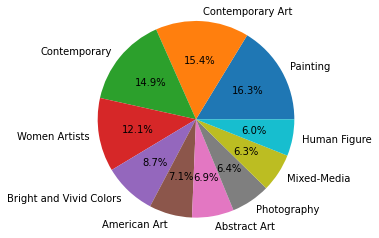

In [180]:
filtered_dict_aw = {k: v for k, v in artworks_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of new artworks', len(filtered_dict_aw))

filtered_dict_g = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of updated genes', len(filtered_dict_g))

updated_genes_count_dict = {}

for artwork in filtered_dict_aw.values():
  for gen in artwork['gene_id']:
    if gen in updated_genes_count_dict.keys():
      gen_count = updated_genes_count_dict[gen] + 1
      updated_genes_count_dict.update({gen: gen_count})
    else:
      updated_genes_count_dict.update({gen: 1})

print('Count of updated genes check', len(updated_genes_count_dict))

genes_ids = [v['id'] for v in filtered_dict_g.values()]
genes_names = [v['name'] for v in filtered_dict_g.values()]

def by_value(item):
  return item[1]

counts = []
genes = []
for k, v in sorted(updated_genes_count_dict.items(), key=by_value, reverse=True)[:10]:
  counts.append(v)
  genes.append(genes_names[genes_ids.index(k)])

fig, ax = plt.subplots()
ax.pie(counts[:10], labels=genes[:10], autopct='%1.1f%%')
ax.axis("equal")
plt.show()

## Categories & Genes

In [ ]:
# categories_dict = {'name_': {'genes_id': [], 'id': '', 'link': '', 'name': '', 
#                              'parsing_date': '', 'updating_date': ''}}

categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("Categories dictionary's length is - {}".format(len(categories_dict)))
print('')

def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

Categories dictionary's length is - 16

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 176
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


What I'm interested in:
- styles_and_movements -> id 03 -> genes count 252
- subject_matter -> id 02 -> genes count 213
- medium_and_techniques -> id 06 -> genes count 176
- visual_qualities -> id 05 -> genes count 75
- cultural_and_religious_styles -> id 11 -> genes count 69
- geographic_regions -> id 08 -> genes count 68
- materials -> id 09 -> genes count 39
- time_periods -> id 07 -> genes count 20

Filtered by:
- time_periods -> id 07 -> genes count 20
- styles_and_movements -> id 03 -> genes count 252
- medium_and_techniques -> id 06 -> genes count 176

In [ ]:
# genes_dict = {'name_': {'artist_id': [], 'artsy_id': [], 'category_id': '', 'id': '', 'link': '', 
#                         'name': '', 'parsing_date': '', 'updating_date': ''}}

genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("Genes dictionary's length is", len(genes_dict))

Genes dictionary's length is 1033


### commonality of artworks
Let's check our selected categories on commonality of artworks_id.

In [ ]:
# Creait all pairs of categories to find the better one by artworks corresponding as a start

cat_id_list = ['06', '03', '08', '02', '05', '09', '07', '11']
pairs = list(it.combinations(cat_id_list,2))

In [ ]:
# Get common list of artworks in list of categories
def get_common_list(items, output):
  artworks_lists = []
  for v in categories_dict.values():
    if v['id'] in items:
      cat_artwork_list = []
      for gene in v['genes_id']:
        for value in genes_dict.values():
          if value['id']==gene:
            cat_artwork_list = list(set(cat_artwork_list + value['artsy_id']))
      artworks_lists.append(cat_artwork_list)
      if output=='y':
        print('Category', v['id'], v['name'], '; Artworks count', len(cat_artwork_list))

  common_artworks_list = artworks_lists[0]
  for artwork_list in artworks_lists[1:]:
    common_artworks_list = list(set(common_artworks_list) & set(artwork_list))
    
  return common_artworks_list

In [ ]:
# Find the better pair of categories by artworks corresponding

list_len = 0
for pair in pairs:
  list_len_new = len(get_common_list(pair, 'n')) # Get common list of artworks in list of categories
  if list_len_new > list_len:
    best_pair = pair
    best_len = list_len_new
    list_len = list_len_new

print('The best pair with common artworks list length', best_len, 'is:')
for v in categories_dict.values():
  if v['id'] in best_pair:
    print('Category', v['id'], v['name'])

# reduce the previous list
cat_id_list = list(set(cat_id_list) - set(list(best_pair)))

The best pair with common artworks list length 72163 is:
Category 03 Styles and Movements
Category 06 Medium and Techniques


In [ ]:
common_list = get_common_list(best_pair, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501


72163

Well, both of the categories are in my supposed filter.

In [ ]:
# Get new ordered list of categories by artworks corresponding
def get_next_cat(id_list, items):
  list_len = 0
  for cat in id_list:
    items_list = items.copy()
    items_list.append(cat)
    list_len_new = len(get_common_list(items_list, 'n')) # Get common list of artworks in list of categories
    if list_len_new > list_len:
      best_ord = items_list.copy()
      best_len = list_len_new
      list_len = list_len_new

  print('The best order by common artworks list length', best_len, 'is:')
  for v in categories_dict.values():
    if v['id'] in best_ord:
      print('Category', v['id'], v['name'])
  print('')

  # reduce the previous list
  items_list_new = best_ord.copy()
  id_list_new = list(set(id_list) - set(items_list_new))
  
  if len(id_list_new) > 0:
    return get_next_cat(id_list_new, items_list_new) # repit to find next better category
  else:
    return items_list_new

In [ ]:
cat_id_list_ord = get_next_cat(cat_id_list, list(best_pair)) # Get new ordered list of categories by artworks corresponding
cat_id_list_ord

The best order by common artworks list length 44747 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 06 Medium and Techniques

The best order by common artworks list length 18974 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques

The best order by common artworks list length 5458 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 08 Geographic Regions

The best order by common artworks list length 1467 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic Regions

The best order by common artworks list length 155 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic

['06', '03', '02', '05', '08', '07', '09', '11']

In [ ]:
# All categories with artworks counts
common_list = get_common_list(cat_id_list_ord, 'y') # Get common list of artworks in list of categories
len(common_list)
# '06' > '03' > '08' > '02' > '05' > '09' > '07' > '11' by artworks count

Category 02 Subject Matter ; Artworks count 116159
Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028
Category 08 Geographic Regions ; Artworks count 140035
Category 09 Materials ; Artworks count 53400
Category 11 Cultural and Religious Styles ; Artworks count 8098


18

Categories by artworks count:
1. Category 06 Medium and Techniques ; Artworks count - 182.501
2. Category 03 Styles and Movements ; Artworks count - 170.068
3. Category 08 Geographic Regions ; Artworks count - 140.035
4. Category 02 Subject Matter ; Artworks count - 116.159
5. Category 05 Visual Qualities ; Artworks count - 77.262
6. Category 09 Materials ; Artworks count - 53.400
7. Category 07 Time Periods ; Artworks count - 44.028
8. Category 11 Cultural and Religious Styles ; Artworks count - 8.098

Categories by common artworks list:
1. Category 06 Medium and Techniques; List length - 182.501
2. Category 03 Styles and Movements; List length - 72.163
3. Category 02 Subject Matter; List length - 44.747
4. Category 05 Visual Qualities; List length - 18.974
5. Category 08 Geographic Regions; List length - 5.458
6. Category 07 Time Periods; List length - 1.467
7. Category 09 Materials; List length - 155
8. Category 11 Cultural and Religious Styles; List length - 18

In [ ]:
# My supposed filters
items = ['07', '03', '06']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


10902

Summing up, categories don't correspond with each other by artworks quite well. Why?
- as it is
- maximum pages for a gene were 100, maybe there're more artworks in fact

I can easely rid of:
- Category 08 Geographic Regions
- Category 09 Materials
- Category 11 Cultural and Religious Styles

And this one can be considered as bonus: 
- Category 02 Subject Matter


In [ ]:
items = ['06', '03', '05', '07']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


4092

Category 05 Visual Qualities is a big-big bonus in my case.

In [ ]:
items = ['06', '03', '05']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501


27042

I want to limit the whole data of artworks by certain:
- Time Periods (07: 44.028 a/w) ->
- Styles and Movements (03: 170.068 a/w) ->
- Medium and Techniques (06: 182.501 a/w)

And study their:
- Visual Qualities (05: 77.262 a/w) ->
- Subject Matter (02: 44.747 a/w)

So, what I can do to enlarge my limited database is:
1. Get artworks list of certain Time periods genes.
2. Get Styles and Movements genes of these artwoks.
3. Look at the rest artworks of these Styles and Movements genes - what Time periods genes they belong to - and limit the database with whole Styles and Movements genes.



### database limitation
Start with time periods

In [ ]:
time_periods_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='07'}
print('Time periods genes count', len(time_periods_genes_dict))

Time periods genes count 20


In [ ]:
for k in time_periods_genes_dict.keys():
  print(time_periods_genes_dict[k]['name'], '-> gene id', time_periods_genes_dict[k]['id'], '-> artwork count', len(time_periods_genes_dict[k]['artsy_id']))

1000 - 1400 CE Art -> gene id 07001 -> artwork count 947
15th Century Art -> gene id 07002 -> artwork count 2063
16th Century Art -> gene id 07003 -> artwork count 2990
17th Century Art -> gene id 07004 -> artwork count 3004
18th Century Art -> gene id 07005 -> artwork count 3007
1900 - 1917 Art -> gene id 07006 -> artwork count 3019
1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
1940s-1950s Art -> gene id 07008 -> artwork count 3287
19th Century Art -> gene id 07009 -> artwork count 3040
21st Century Art -> gene id 07010 -> artwork count 3035
500 - 1000 CE  Art -> gene id 07011 -> artwork count 121
Ancient Art -> gene id 07012 -> artwork count 1097
Art of the 1960s -> gene id 07013 -> artwork count 3031
Art of the 1970s -> gene id 07014 -> artwork count 3039
Art of the 1980s -> gene id 07015 -> artwork count 3037
Art of the 1990s -> gene id 07016 -> artwork count 3030
Contemporary -> gene id 07017 -> artwork count 3168
Late 19th Century Art -> gene id 07018 -> artwo

For now I'm interested in:
- 15th Century Art -> gene id 07002 -> artwork count 2063
- 16th Century Art -> gene id 07003 -> artwork count 2990
- 17th Century Art -> gene id 07004 -> artwork count 3004
- 18th Century Art -> gene id 07005 -> artwork count 3007
- 19th Century Art -> gene id 07009 -> artwork count 3040
- Late 19th Century Art -> gene id 07018 -> artwork count 3024

And:
- 1900 - 1917 Art -> gene id 07006 -> artwork count 3019
- 1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
- Modern -> gene id 07019 -> artwork count 3026

So, let's take the artworks of these genes and find them in Styles and Movements category.

In [ ]:
# 1. Get artworks list of certain Time periods genes.
time_periods_genes_list = ['07002', '07003', '07004', '07005', '07009', '07018', '07006', '07007', '07019']
time_periods_artworks_list = []
artwork_count = 0
for v in time_periods_genes_dict.values():
  if v['id'] in time_periods_genes_list:
    time_periods_artworks_list = list(set(time_periods_artworks_list + v['artsy_id']))
    artwork_count += len(v['artsy_id'])

print('Selected time periods genes count:', len(time_periods_genes_list))
print('artwork count:', artwork_count)
print('Unique artworks count:', len(time_periods_artworks_list))

Selected time periods genes count: 9
artwork count: 26213
Unique artworks count: 23402


In [ ]:
# 2. Get Styles and Movements genes of these artwoks
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}
common_periods_movements_artworks_list = []
periods_movements_genes_list = []
for v in styles_movements_genes_dict.values():
  id_list = list(set(v['artsy_id']) & set(time_periods_artworks_list))
  if len(id_list) != 0:
    common_periods_movements_artworks_list = list(set(common_periods_movements_artworks_list + id_list))
    periods_movements_genes_list.append(v['id'])

print('Styles and movements genes count', len(styles_movements_genes_dict))
print('Styles and movements genes by selected artworks count', len(periods_movements_genes_list))
print('Common artworks for Styles and movements and Time periods:', len(common_periods_movements_artworks_list))
print('Common ids check:', len(list(set(common_periods_movements_artworks_list) & set(time_periods_artworks_list))))

Styles and movements genes count 252
Styles and movements genes by selected artworks count 148
Common artworks for Styles and movements and Time periods: 8663
Common ids check: 8663


Just 1/3 of artworks of selected Time period genes are defined in Styles and movements category...

In [ ]:
# 3. Look at the rest artworks of these Styles and Movements genes (148) - 
#    what Time periods genes they belong to - 
#    and limit the database with whole Styles and Movements genes.

print('Styles and movemens genes by selected artworks count', len(periods_movements_genes_list))

# rest artworks of these Styles and Movements genes (148)
rest_periods_movements_artworks_list = []
for v in styles_movements_genes_dict.values():
  if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
    id_list = list(set(v['artsy_id']) - set(time_periods_artworks_list)) # artworks selected by time periods
    rest_periods_movements_artworks_list = list(set(rest_periods_movements_artworks_list + id_list))

print('Rest artworks for Styles and movements:', len(rest_periods_movements_artworks_list))
print('Rest ids check:', len(list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))))

Styles and movemens genes by selected artworks count 148
Rest artworks for Styles and movements: 131845
Rest ids check: 14739


In [ ]:
# Check the correctness
rest_time_periods_artworks_list = list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))
print('Rest artworks for Time periods:', len(rest_time_periods_artworks_list))
print('')
for v in styles_movements_genes_dict.values():
  if len(list(set(v['artsy_id']) & set(rest_time_periods_artworks_list))) > 0:
    print(v['name'], '-> gene id', v['id'])
# correct

Rest artworks for Time periods: 14739



In [ ]:
# what Time periods genes they belong to
rest_periods_movements_genes_list = []
rest_periods_artworks_lists = []

for v in time_periods_genes_dict.values(): # with all time periods genes
  if v['id'] not in time_periods_genes_list: # not in filtered time_period genes (but if it is, the artworks mustn't be in the list)
    id_list = list(set(v['artsy_id']) & set(rest_periods_movements_artworks_list)) # rest artworks of these Styles and Movements genes (148)
    if len(id_list) > 0: 
      rest_periods_movements_genes_list.append(v['id'])
      rest_periods_artworks_lists.append(id_list)

for v in time_periods_genes_dict.values():
  if v['id'] in rest_periods_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> cross artworks count', len(rest_periods_artworks_lists[rest_periods_movements_genes_list.index(v['id'])]))

1000 - 1400 CE Art -> gene id 07001 -> cross artworks count 204
1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
21st Century Art -> gene id 07010 -> cross artworks count 1373
500 - 1000 CE  Art -> gene id 07011 -> cross artworks count 59
Ancient Art -> gene id 07012 -> cross artworks count 303
Art of the 1960s -> gene id 07013 -> cross artworks count 2059
Art of the 1970s -> gene id 07014 -> cross artworks count 1141
Art of the 1980s -> gene id 07015 -> cross artworks count 1067
Art of the 1990s -> gene id 07016 -> cross artworks count 1272
Contemporary -> gene id 07017 -> cross artworks count 1092
Prehistoric Art -> gene id 07020 -> cross artworks count 16


All the others... That's super strange. Let's check some.

#### cross artworks checking

In [ ]:
def check_cross_artworks(gene, inx):
  print('Check {} gene'.format(gene))
  artworks_check_list = rest_periods_artworks_lists[rest_periods_movements_genes_list.index(inx)]
  print('length of the artworks_check_list', len(artworks_check_list))
  genes_check_list = []
  artworks_lists = []
  for v in styles_movements_genes_dict.values():
    if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
      id_list = list(set(v['artsy_id']) & set(artworks_check_list))
      if len(id_list) != 0:
        genes_check_list.append(v['id'])
        artworks_lists.append(id_list)
  print('length of the genes_check_list', len(genes_check_list))
  print('')

  for k, v in styles_movements_genes_dict.items():
    if v['id'] in genes_check_list:
      print(k, '->', v['name'], '-> gene id', v['id'], '-> cross artworks count', len(artworks_lists[genes_check_list.index(v['id'])]))


In [ ]:
gene = 'Prehistoric Art'
inx = '07020'

check_cross_artworks(gene, inx)
# OK

Check Prehistoric Art gene
length of the artworks_check_list 16
length of the genes_check_list 3

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 13
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 3


In [ ]:
gene = 'Ancient Art'
inx = '07012'

check_cross_artworks(gene, inx)
# gothic_art-??
# medieval_art-??
# northern_renaissance-??
# old_masters-??

# land_art-?
# pattern_and_decoration_movement-?

Check Ancient Art gene
length of the artworks_check_list 303
length of the genes_check_list 10

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 2
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 187
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 61
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 5
northern_renaissance -> Northern Renaissance -> gene id 03183 -> cross artworks count 1
old_masters -> Old Masters -> gene id 03188 -> cross artworks count 1
pattern_and_decoration_movement -> Pattern and Decoration Movement -> gene id 03192 -> cross artworks count 6
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 73


In [ ]:
gene = '500 - 1000 CE  Art'
inx = '07011'

check_cross_artworks(gene, inx)
# abstract_sculpture-?
# traditional_arts_of_africa_oceania_and_the_americas... geographic_regions -> id 08 !!!

# land_art-?

Check 500 - 1000 CE  Art gene
length of the artworks_check_list 59
length of the genes_check_list 8

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 23
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 28
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 3
symbolism -> Symbolism -> gene id 03233 -> cross artworks count 3
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 15


In [ ]:
gene = '1000 - 1400 CE Art'
inx = '07001'

check_cross_artworks(gene, inx)
# art_deco-??
# hyperrealism_and_photorealism-??
# impressionism_and_contemporary_impressionist-??
# op_art-??

# old_masters, old_master_drawings_and_prints-?

Check 1000 - 1400 CE Art gene
length of the artworks_check_list 204
length of the genes_check_list 17

abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 1
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
dutch_and_flemish -> Dutch and Flemish -> gene id 03109 -> cross artworks count 1
early_renaissance -> Early Renaissance -> gene id 03111 -> cross artworks count 11
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 46
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 42
hyperrealism_and_photorealism -> Hyperrealism and Photorealism -> gene id 03142 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 63
impressionism_and_contemporary_impressionist -> Impressionism and Contemporary Impressionist -> gene id 03146 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross ar

In [ ]:
gene = 'Contemporary'
inx = '07017'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check Contemporary gene
length of the artworks_check_list 1092
length of the genes_check_list 40

20th_century_art -> 20th Century Art -> gene id 03007 -> cross artworks count 1
abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 219
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 5
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 66
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
art_nouveau -> Art Nouveau -> gene id 03028 -> cross artworks count 1
collaborations_and_collectives -> Collaborations and Collectives -> gene id 03047 -> cross artworks count 1
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 40
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 52
contemporary_art -> Contemporary Art -> gene id 03056 -> cross artworks count 823
contemporary_asian_art -> Con

In [ ]:
gene = '21st Century Art'
inx = '07010'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check 21st Century Art gene
length of the artworks_check_list 1373
length of the genes_check_list 55

abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 255
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 58
abstract_photography -> Abstract Photography -> gene id 03011 -> cross artworks count 19
abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 13
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 97
conceptual_art -> Conceptual Art -> gene id 03049 -> cross artworks count 3
conceptual_art_and_contemporary_conceptualism -> Conceptual Art and Contemporary Conceptualism -> gene id 03050 -> cross artworks count 15
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 42
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 43
contemporary_art -> Contemporary Art ->

In [ ]:
#1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
#Art of the 1960s -> gene id 07013 -> cross artworks count 2059
#Art of the 1970s -> gene id 07014 -> cross artworks count 1141
#Art of the 1980s -> gene id 07015 -> cross artworks count 1067
#Art of the 1990s -> gene id 07016 -> cross artworks count 1272

### iconic_works_of_art_history

Unfortunatelly, I can't limit the database with whole Styles and Movements genes that have any common artworks with selected Time periods genes.

Interesting Styles and Movements gene - iconic_works_of_art_history. Let's explore it.

In [ ]:
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}

In [ ]:
iconic_works_list = styles_movements_genes_dict['iconic_works_of_art_history']['artsy_id']
len(iconic_works_list)

536

In [ ]:
# let's create two dataframes for further analysis and visualisation
category_id_list = []
cat_count_list = []

gene_name_list = []
gene_id_list = []
gene_cat_id_list = []
gene_count_list = []

In [ ]:
# what other Styles & Movements genes they belong to
iconic_movements_genes_list = []
iconic_movements_artworks_lists = []
category_id_list.append('03')

for v in styles_movements_genes_dict.values(): # with all time periods genes
  if v['id'] is not styles_movements_genes_dict['iconic_works_of_art_history']['id']: # not in filtered time_period genes
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_movements_genes_list.append(v['id'])
      iconic_movements_artworks_lists.append(id_list)

for v in styles_movements_genes_dict.values():
  if v['id'] in iconic_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))
    gene_id_list.append(v['id'])
    gene_name_list.append(v['name'])
    gene_cat_id_list.append(v['category_id'])
    gene_count_list.append(len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))

iconic_movements_artworks_unique = []
for id_list in iconic_movements_artworks_lists:
  iconic_movements_artworks_unique = list(set(iconic_movements_artworks_unique + id_list))
print('')
print('Total count of iconic artworks', len(iconic_movements_artworks_unique))
cat_count_list.append(len(iconic_movements_artworks_unique))

19th Century American Art -> gene id 03003 -> iconic artworks count 15
19th Century American Paintings and Works on Paper -> gene id 03004 -> iconic artworks count 12
19th Century French Academy -> gene id 03005 -> iconic artworks count 5
20th Century Art -> gene id 03007 -> iconic artworks count 1
Abstract Expressionism -> gene id 03009 -> iconic artworks count 4
American Impressionism -> gene id 03017 -> iconic artworks count 5
American Modernism -> gene id 03018 -> iconic artworks count 1
American Regionalism -> gene id 03021 -> iconic artworks count 1
American Sculpture 1830–1950 -> gene id 03022 -> iconic artworks count 1
American Tonalism -> gene id 03023 -> iconic artworks count 1
American Works on Paper 1880–1950 -> gene id 03024 -> iconic artworks count 1
Art Deco -> gene id 03026 -> iconic artworks count 1
Art Nouveau -> gene id 03028 -> iconic artworks count 6
Arte Povera -> gene id 03029 -> iconic artworks count 1
Barbizon School -> gene id 03031 -> iconic artworks count 1


In [ ]:
print("{} works aren't belong to Style or Movement, just to Iconic works".format(len(iconic_works_list) - len(iconic_periods_artworks_unique)))

117 works aren't belong to Style or Movement, just to Iconic works


Will be interesting to look at them.

In [ ]:
#sample(list(set(iconic_works_list) - set(iconic_periods_artworks_unique)), 10)

In [ ]:
# what other category genes they belong to
def get_stat_by_cat(cat):
  filtered_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']==cat}

  iconic_periods_genes_list = []
  iconic_periods_artworks_lists = []

  for v in filtered_genes_dict.values():
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_periods_genes_list.append(v['id'])
      iconic_periods_artworks_lists.append(id_list)

  for v in filtered_genes_dict.values():
    if v['id'] in iconic_periods_genes_list:
      print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
      gene_id_list.append(v['id'])
      gene_name_list.append(v['name'])
      gene_cat_id_list.append(v['category_id'])
      gene_count_list.append(len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
    
  iconic_periods_artworks_unique = []
  for id_list in iconic_periods_artworks_lists:
    iconic_periods_artworks_unique = list(set(iconic_periods_artworks_unique + id_list))
  print('')
  print('Total count of iconic artworks', len(iconic_periods_artworks_unique))
  cat_count_list.append(len(iconic_periods_artworks_unique))

In [ ]:
cat_id_list = ['06', '08', '02', '05', '09', '07', '11']
for cat in cat_id_list:
  for v in categories_dict.values():
    if v['id']==cat:
      category_id_list.append(v['id'])
      print('Iconic artworks belong to further genes in category', v['name'])
      print('')
      get_stat_by_cat(cat)
      print('')

Iconic artworks belong to further genes in category Medium and Techniques

Album, Folio and Fan Formats -> gene id 06002 -> iconic artworks count 2
Altarpiece -> gene id 06003 -> iconic artworks count 8
Appropriation -> gene id 06007 -> iconic artworks count 5
Arabic/Farsi Calligraphy -> gene id 06008 -> iconic artworks count 7
Archaeological Object -> gene id 06009 -> iconic artworks count 3
Art That Plays With Scale -> gene id 06010 -> iconic artworks count 3
Automatism -> gene id 06013 -> iconic artworks count 4
Caravaggesque -> gene id 06020 -> iconic artworks count 4
Chiaroscuro -> gene id 06023 -> iconic artworks count 42
Cinematic -> gene id 06024 -> iconic artworks count 1
Color Theory -> gene id 06029 -> iconic artworks count 8
Comic/Cartoon -> gene id 06030 -> iconic artworks count 1
Copies and Emulations -> gene id 06032 -> iconic artworks count 4
Densely Textured or Haptic Surface -> gene id 06036 -> iconic artworks count 3
Divinatory Objects, Talismans, and Amulets -> gene

In [ ]:
def get_cat_name(cell):
  for v in categories_dict.values():
    if v['id']==cell:
      cell = v['name']
  return cell

In [ ]:
cat_count_df = pd.DataFrame({'category_id': category_id_list, 
                             'count':cat_count_list
                             }) # + category_name

gene_count_df = pd.DataFrame({'gene_name': gene_name_list, 'gene_id': gene_id_list, 
                           'category_id': gene_cat_id_list, 'count': gene_count_list
                           }) # + category_name

#cat_count_df = cat_count_df.set_axis(['category_id', 'count'], axis=1, inplace=False)
#gene_count_df = gene_count_df.set_axis(['gene_name', 'gene_id', 'category_id', 'count'], axis=1, inplace=False)

cat_count_df['category_name'] = cat_count_df['category_id'].dropna().apply(get_cat_name)
gene_count_df['category_name'] = gene_count_df['category_id'].dropna().apply(get_cat_name)

In [ ]:
cat_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      object
 1   count          8 non-null      int64 
 2   category_name  8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [ ]:
gene_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_name      388 non-null    object
 1   gene_id        388 non-null    object
 2   category_id    388 non-null    object
 3   count          388 non-null    int64 
 4   category_name  388 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [ ]:
cat_count_df

,category_id,count,category_name
0,03,419,Styles and Movements
1,06,272,Medium and Techniques
2,08,31,Geographic Regions
3,02,471,Subject Matter
4,05,219,Visual Qualities
5,09,58,Materials
6,07,353,Time Periods
7,11,233,Cultural and Religious Styles


In [ ]:
gene_count_df.sample(10)

,gene_name,gene_id,category_id,count,category_name
184,Face,02062,02,15,Subject Matter
304,Hard-Edged,05035,05,2,Visual Qualities
94,En plein air,06049,06,8,Medium and Techniques
201,Hybrids and Imaginary Creatures,02085,02,17,Subject Matter
212,Madonna and Child,02106,02,17,Subject Matter
84,Chiaroscuro,06023,06,42,Medium and Techniques
338,Mosaics,09021,09,7,Materials
138,Central Asian Art,08019,08,1,Geographic Regions
264,The City,02188,02,3,Subject Matter
343,Use of Ephemeral Materials,09035,09,1,Materials


In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  print('Sum by category', gene_count_df.loc[gene_count_df['category_name']==cat]['count'].sum())
  print('Unique by category', cat_count_df.loc[cat_count_df['category_name']==cat]['count'].values[0])
  print('')
  print(gene_count_df.loc[gene_count_df['category_name']==cat].describe())
  print('')

Styles and Movements
Sum by category 891
Unique by category 419

            count
count   76.000000
mean    11.723684
std     22.077197
min      1.000000
25%      1.000000
50%      3.000000
75%     12.000000
max    127.000000

Medium and Techniques
Sum by category 395
Unique by category 272

          count
count  61.00000
mean    6.47541
std     8.44513
min     1.00000
25%     1.00000
50%     3.00000
75%     8.00000
max    44.00000

Geographic Regions
Sum by category 31
Unique by category 31

           count
count   7.000000
mean    4.428571
std     4.613644
min     1.000000
25%     1.000000
50%     2.000000
75%     7.500000
max    11.000000

Subject Matter
Sum by category 1819
Unique by category 471

            count
count  140.000000
mean    12.992857
std     16.920252
min      1.000000
25%      3.000000
50%      7.000000
75%     16.250000
max     96.000000

Visual Qualities
Sum by category 308
Unique by category 219

           count
count  44.000000
mean    7.000000
std     9.8

Most of the categories has a lot of genes what makes visualization confusing. Let's merge genes with less then third quartile artworks into an 'Others' in every category except ones with less then 10 genes.

In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  print('Count of genes before renaming:', cat_df['gene_name'].nunique())
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  print('Count of genes after renaming:', cat_df_new['gene_name'].nunique())
  print('')

Styles and Movements
Count of genes before renaming: 76
Count of genes after renaming: 23

Medium and Techniques
Count of genes before renaming: 61
Count of genes after renaming: 19

Geographic Regions
Count of genes before renaming: 7
Count of genes after renaming: 7

Subject Matter
Count of genes before renaming: 140
Count of genes after renaming: 36

Visual Qualities
Count of genes before renaming: 44
Count of genes after renaming: 13

Materials
Count of genes before renaming: 17
Count of genes after renaming: 7

Time Periods
Count of genes before renaming: 9
Count of genes after renaming: 9

Cultural and Religious Styles
Count of genes before renaming: 34
Count of genes after renaming: 10



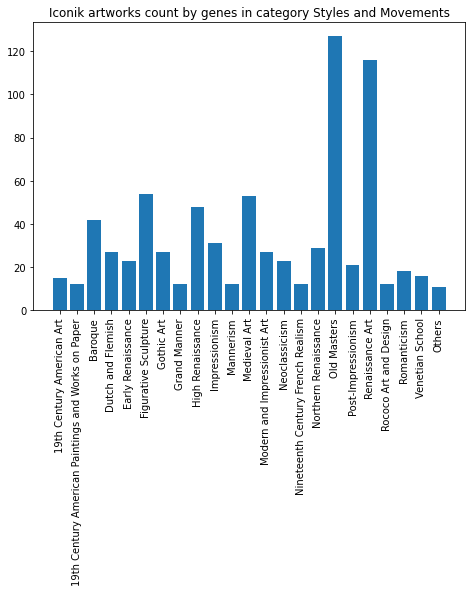

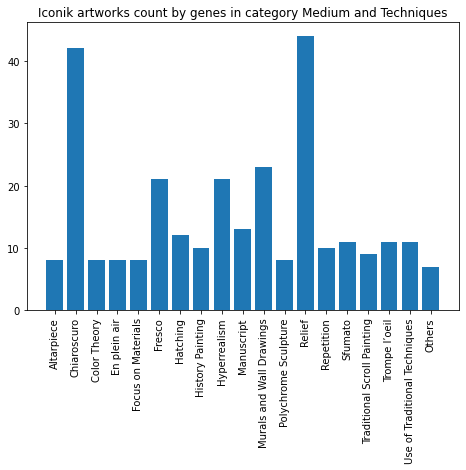

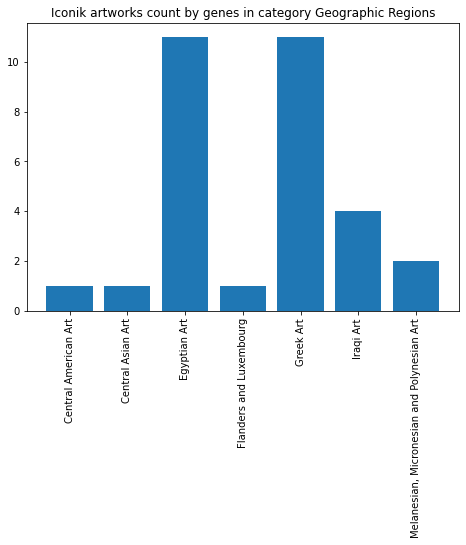

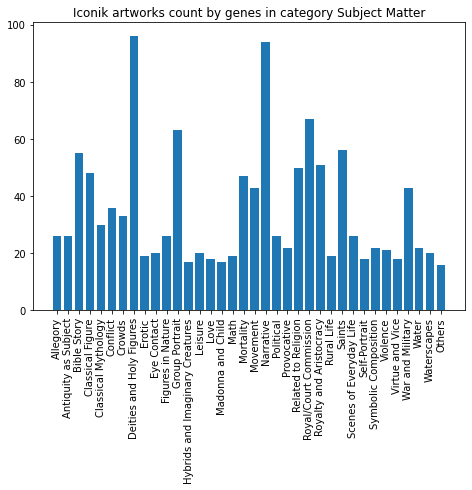

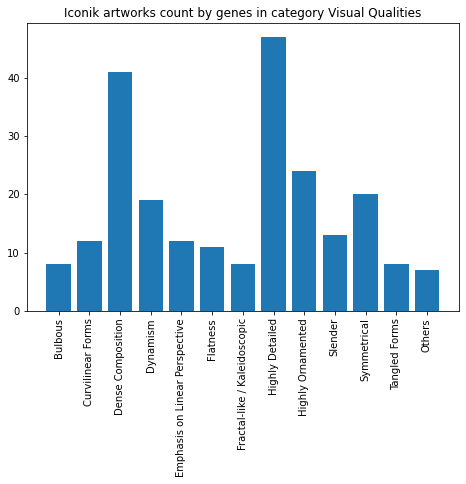

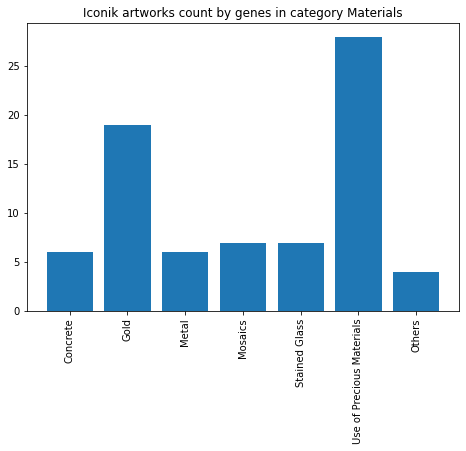

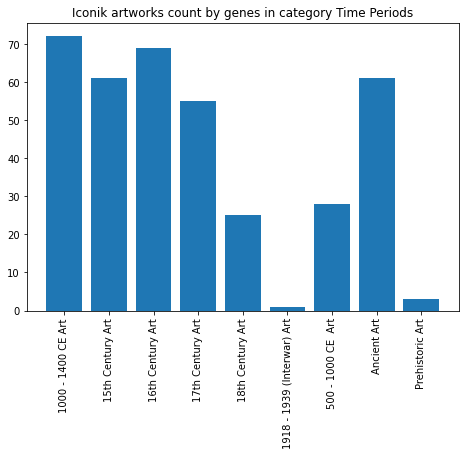

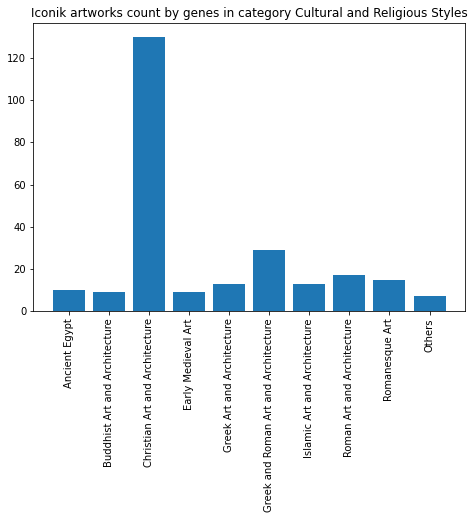

In [ ]:
for cat in gene_count_df['category_name'].unique():
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  
  fig = plt.figure()
  axes = fig.add_axes([0, 0, 1, 1])
  axes.bar(x = cat_df_new['gene_name'], height = cat_df_new['count'])
  axes.set_xticklabels(cat_df_new['gene_name'], rotation = 90)
  axes.set_title('Iconik artworks count by genes in category {}'.format(cat))
  
  plt.show()

  print('')

In [ ]:
# artists_dict = {'id': {'artsy_id': [], 'category_id': [], 'gene_id': [], 'name': ''}}

#artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
#len(artists_dict)

# artworks_dict = {'artsy_id': {'artist': '', 'artist_id': '', 'category_id': [], 'gallery': '', 'gene_id': [],
#                               'link': '', 'name': '', 'parsing_date': '', 'price': '', 'updating_date': ', 'year': ''}}

#artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
#len(artworks_dict)

# Images

In [ ]:
# Sample from API tables

# 'image': {'href': 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/{image_version}.jpg',
#                      'templated': True}
#i = 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/normalized.jpg'
#for p in i.split('.jpg')[0].split('/'):
#  print(len(p), p)

6 https:
0 
29 d32dm0rphc51dk.cloudfront.net
22 NOpIAwQa-3r51Cg9qXKbfA
10 normalized


In [ ]:
#! pip install pillow --user

import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
image = requests.get(img, headers={'User-Agent': 'Chrome/97.0.4692.71'})
name = art_project_path + '/' + 'portrait_of_a_man_in_armour' + '.jpg'

img = open(name, 'wb')
img.write(image.content)
img.close()

img = Image.open(name)
plt.imshow(img)
plt.axis('off')
plt.show()

img.close()